## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


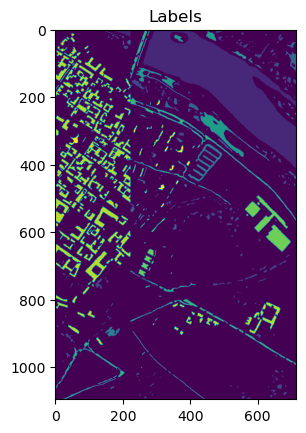

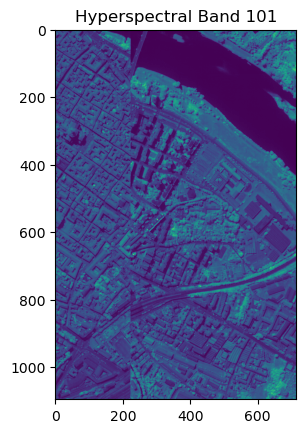

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 10 train


 -- Test set created with: 
	148017 samples
	shape (148017, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(90, 5, 5, 102)
(45, 5, 5, 102)
(148017, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 90
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1695, PSNR: 3.7803


	 Training Batch [200/1852], Loss: 0.0904, PSNR: 5.9768


	 Training Batch [400/1852], Loss: 0.0483, PSNR: 9.2540


	 Training Batch [600/1852], Loss: 0.0275, PSNR: 13.0529


	 Training Batch [800/1852], Loss: 0.0151, PSNR: 13.6994


	 Training Batch [1000/1852], Loss: 0.0107, PSNR: 16.7673


	 Training Batch [1200/1852], Loss: 0.0074, PSNR: 16.2698


	 Training Batch [1400/1852], Loss: 0.0062, PSNR: 18.9089


	 Training Batch [1600/1852], Loss: 0.0067, PSNR: 17.7330


	 Training Batch [1800/1852], Loss: 0.0047, PSNR: 17.7595


Epoch [1/50] Training Loss: 0.0317, PSNR: 13.7814
	[Val]   Batch [1/463] Loss: 0.0053, PSNR: 17.9790
	[Val]   Batch [10/463] Loss: 0.0050, PSNR: 19.1230
	[Val]   Batch [20/463] Loss: 0.0050, PSNR: 18.1212
	[Val]   Batch [30/463] Loss: 0.0060, PSNR: 18.7029
	[Val]   Batch [40/463] Loss: 0.0048, PSNR: 17.8073
	[Val]   Batch [50/463] Loss: 0.0050, PSNR: 18.0283
	[Val]   Batch [60/463] Loss: 0.0048, PSNR: 18.0562


	[Val]   Batch [70/463] Loss: 0.0067, PSNR: 18.4438
	[Val]   Batch [80/463] Loss: 0.0060, PSNR: 20.3482
	[Val]   Batch [90/463] Loss: 0.0058, PSNR: 19.4353
	[Val]   Batch [100/463] Loss: 0.0059, PSNR: 19.1465
	[Val]   Batch [110/463] Loss: 0.0068, PSNR: 18.5558
	[Val]   Batch [120/463] Loss: 0.0046, PSNR: 18.0472
	[Val]   Batch [130/463] Loss: 0.0054, PSNR: 19.4574
	[Val]   Batch [140/463] Loss: 0.0063, PSNR: 19.0355


	[Val]   Batch [150/463] Loss: 0.0072, PSNR: 19.0447
	[Val]   Batch [160/463] Loss: 0.0058, PSNR: 19.3002
	[Val]   Batch [170/463] Loss: 0.0074, PSNR: 18.2645
	[Val]   Batch [180/463] Loss: 0.0054, PSNR: 19.0517
	[Val]   Batch [190/463] Loss: 0.0059, PSNR: 19.3644
	[Val]   Batch [200/463] Loss: 0.0059, PSNR: 18.7356
	[Val]   Batch [210/463] Loss: 0.0057, PSNR: 18.3709
	[Val]   Batch [220/463] Loss: 0.0056, PSNR: 19.5982


	[Val]   Batch [230/463] Loss: 0.0067, PSNR: 19.4113
	[Val]   Batch [240/463] Loss: 0.0051, PSNR: 18.1918
	[Val]   Batch [250/463] Loss: 0.0065, PSNR: 17.4135
	[Val]   Batch [260/463] Loss: 0.0057, PSNR: 18.4017
	[Val]   Batch [270/463] Loss: 0.0044, PSNR: 17.5528
	[Val]   Batch [280/463] Loss: 0.0053, PSNR: 20.2895
	[Val]   Batch [290/463] Loss: 0.0059, PSNR: 17.2973


	[Val]   Batch [300/463] Loss: 0.0059, PSNR: 19.5243
	[Val]   Batch [310/463] Loss: 0.0055, PSNR: 19.4206
	[Val]   Batch [320/463] Loss: 0.0055, PSNR: 19.2818
	[Val]   Batch [330/463] Loss: 0.0065, PSNR: 18.6878
	[Val]   Batch [340/463] Loss: 0.0053, PSNR: 19.6354
	[Val]   Batch [350/463] Loss: 0.0069, PSNR: 19.5668
	[Val]   Batch [360/463] Loss: 0.0046, PSNR: 20.4952


	[Val]   Batch [370/463] Loss: 0.0068, PSNR: 18.6345
	[Val]   Batch [380/463] Loss: 0.0067, PSNR: 18.7791
	[Val]   Batch [390/463] Loss: 0.0062, PSNR: 18.5862
	[Val]   Batch [400/463] Loss: 0.0054, PSNR: 17.6515
	[Val]   Batch [410/463] Loss: 0.0053, PSNR: 19.9521
	[Val]   Batch [420/463] Loss: 0.0055, PSNR: 18.7588
	[Val]   Batch [430/463] Loss: 0.0054, PSNR: 18.1793


	[Val]   Batch [440/463] Loss: 0.0053, PSNR: 19.1740
	[Val]   Batch [450/463] Loss: 0.0041, PSNR: 16.5267
	[Val]   Batch [460/463] Loss: 0.0057, PSNR: 17.9123
Epoch [1/50] Validation Loss: 0.0057, PSNR: 18.7320

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0051, PSNR: 17.4502


	 Training Batch [200/1852], Loss: 0.0057, PSNR: 19.2686


	 Training Batch [400/1852], Loss: 0.0044, PSNR: 18.6889


	 Training Batch [600/1852], Loss: 0.0041, PSNR: 19.9241


	 Training Batch [800/1852], Loss: 0.0035, PSNR: 18.5573


	 Training Batch [1000/1852], Loss: 0.0031, PSNR: 20.7007


	 Training Batch [1200/1852], Loss: 0.0030, PSNR: 20.7826


	 Training Batch [1400/1852], Loss: 0.0042, PSNR: 20.4366


	 Training Batch [1600/1852], Loss: 0.0035, PSNR: 21.1772


	 Training Batch [1800/1852], Loss: 0.0027, PSNR: 22.7264


Epoch [2/50] Training Loss: 0.0042, PSNR: 20.1870
	[Val]   Batch [1/463] Loss: 0.0025, PSNR: 21.1795
	[Val]   Batch [10/463] Loss: 0.0024, PSNR: 22.3618
	[Val]   Batch [20/463] Loss: 0.0023, PSNR: 21.4203
	[Val]   Batch [30/463] Loss: 0.0030, PSNR: 21.7659
	[Val]   Batch [40/463] Loss: 0.0023, PSNR: 21.0095
	[Val]   Batch [50/463] Loss: 0.0024, PSNR: 21.1780
	[Val]   Batch [60/463] Loss: 0.0023, PSNR: 21.2694


	[Val]   Batch [70/463] Loss: 0.0034, PSNR: 21.3833
	[Val]   Batch [80/463] Loss: 0.0030, PSNR: 23.2853
	[Val]   Batch [90/463] Loss: 0.0028, PSNR: 22.6056
	[Val]   Batch [100/463] Loss: 0.0030, PSNR: 22.0283
	[Val]   Batch [110/463] Loss: 0.0034, PSNR: 21.5510
	[Val]   Batch [120/463] Loss: 0.0022, PSNR: 21.2120
	[Val]   Batch [130/463] Loss: 0.0026, PSNR: 22.6701


	[Val]   Batch [140/463] Loss: 0.0032, PSNR: 22.0070
	[Val]   Batch [150/463] Loss: 0.0036, PSNR: 22.1149
	[Val]   Batch [160/463] Loss: 0.0030, PSNR: 22.1432
	[Val]   Batch [170/463] Loss: 0.0038, PSNR: 21.1667
	[Val]   Batch [180/463] Loss: 0.0028, PSNR: 21.8339
	[Val]   Batch [190/463] Loss: 0.0029, PSNR: 22.4918
	[Val]   Batch [200/463] Loss: 0.0030, PSNR: 21.7566


	[Val]   Batch [210/463] Loss: 0.0030, PSNR: 21.1393
	[Val]   Batch [220/463] Loss: 0.0029, PSNR: 22.5184
	[Val]   Batch [230/463] Loss: 0.0032, PSNR: 22.5556
	[Val]   Batch [240/463] Loss: 0.0025, PSNR: 21.3369
	[Val]   Batch [250/463] Loss: 0.0033, PSNR: 20.3634
	[Val]   Batch [260/463] Loss: 0.0028, PSNR: 21.4281
	[Val]   Batch [270/463] Loss: 0.0020, PSNR: 20.8798
	[Val]   Batch [280/463] Loss: 0.0026, PSNR: 23.3850


	[Val]   Batch [290/463] Loss: 0.0028, PSNR: 20.4515
	[Val]   Batch [300/463] Loss: 0.0029, PSNR: 22.5762
	[Val]   Batch [310/463] Loss: 0.0029, PSNR: 22.1929
	[Val]   Batch [320/463] Loss: 0.0028, PSNR: 22.2894
	[Val]   Batch [330/463] Loss: 0.0031, PSNR: 21.8995
	[Val]   Batch [340/463] Loss: 0.0026, PSNR: 22.6851
	[Val]   Batch [350/463] Loss: 0.0037, PSNR: 22.3246
	[Val]   Batch [360/463] Loss: 0.0024, PSNR: 23.3010


	[Val]   Batch [370/463] Loss: 0.0033, PSNR: 21.7814
	[Val]   Batch [380/463] Loss: 0.0031, PSNR: 22.0647
	[Val]   Batch [390/463] Loss: 0.0029, PSNR: 21.7974
	[Val]   Batch [400/463] Loss: 0.0027, PSNR: 20.6265
	[Val]   Batch [410/463] Loss: 0.0025, PSNR: 23.1899
	[Val]   Batch [420/463] Loss: 0.0026, PSNR: 21.9376
	[Val]   Batch [430/463] Loss: 0.0027, PSNR: 21.1069


	[Val]   Batch [440/463] Loss: 0.0027, PSNR: 22.1136
	[Val]   Batch [450/463] Loss: 0.0020, PSNR: 19.5875
	[Val]   Batch [460/463] Loss: 0.0028, PSNR: 21.0925
Epoch [2/50] Validation Loss: 0.0028, PSNR: 21.8113

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0026, PSNR: 21.2738


	 Training Batch [200/1852], Loss: 0.0026, PSNR: 21.6983


	 Training Batch [400/1852], Loss: 0.0022, PSNR: 23.1581


	 Training Batch [600/1852], Loss: 0.0023, PSNR: 23.1893


	 Training Batch [800/1852], Loss: 0.0020, PSNR: 21.9212


	 Training Batch [1000/1852], Loss: 0.0020, PSNR: 21.9024


	 Training Batch [1200/1852], Loss: 0.0019, PSNR: 23.6821


	 Training Batch [1400/1852], Loss: 0.0019, PSNR: 24.8582


	 Training Batch [1600/1852], Loss: 0.0018, PSNR: 23.5399


	 Training Batch [1800/1852], Loss: 0.0016, PSNR: 22.8087


Epoch [3/50] Training Loss: 0.0023, PSNR: 22.7812
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.5064
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.7443
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.9081
	[Val]   Batch [30/463] Loss: 0.0016, PSNR: 24.4124
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 23.0632
	[Val]   Batch [50/463] Loss: 0.0014, PSNR: 23.4312
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.4506


	[Val]   Batch [70/463] Loss: 0.0019, PSNR: 24.0389
	[Val]   Batch [80/463] Loss: 0.0016, PSNR: 25.9610
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 25.0237
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.5446
	[Val]   Batch [110/463] Loss: 0.0018, PSNR: 24.2646
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.3073
	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.3303
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.5382


	[Val]   Batch [150/463] Loss: 0.0018, PSNR: 25.1059
	[Val]   Batch [160/463] Loss: 0.0018, PSNR: 24.3159
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.6088
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.1417
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 25.1366
	[Val]   Batch [200/463] Loss: 0.0016, PSNR: 24.4713
	[Val]   Batch [210/463] Loss: 0.0018, PSNR: 23.2961


	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.7336
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.6227
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.7163
	[Val]   Batch [250/463] Loss: 0.0019, PSNR: 22.6470
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6788
	[Val]   Batch [270/463] Loss: 0.0012, PSNR: 23.0442
	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.7282


	[Val]   Batch [290/463] Loss: 0.0016, PSNR: 22.8514
	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 24.8760
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.3144
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.7348
	[Val]   Batch [330/463] Loss: 0.0016, PSNR: 24.6338
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 25.0594
	[Val]   Batch [350/463] Loss: 0.0021, PSNR: 24.7377


	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.9169
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.4349
	[Val]   Batch [380/463] Loss: 0.0016, PSNR: 25.0494
	[Val]   Batch [390/463] Loss: 0.0015, PSNR: 24.6162
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.7618
	[Val]   Batch [410/463] Loss: 0.0014, PSNR: 25.5844
	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.4503


	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.2171
	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.2876
	[Val]   Batch [450/463] Loss: 0.0013, PSNR: 21.4516
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.5271
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.2564

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0019, PSNR: 24.0042


	 Training Batch [200/1852], Loss: 0.0020, PSNR: 23.7675


	 Training Batch [400/1852], Loss: 0.0019, PSNR: 24.3045


	 Training Batch [600/1852], Loss: 0.0023, PSNR: 22.4253


	 Training Batch [800/1852], Loss: 0.0016, PSNR: 23.8534


	 Training Batch [1000/1852], Loss: 0.0014, PSNR: 24.3926


	 Training Batch [1200/1852], Loss: 0.0013, PSNR: 24.4281


	 Training Batch [1400/1852], Loss: 0.0019, PSNR: 24.4451


	 Training Batch [1600/1852], Loss: 0.0012, PSNR: 25.3044


	 Training Batch [1800/1852], Loss: 0.0015, PSNR: 24.7832


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.4477
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.9376
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.2275
	[Val]   Batch [20/463] Loss: 0.0009, PSNR: 25.4388
	[Val]   Batch [30/463] Loss: 0.0011, PSNR: 25.9080
	[Val]   Batch [40/463] Loss: 0.0010, PSNR: 24.4097
	[Val]   Batch [50/463] Loss: 0.0010, PSNR: 24.9091
	[Val]   Batch [60/463] Loss: 0.0010, PSNR: 24.8466


	[Val]   Batch [70/463] Loss: 0.0013, PSNR: 25.5573
	[Val]   Batch [80/463] Loss: 0.0011, PSNR: 27.6662
	[Val]   Batch [90/463] Loss: 0.0011, PSNR: 26.5228
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 26.0568
	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.8902
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.7332
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.8810


	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 26.0541
	[Val]   Batch [150/463] Loss: 0.0012, PSNR: 26.8088
	[Val]   Batch [160/463] Loss: 0.0013, PSNR: 25.6560
	[Val]   Batch [170/463] Loss: 0.0016, PSNR: 24.9705
	[Val]   Batch [180/463] Loss: 0.0012, PSNR: 25.5173
	[Val]   Batch [190/463] Loss: 0.0011, PSNR: 26.6428
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 26.1455
	[Val]   Batch [210/463] Loss: 0.0013, PSNR: 24.6410


	[Val]   Batch [220/463] Loss: 0.0012, PSNR: 26.1230
	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.3763
	[Val]   Batch [240/463] Loss: 0.0010, PSNR: 25.2281
	[Val]   Batch [250/463] Loss: 0.0014, PSNR: 24.0053
	[Val]   Batch [260/463] Loss: 0.0012, PSNR: 25.0167
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.5994
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.1955


	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.3625
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.2163
	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.7040
	[Val]   Batch [320/463] Loss: 0.0011, PSNR: 26.2762
	[Val]   Batch [330/463] Loss: 0.0011, PSNR: 26.2195
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.5563
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.2114
	[Val]   Batch [360/463] Loss: 0.0013, PSNR: 25.9671


	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.9891
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.7809
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.2518
	[Val]   Batch [400/463] Loss: 0.0012, PSNR: 24.0842
	[Val]   Batch [410/463] Loss: 0.0010, PSNR: 27.1023
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.9208
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.4987
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.6808


	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.8133
	[Val]   Batch [460/463] Loss: 0.0011, PSNR: 24.9705
Epoch [4/50] Validation Loss: 0.0011, PSNR: 25.7587

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0014, PSNR: 26.2728


	 Training Batch [200/1852], Loss: 0.0011, PSNR: 23.6845


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 26.1116


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 25.7088


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 27.1525


	 Training Batch [1000/1852], Loss: 0.0014, PSNR: 25.3743


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 27.0612


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 25.1884


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 25.6069


	 Training Batch [1800/1852], Loss: 0.0010, PSNR: 26.3368


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.5431
	[Val]   Batch [1/463] Loss: 0.0008, PSNR: 25.9585
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.3121
	[Val]   Batch [20/463] Loss: 0.0007, PSNR: 26.5141
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 26.9243
	[Val]   Batch [40/463] Loss: 0.0008, PSNR: 25.3810
	[Val]   Batch [50/463] Loss: 0.0008, PSNR: 26.0099
	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.8509


	[Val]   Batch [70/463] Loss: 0.0010, PSNR: 26.6174
	[Val]   Batch [80/463] Loss: 0.0008, PSNR: 28.9438
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.6424
	[Val]   Batch [100/463] Loss: 0.0009, PSNR: 27.1781
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 27.0287
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.7859
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.9464
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 27.1618


	[Val]   Batch [150/463] Loss: 0.0009, PSNR: 27.9788
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.6353
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.9676
	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.5600
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.6811
	[Val]   Batch [200/463] Loss: 0.0008, PSNR: 27.3556
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.6830


	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 27.1056
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.5803
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.3446
	[Val]   Batch [250/463] Loss: 0.0011, PSNR: 25.0042
	[Val]   Batch [260/463] Loss: 0.0010, PSNR: 25.9770
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.7570
	[Val]   Batch [280/463] Loss: 0.0008, PSNR: 28.2770


	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.4579
	[Val]   Batch [300/463] Loss: 0.0010, PSNR: 27.2049
	[Val]   Batch [310/463] Loss: 0.0010, PSNR: 26.7501
	[Val]   Batch [320/463] Loss: 0.0008, PSNR: 27.4544
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.3572
	[Val]   Batch [340/463] Loss: 0.0008, PSNR: 27.6572
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.2511
	[Val]   Batch [360/463] Loss: 0.0011, PSNR: 26.7453


	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 27.0766
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 27.9742
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.3928
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 25.0710
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.1755
	[Val]   Batch [420/463] Loss: 0.0008, PSNR: 26.9545
	[Val]   Batch [430/463] Loss: 0.0010, PSNR: 25.4200


	[Val]   Batch [440/463] Loss: 0.0009, PSNR: 26.7093
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.8775
	[Val]   Batch [460/463] Loss: 0.0009, PSNR: 26.0268
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.8421

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 27.1045


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 26.4000


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 24.9869


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 26.6635


	 Training Batch [800/1852], Loss: 0.0010, PSNR: 26.7456


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 26.5105


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 25.9206


	 Training Batch [1400/1852], Loss: 0.0010, PSNR: 24.5151


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 26.4735


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 24.2697


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.4135
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.8644
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.2854
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.5223
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 27.8184
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.3103
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.0508
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 26.7441


	[Val]   Batch [70/463] Loss: 0.0008, PSNR: 27.5643
	[Val]   Batch [80/463] Loss: 0.0006, PSNR: 30.0442
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.6036
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.1436
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 28.0522
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 26.7721
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 28.8940


	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 28.0877
	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 29.0393
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.5699
	[Val]   Batch [170/463] Loss: 0.0010, PSNR: 26.8889
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.5214
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.6227
	[Val]   Batch [200/463] Loss: 0.0006, PSNR: 28.4440
	[Val]   Batch [210/463] Loss: 0.0008, PSNR: 26.6557


	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 27.9882
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 29.5728
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.3036
	[Val]   Batch [250/463] Loss: 0.0009, PSNR: 25.9647
	[Val]   Batch [260/463] Loss: 0.0008, PSNR: 26.9392
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 26.8581
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.2654


	[Val]   Batch [290/463] Loss: 0.0007, PSNR: 26.4224
	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.0865
	[Val]   Batch [310/463] Loss: 0.0008, PSNR: 27.7235
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.5202
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.3452
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.6584
	[Val]   Batch [350/463] Loss: 0.0009, PSNR: 28.1976


	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.4177
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 28.0827
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 29.0306
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 28.3843
	[Val]   Batch [400/463] Loss: 0.0008, PSNR: 25.9861
	[Val]   Batch [410/463] Loss: 0.0006, PSNR: 29.1069
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.8973


	[Val]   Batch [430/463] Loss: 0.0008, PSNR: 26.3379
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.6218
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.8700
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 27.0289
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.8236

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0012, PSNR: 26.9464


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 27.8791


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 27.2103


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 26.1374


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 27.3282


	 Training Batch [1000/1852], Loss: 0.0009, PSNR: 26.7712


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 27.5371


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.6227


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 27.7835


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 27.6602


Epoch [7/50] Training Loss: 0.0008, PSNR: 27.1147
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.5402
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 29.0637
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.2614
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.5348
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 27.0150
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 27.8558
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.4083


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.2935
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 30.9148
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.3413
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.9044
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 28.8386
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.5329
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.5769


	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.7853
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.8720
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.3828
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.6402
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.2604
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.2988
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.2376


	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.4459
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.7133
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.3073
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 28.0293
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.7489
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.7482
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.7132


	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.9934
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.1865
	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.7844
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.5575
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.3200
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 29.0819
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.4467


	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 28.9519
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 27.8955
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.8200
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.7954
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.1515
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.6571
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 29.7937


	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.6257
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 27.0918
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.3295
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.6546
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.8613
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.5797

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 27.9807


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 24.8473


	 Training Batch [400/1852], Loss: 0.0008, PSNR: 27.3358


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 25.0794


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 26.9691


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 29.3590


	 Training Batch [1200/1852], Loss: 0.0009, PSNR: 27.4246


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.6109


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 26.8800


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.5752


Epoch [8/50] Training Loss: 0.0007, PSNR: 27.7119
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.3006
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.9376
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.1343
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.3629
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.7525
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.7435
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 28.1487


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 29.2034
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.8944
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.2236
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.7568
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.7791
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.3108


	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.4368
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.6237
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.9187
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.2276
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.5356
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.0917
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.0729


	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.1039
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.3702
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.4165
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.2608
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 28.8948
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.6621


	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.6609
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.5525
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.8192
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.0653
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.5807
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.3142
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.2075


	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.9902
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.2917
	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.8029
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.4131
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.7395
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.8447
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.1141


	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.3819
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.5683
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.5011
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.8634
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.0410
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.3988
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.7420
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.4394

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 28.4856


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 26.4865


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.5757


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 28.5130


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 30.1076


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 29.1444


	 Training Batch [1200/1852], Loss: 0.0010, PSNR: 26.6594


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 27.8267


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 26.8691


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 27.9619


Epoch [9/50] Training Loss: 0.0007, PSNR: 28.2065
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.8184
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.5137
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.6725
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.9318
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.2151
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.3281
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.6269


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.8084
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.5226
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.7802
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.3477
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.3796
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.7876
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.9680
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.1554


	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.6213
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 29.8809
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.1245
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.6597
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.6339
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.7191
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.9749
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.8763


	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.8244
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.4477
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.2995
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.3135
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.0381
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.3287
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.7181
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.1137


	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.8035
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.8077
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.5978
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.8362
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.4158
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.6917
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.3480


	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 31.5308
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.7193
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.8665
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.0649
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.0317
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.3595
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.5072


	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.8806
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.3183
Epoch [9/50] Validation Loss: 0.0004, PSNR: 30.0111

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.5087


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 27.6105


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.2834


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 29.1352


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 28.1845


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 30.1683


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 28.6759


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.5101


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 28.6564


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 28.0029


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.5708
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.2044
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.9608
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.1433
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.3521
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.6450
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.8126
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.1028


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.2902
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.9760
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.2547
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.6897
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.7974
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.2201
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.4264


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.5961
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 32.1298
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.4309
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.5303
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.0553
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.0009
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.1655


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.4577
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.2471
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.2853
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 29.9523
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.6555
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.8597
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.5889


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.7871
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.1754
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.5722
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.3027
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.2729
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.0646


	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.3335
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.9136
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9495
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.7552
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.0233
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.1574
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.2138


	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.5022
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.5344
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.7987
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 29.9343
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.3541
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.8088
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.4599

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 27.6414


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.7608


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 27.9945


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 30.3445


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 27.9185


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 27.8678


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 28.9628


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 27.2999


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 28.7143


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 30.1541


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.9416
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.4143
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.1677
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.1869
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.4622
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.8072
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.9989
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.2298


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.5140
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.1427
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.3202
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.9351
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.0042
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.3651
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.5409
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.7627


	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.3322
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.7252
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.7750
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.3528
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.2299
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.3054
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.7816


	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.3664
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.3078
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.1527
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 28.9889
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.1396
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.6868
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.9581


	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.3006
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.7242
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.4889
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.4526
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.1897
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.4882


	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.0957
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.1292
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.8759
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.1513
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.1721
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.3964
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.6475


	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.6122
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.0290
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.0887
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.5370
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.9038
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.6369

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 28.4099


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 30.5366


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.2003


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.9625


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 28.9531


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.9173


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.7031


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 27.8991


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.5851


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.9249


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.2222
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.8540
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6365
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.7726
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.9983
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.2961
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.5257


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.7598
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.0571
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.6214
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.7790
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.4707
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.5349
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.8097


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.0366
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.1501
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.8974
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.1996
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.1895
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.7947
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.6143
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.8133


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.2235
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.7345
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.8920
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.6215
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.4088
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.6653
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.1694


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.4106
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.8743
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.1022
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.9467
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.9397
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.6483
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.9984


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.4816
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3774
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.3856
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.6595
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.7054
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.8348
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.1255
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.0660


	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.4676
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.5563
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.0354
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.4363
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.1218

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 28.2548


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 30.9802


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 29.0399


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 30.2802


	 Training Batch [800/1852], Loss: 0.0004, PSNR: 31.1991


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 30.8514


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 30.1410


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.7613


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 28.0582


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.6246


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.5115
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.0682
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.7141
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.8928
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.2983
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.4216
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.6474
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.9570


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.4157
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.8361
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.0361
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.6973
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.8184
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.0502
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.2031


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.4684
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.1581
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.4439
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.5395
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.0675
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.7568
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.9279
	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.5254


	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.0349
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.1957
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.8016
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.7296
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.9187
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2974
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.6023


	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.1573
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.3909
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.1961
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.1476
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.8287
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.2403
	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.8468


	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.5396
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.7262
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.9126
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.9237
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.0504
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.1993
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.2669
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.7257


	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.8677
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.2914
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.5848
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.3319
Early stopping triggered at epoch 13. No improvement for 3 epochs.


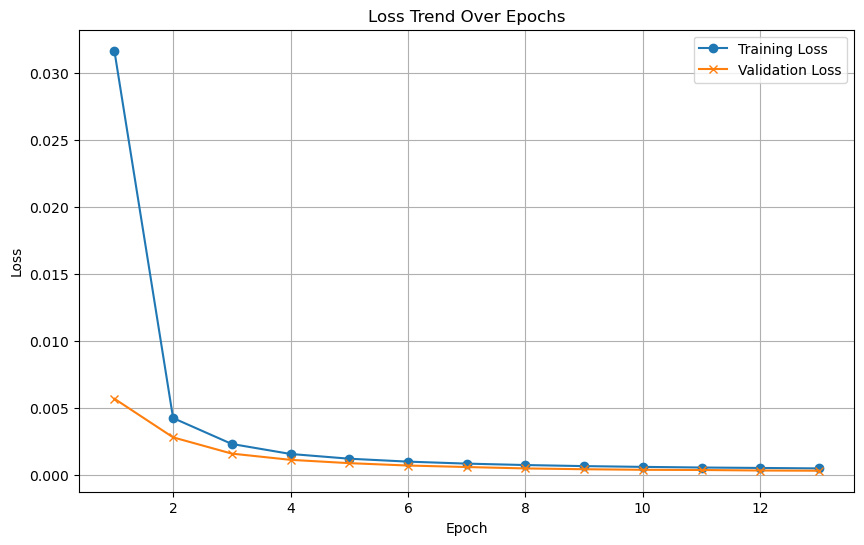

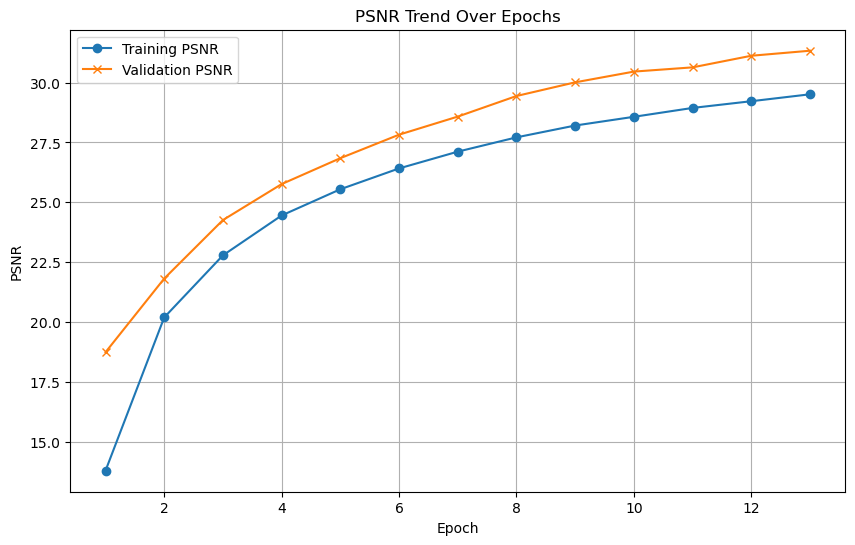

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/579 for test dataset.


    Processed batch 101/579 for test dataset.


    Processed batch 201/579 for test dataset.


    Processed batch 301/579 for test dataset.


    Processed batch 401/579 for test dataset.


    Processed batch 501/579 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2001
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2033. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1293
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0762
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0625
    Validation Batch [1/1], Loss: 2.2033
Validation Loss: 2.2033, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Averag

Epoch [7/1000] completed, Average Training Loss: 1.9730
    Validation Batch [1/1], Loss: 2.2035
Validation Loss: 2.2035, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 1.9626
    Validation Batch [1/1], Loss: 2.2036
Validation Loss: 2.2036, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 1.9446
    Validation Batch [1/1], Loss: 2.2037
Validation Loss: 2.2037, Validation Accuracy: 15.56%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 1.9219
    Validation Batch [1/1], Loss: 2.2038
Validation Loss: 2.2038, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 1.9135
    Validation B

    Validation Batch [1/1], Loss: 2.1683
Validation Loss: 2.1683, Validation Accuracy: 11.11%
Validation loss improved from 2.1806 to 2.1683. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.5703
    Validation Batch [1/1], Loss: 2.1539
Validation Loss: 2.1539, Validation Accuracy: 13.33%
Validation loss improved from 2.1683 to 2.1539. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.5369
    Validation Batch [1/1], Loss: 2.1379
Validation Loss: 2.1379, Validation Accuracy: 15.56%
Validation loss improved from 2.1539 to 2.1379. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.5326
    Validation Batch [1/1], Loss: 2.1193
Validation Loss: 2.1193, Validation Accuracy: 15.56%
Validation loss improved from 2.1379 to 2.1193. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.5255
    Vali

    Validation Batch [1/1], Loss: 1.5114
Validation Loss: 1.5114, Validation Accuracy: 46.67%
Validation loss improved from 1.5341 to 1.5114. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.3309
    Validation Batch [1/1], Loss: 1.4907
Validation Loss: 1.4907, Validation Accuracy: 51.11%
Validation loss improved from 1.5114 to 1.4907. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.3155
    Validation Batch [1/1], Loss: 1.4766
Validation Loss: 1.4766, Validation Accuracy: 53.33%
Validation loss improved from 1.4907 to 1.4766. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.3146
    Validation Batch [1/1], Loss: 1.4642
Validation Loss: 1.4642, Validation Accuracy: 51.11%
Validation loss improved from 1.4766 to 1.4642. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.3190
    Vali

Epoch [97/1000] completed, Average Training Loss: 1.1051
    Validation Batch [1/1], Loss: 1.1987
Validation Loss: 1.1987, Validation Accuracy: 71.11%
Validation loss improved from 1.2075 to 1.1987. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.0942
    Validation Batch [1/1], Loss: 1.1953
Validation Loss: 1.1953, Validation Accuracy: 68.89%
Validation loss improved from 1.1987 to 1.1953. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.0947
    Validation Batch [1/1], Loss: 1.1942
Validation Loss: 1.1942, Validation Accuracy: 71.11%
Validation loss improved from 1.1953 to 1.1942. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.0426
    Validation Batch [1/1], Loss: 1.1889
Validation Loss: 1.1889, Validation Accuracy: 71.11%
Validation loss improved from 1.1942 to 1.1889. Saving model...

LOG: Epoch [101/1000] - Training
Epoch

Epoch [125/1000] completed, Average Training Loss: 0.8692
    Validation Batch [1/1], Loss: 1.0219
Validation Loss: 1.0219, Validation Accuracy: 86.67%
Validation loss improved from 1.0267 to 1.0219. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.8887
    Validation Batch [1/1], Loss: 1.0104
Validation Loss: 1.0104, Validation Accuracy: 86.67%
Validation loss improved from 1.0219 to 1.0104. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 0.8888
    Validation Batch [1/1], Loss: 1.0032
Validation Loss: 1.0032, Validation Accuracy: 86.67%
Validation loss improved from 1.0104 to 1.0032. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 0.8508
    Validation Batch [1/1], Loss: 0.9981
Validation Loss: 0.9981, Validation Accuracy: 86.67%
Validation loss improved from 1.0032 to 0.9981. Saving model...

LOG: Epoch [129/1000] - Training


    Validation Batch [1/1], Loss: 0.8277
Validation Loss: 0.8277, Validation Accuracy: 91.11%
Validation loss improved from 0.8389 to 0.8277. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 0.7070
    Validation Batch [1/1], Loss: 0.8242
Validation Loss: 0.8242, Validation Accuracy: 88.89%
Validation loss improved from 0.8277 to 0.8242. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.6911
    Validation Batch [1/1], Loss: 0.8219
Validation Loss: 0.8219, Validation Accuracy: 86.67%
Validation loss improved from 0.8242 to 0.8219. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.6716
    Validation Batch [1/1], Loss: 0.8094
Validation Loss: 0.8094, Validation Accuracy: 88.89%
Validation loss improved from 0.8219 to 0.8094. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 0.6408


Epoch [185/1000] completed, Average Training Loss: 0.5236
    Validation Batch [1/1], Loss: 0.6896
Validation Loss: 0.6896, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.5280
    Validation Batch [1/1], Loss: 0.6859
Validation Loss: 0.6859, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.5172
    Validation Batch [1/1], Loss: 0.6685
Validation Loss: 0.6685, Validation Accuracy: 91.11%
Validation loss improved from 0.6849 to 0.6685. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.5270
    Validation Batch [1/1], Loss: 0.6515
Validation Loss: 0.6515, Validation Accuracy: 93.33%
Validation loss improved from 0.6685 to 0.6515. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Av

Epoch [217/1000] completed, Average Training Loss: 0.3987
    Validation Batch [1/1], Loss: 0.5517
Validation Loss: 0.5517, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.3161
    Validation Batch [1/1], Loss: 0.5485
Validation Loss: 0.5485, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.3697
    Validation Batch [1/1], Loss: 0.5431
Validation Loss: 0.5431, Validation Accuracy: 88.89%
Validation loss improved from 0.5442 to 0.5431. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.3982
    Validation Batch [1/1], Loss: 0.5330
Validation Loss: 0.5330, Validation Accuracy: 91.11%
Validation loss improved from 0.5431 to 0.5330. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Av

Epoch [247/1000] completed, Average Training Loss: 0.2840
    Validation Batch [1/1], Loss: 0.4301
Validation Loss: 0.4301, Validation Accuracy: 93.33%
Validation loss improved from 0.4423 to 0.4301. Saving model...

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.2657
    Validation Batch [1/1], Loss: 0.4169
Validation Loss: 0.4169, Validation Accuracy: 93.33%
Validation loss improved from 0.4301 to 0.4169. Saving model...

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.2745
    Validation Batch [1/1], Loss: 0.4191
Validation Loss: 0.4191, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.2601
    Validation Batch [1/1], Loss: 0.4460
Validation Loss: 0.4460, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Av

Epoch [278/1000] completed, Average Training Loss: 0.1975
    Validation Batch [1/1], Loss: 0.3621
Validation Loss: 0.3621, Validation Accuracy: 93.33%
Validation loss improved from 0.3729 to 0.3621. Saving model...

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.2078
    Validation Batch [1/1], Loss: 0.3558
Validation Loss: 0.3558, Validation Accuracy: 93.33%
Validation loss improved from 0.3621 to 0.3558. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.2093
    Validation Batch [1/1], Loss: 0.3586
Validation Loss: 0.3586, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.1952
    Validation Batch [1/1], Loss: 0.3606
Validation Loss: 0.3606, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Av

Epoch [307/1000] completed, Average Training Loss: 0.1638
    Validation Batch [1/1], Loss: 0.3097
Validation Loss: 0.3097, Validation Accuracy: 93.33%
Validation loss improved from 0.3244 to 0.3097. Saving model...

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.1433
    Validation Batch [1/1], Loss: 0.3020
Validation Loss: 0.3020, Validation Accuracy: 95.56%
Validation loss improved from 0.3097 to 0.3020. Saving model...

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.1569
    Validation Batch [1/1], Loss: 0.3080
Validation Loss: 0.3080, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.1547
    Validation Batch [1/1], Loss: 0.3255
Validation Loss: 0.3255, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Av

Epoch [336/1000] completed, Average Training Loss: 0.1100
    Validation Batch [1/1], Loss: 0.2776
Validation Loss: 0.2776, Validation Accuracy: 93.33%
Validation loss improved from 0.2886 to 0.2776. Saving model...

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.1368
    Validation Batch [1/1], Loss: 0.2806
Validation Loss: 0.2806, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.1086
    Validation Batch [1/1], Loss: 0.2953
Validation Loss: 0.2953, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.1063
    Validation Batch [1/1], Loss: 0.3031
Validation Loss: 0.3031, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2945
Validation Loss: 0.2945, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.0964
    Validation Batch [1/1], Loss: 0.3075
Validation Loss: 0.3075, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0872
    Validation Batch [1/1], Loss: 0.2982
Validation Loss: 0.2982, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.0913
    Validation Batch [1/1], Loss: 0.2904
Validation Loss: 0.2904, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.0842
    Validation Batch [1/1], Loss: 0.2814
Validation Loss

Epoch [397/1000] completed, Average Training Loss: 0.0864
    Validation Batch [1/1], Loss: 0.2927
Validation Loss: 0.2927, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0765
    Validation Batch [1/1], Loss: 0.2659
Validation Loss: 0.2659, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0834
    Validation Batch [1/1], Loss: 0.2536
Validation Loss: 0.2536, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0952
    Validation Batch [1/1], Loss: 0.2506
Validation Loss: 0.2506, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.061

Epoch [427/1000] completed, Average Training Loss: 0.0580
    Validation Batch [1/1], Loss: 0.2386
Validation Loss: 0.2386, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.0646
    Validation Batch [1/1], Loss: 0.2465
Validation Loss: 0.2465, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.0595
    Validation Batch [1/1], Loss: 0.2556
Validation Loss: 0.2556, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.2608
Validation Loss: 0.2608, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.0532

Epoch [458/1000] completed, Average Training Loss: 0.0572
    Validation Batch [1/1], Loss: 0.2145
Validation Loss: 0.2145, Validation Accuracy: 95.56%
Validation loss improved from 0.2151 to 0.2145. Saving model...

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0491
    Validation Batch [1/1], Loss: 0.2178
Validation Loss: 0.2178, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.0574
    Validation Batch [1/1], Loss: 0.2277
Validation Loss: 0.2277, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.0507
    Validation Batch [1/1], Loss: 0.2397
Validation Loss: 0.2397, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2484
Validation Loss: 0.2484, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.0453
    Validation Batch [1/1], Loss: 0.2386
Validation Loss: 0.2386, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [489/1000] - Training
Epoch [489/1000] completed, Average Training Loss: 0.0450
    Validation Batch [1/1], Loss: 0.2301
Validation Loss: 0.2301, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.0502
    Validation Batch [1/1], Loss: 0.2248
Validation Loss: 0.2248, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.0566
    Validation Batch [1/1], Loss: 0.2217
Validation Loss

    Validation Batch [1/1], Loss: 0.2233
Validation Loss: 0.2233, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.0405
    Validation Batch [1/1], Loss: 0.2434
Validation Loss: 0.2434, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.0384
    Validation Batch [1/1], Loss: 0.2602
Validation Loss: 0.2602, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0376
    Validation Batch [1/1], Loss: 0.2647
Validation Loss: 0.2647, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0329
    Validation Batch [1/1], Loss: 0.2575
Validation Loss: 0.

Epoch [548/1000] completed, Average Training Loss: 0.0299
    Validation Batch [1/1], Loss: 0.2823
Validation Loss: 0.2823, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0356
    Validation Batch [1/1], Loss: 0.2843
Validation Loss: 0.2843, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0298
    Validation Batch [1/1], Loss: 0.2833
Validation Loss: 0.2833, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.2679
Validation Loss: 0.2679, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.044

Epoch [579/1000] completed, Average Training Loss: 0.0340
    Validation Batch [1/1], Loss: 0.2825
Validation Loss: 0.2825, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [580/1000] - Training
Epoch [580/1000] completed, Average Training Loss: 0.0330
    Validation Batch [1/1], Loss: 0.2525
Validation Loss: 0.2525, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0293
    Validation Batch [1/1], Loss: 0.2338
Validation Loss: 0.2338, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0264
    Validation Batch [1/1], Loss: 0.2265
Validation Loss: 0.2265, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.020

Epoch [610/1000] completed, Average Training Loss: 0.0260
    Validation Batch [1/1], Loss: 0.2711
Validation Loss: 0.2711, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [611/1000] - Training
Epoch [611/1000] completed, Average Training Loss: 0.0299
    Validation Batch [1/1], Loss: 0.2687
Validation Loss: 0.2687, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [612/1000] - Training
Epoch [612/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.2629
Validation Loss: 0.2629, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0271
    Validation Batch [1/1], Loss: 0.2411
Validation Loss: 0.2411, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.029

    Validation Batch [1/1], Loss: 0.2126
Validation Loss: 0.2126, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0258
    Validation Batch [1/1], Loss: 0.2114
Validation Loss: 0.2114, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0301
    Validation Batch [1/1], Loss: 0.2134
Validation Loss: 0.2134, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0205
    Validation Batch [1/1], Loss: 0.2175
Validation Loss: 0.2175, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0305
    Validation Batch [1/1], Loss: 0.2265
Validation Loss

Epoch [670/1000] completed, Average Training Loss: 0.0157
    Validation Batch [1/1], Loss: 0.2201
Validation Loss: 0.2201, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.0220
    Validation Batch [1/1], Loss: 0.2297
Validation Loss: 0.2297, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.2307
Validation Loss: 0.2307, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.0236
    Validation Batch [1/1], Loss: 0.2295
Validation Loss: 0.2295, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.025

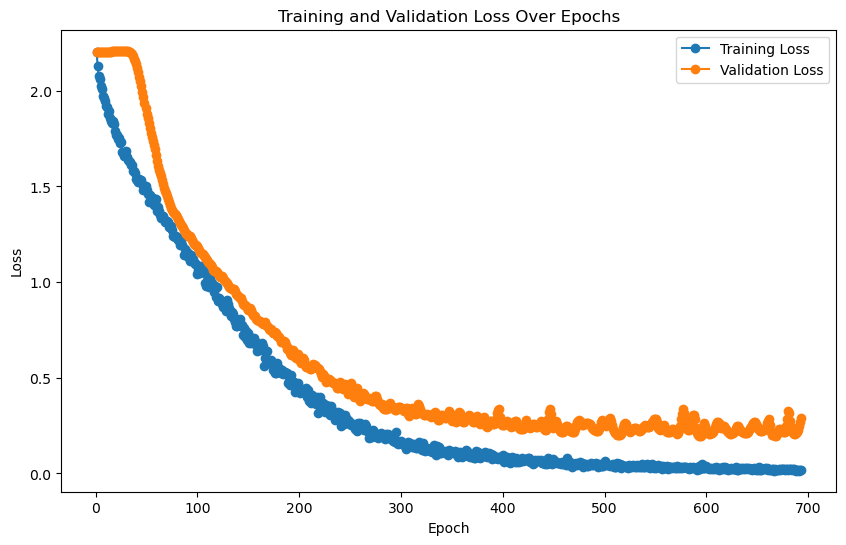

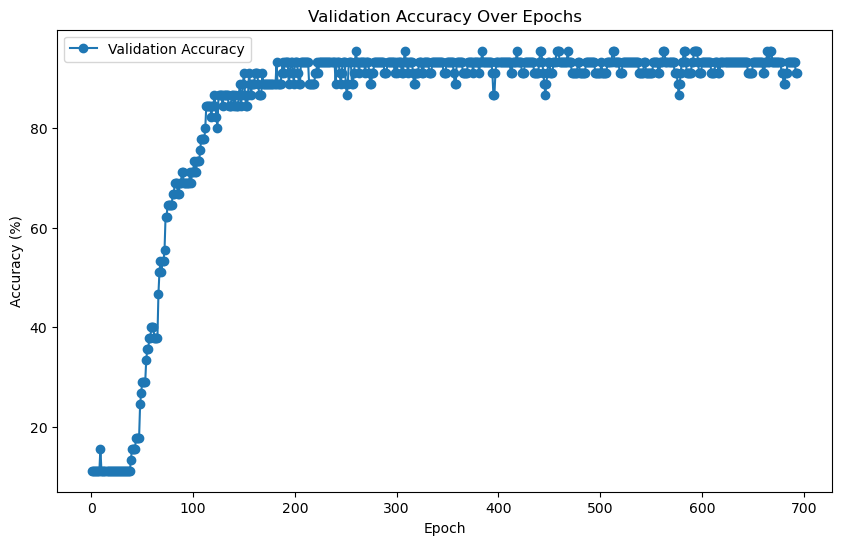


Evaluating on the test set...
    Test Batch [1/579], Loss: 0.0712



Final Test Loss: 0.1180, Test Accuracy: 97.08%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.
  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.


  Processed batch 40/579 for test dataset.


  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.
  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.


  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.
  Processed batch 130/579 for test dataset.


  Processed batch 140/579 for test dataset.


  Processed batch 150/579 for test dataset.
  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.


  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.
  Processed batch 230/579 for test dataset.


  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.
  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.


  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.
  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.


  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.
  Processed batch 410/579 for test dataset.
  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.


  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.
  Processed batch 480/579 for test dataset.


  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.


  Processed batch 540/579 for test dataset.
  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)

LOG: Training features shape: (90, 64), Training labels shape: (90,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (148017, 64), Test labels shape: (148017,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 91.11%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       1.00      0.60      0.75         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       1.00      0.60      0.75         5
           7       1.00      1.00      1.00         5
           8       1.00      

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)
Train reps shape: (90, 64)
Train labels shape: (90,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (148017, 64)
Test labels shape: (148017,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2766  |  Val Loss: 2.0992
Validation loss improved from inf to 2.0992.


[Epoch 2/1000] Train Loss: 2.0878  |  Val Loss: 1.9795
Validation loss improved from 2.0992 to 1.9795.
[Epoch 3/1000] Train Loss: 1.9706  |  Val Loss: 1.8909
Validation loss improved from 1.9795 to 1.8909.
[Epoch 4/1000] Train Loss: 1.8715  |  Val Loss: 1.8244
Validation loss improved from 1.8909 to 1.8244.
[Epoch 5/1000] Train Loss: 1.7966  |  Val Loss: 1.7671
Validation loss improved from 1.8244 to 1.7671.
[Epoch 6/1000] Train Loss: 1.7296  |  Val Loss: 1.7107
Validation loss improved from 1.7671 to 1.7107.
[Epoch 7/1000] Train Loss: 1.6674  |  Val Loss: 1.6606
Validation loss improved from 1.7107 to 1.6606.
[Epoch 8/1000] Train Loss: 1.6097  |  Val Loss: 1.6137
Validation loss improved from 1.6606 to 1.6137.
[Epoch 9/1000] Train Loss: 1.5585  |  Val Loss: 1.5676
Validation loss improved from 1.6137 to 1.5676.
[Epoch 10/1000] Train Loss: 1.5046  |  Val Loss: 1.5185
Validation loss improved from 1.5676 to 1.5185.
[Epoch 11/1000] Train Loss: 1.4515  |  Val Loss: 1.4709
Validation loss 

[Epoch 44/1000] Train Loss: 0.3578  |  Val Loss: 0.5569
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 45/1000] Train Loss: 0.3465  |  Val Loss: 0.5396
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 46/1000] Train Loss: 0.3307  |  Val Loss: 0.5100
Validation loss improved from 0.5257 to 0.5100.
[Epoch 47/1000] Train Loss: 0.3159  |  Val Loss: 0.4860
Validation loss improved from 0.5100 to 0.4860.
[Epoch 48/1000] Train Loss: 0.3050  |  Val Loss: 0.4679
Validation loss improved from 0.4860 to 0.4679.
[Epoch 49/1000] Train Loss: 0.2964  |  Val Loss: 0.4624
Validation loss improved from 0.4679 to 0.4624.
[Epoch 50/1000] Train Loss: 0.2861  |  Val Loss: 0.4697
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.2765  |  Val Loss: 0.4834
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 52/1000] Train Loss: 0.2693  |  Val Loss: 0.4705
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 53/1000] Train Loss: 0.2583

[Epoch 88/1000] Train Loss: 0.0945  |  Val Loss: 0.3977
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 89/1000] Train Loss: 0.0907  |  Val Loss: 0.4117
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 90/1000] Train Loss: 0.0896  |  Val Loss: 0.4091
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 91/1000] Train Loss: 0.0851  |  Val Loss: 0.4179
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 92/1000] Train Loss: 0.0842  |  Val Loss: 0.4191
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 93/1000] Train Loss: 0.0821  |  Val Loss: 0.4002
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 94/1000] Train Loss: 0.0797  |  Val Loss: 0.3767
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 95/1000] Train Loss: 0.0800  |  Val Loss: 0.3739
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 96/1000] Train Loss: 0.0788  |  Val Loss: 0.3853
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 97

[Epoch 134/1000] Train Loss: 0.0492  |  Val Loss: 0.4725
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 135/1000] Train Loss: 0.0398  |  Val Loss: 0.5398
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 136/1000] Train Loss: 0.0494  |  Val Loss: 0.5247
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 137/1000] Train Loss: 0.0429  |  Val Loss: 0.4546
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 138/1000] Train Loss: 0.0387  |  Val Loss: 0.4103
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 139/1000] Train Loss: 0.0470  |  Val Loss: 0.4224
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 140/1000] Train Loss: 0.0365  |  Val Loss: 0.5044
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 141/1000] Train Loss: 0.0479  |  Val Loss: 0.5509
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 142/1000] Train Loss: 0.0461  |  Val Loss: 0.4784
!! Validation loss did NOT improve !! Patience:

[Epoch 179/1000] Train Loss: 0.0251  |  Val Loss: 0.4738
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 180/1000] Train Loss: 0.0280  |  Val Loss: 0.4787
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 181/1000] Train Loss: 0.0266  |  Val Loss: 0.5094
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 182/1000] Train Loss: 0.0231  |  Val Loss: 0.5466
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 183/1000] Train Loss: 0.0224  |  Val Loss: 0.5741
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 184/1000] Train Loss: 0.0239  |  Val Loss: 0.5770
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 185/1000] Train Loss: 0.0228  |  Val Loss: 0.5504
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 186/1000] Train Loss: 0.0205  |  Val Loss: 0.5144
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 186 !!
No improvement for 100 epochs.


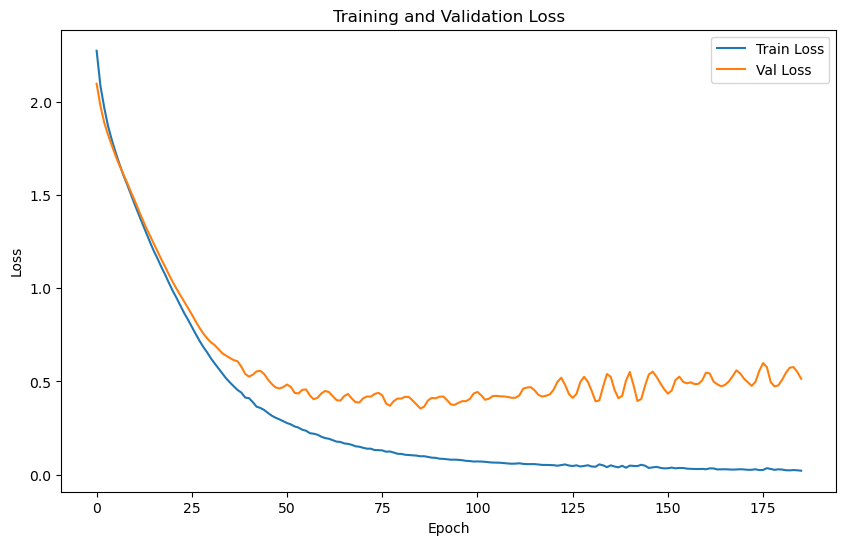

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.2624 | Test Accuracy: 92.74%


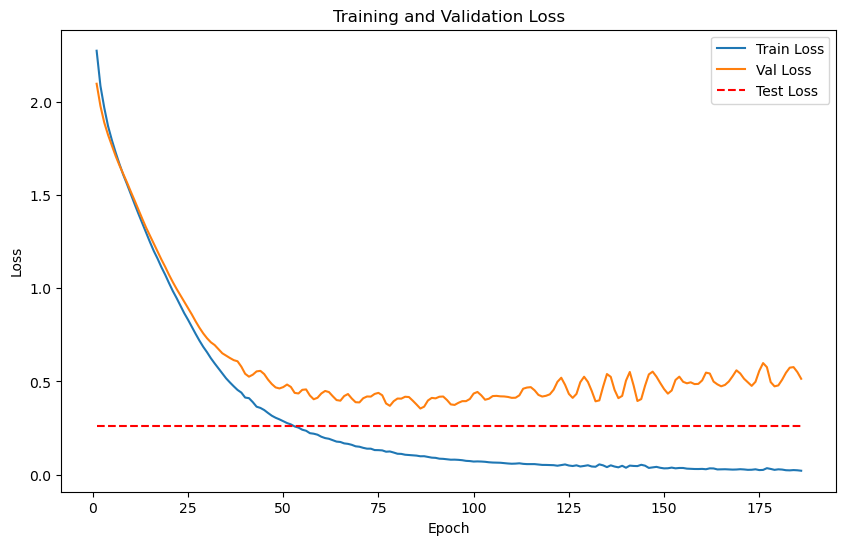

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148017, 64), 
Test labels shape: (148017,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.3610
Epoch [1/2000], Avg Train Loss: 8.3610
Epoch [1/2000], Avg Val Loss: 3.5794
Validation loss improved from inf to 3.5794. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.3495
Epoch [2/2000], Avg Train Loss: 8.3495
Epoch [2/2000], Avg Val Loss: 3.5434
Validation loss improved from 3.5794 to 3.5434. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.2452
Epoch [3/2000], Avg Train Loss: 8.2452
Epoch [3/2000], Avg Val Loss: 3.5087
Validation loss improved from 3.5434 to 3.5087. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.2603
Epoch [4/2000], Avg Train Loss: 8.2603
Epoch [4/2000], Avg Val Loss: 3.4751
Validation loss improved from 3.5087 to 3.4751. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.4478
Epoch [5/2000], Avg Train Loss: 8.4478
Epoch [5/2000], Avg Val Loss: 3.4428
Validation loss improved from 3.4751 to 3.4428. Saving mode

Epoch [9/2000], Avg Val Loss: 3.3237
Validation loss improved from 3.3521 to 3.3237. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 7.8248
Epoch [10/2000], Avg Train Loss: 7.8248
Epoch [10/2000], Avg Val Loss: 3.2960
Validation loss improved from 3.3237 to 3.2960. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 7.5129
Epoch [11/2000], Avg Train Loss: 7.5129
Epoch [11/2000], Avg Val Loss: 3.2692
Validation loss improved from 3.2960 to 3.2692. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 7.5248
Epoch [12/2000], Avg Train Loss: 7.5248
Epoch [12/2000], Avg Val Loss: 3.2432
Validation loss improved from 3.2692 to 3.2432. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.3861
Epoch [13/2000], Avg Train Loss: 7.3861
Epoch [13/2000], Avg Val Loss: 3.2181
Validation loss improved from 3.2432 to 3.2181. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train

    Batch [1/1], Train Loss: 5.7234
Epoch [46/2000], Avg Train Loss: 5.7234
Epoch [46/2000], Avg Val Loss: 2.7495
Validation loss improved from 2.7564 to 2.7495. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.4361
Epoch [47/2000], Avg Train Loss: 5.4361
Epoch [47/2000], Avg Val Loss: 2.7428
Validation loss improved from 2.7495 to 2.7428. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.4475
Epoch [48/2000], Avg Train Loss: 5.4475
Epoch [48/2000], Avg Val Loss: 2.7363
Validation loss improved from 2.7428 to 2.7363. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.4139
Epoch [49/2000], Avg Train Loss: 5.4139
Epoch [49/2000], Avg Val Loss: 2.7301
Validation loss improved from 2.7363 to 2.7301. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.2261
Epoch [50/2000], Avg Train Loss: 5.2261
Epoch [50/2000], Avg Val Loss: 2.7243
Validation loss improved from 2.7301 to 2.

Epoch [54/2000], Avg Val Loss: 2.7032
Validation loss improved from 2.7081 to 2.7032. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.2517
Epoch [55/2000], Avg Train Loss: 5.2517
Epoch [55/2000], Avg Val Loss: 2.6986
Validation loss improved from 2.7032 to 2.6986. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.3166
Epoch [56/2000], Avg Train Loss: 5.3166
Epoch [56/2000], Avg Val Loss: 2.6941
Validation loss improved from 2.6986 to 2.6941. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.3111
Epoch [57/2000], Avg Train Loss: 5.3111
Epoch [57/2000], Avg Val Loss: 2.6898
Validation loss improved from 2.6941 to 2.6898. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.1305
Epoch [58/2000], Avg Train Loss: 5.1305
Epoch [58/2000], Avg Val Loss: 2.6857
Validation loss improved from 2.6898 to 2.6857. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Trai

Epoch [92/2000], Avg Val Loss: 2.6133
Validation loss improved from 2.6143 to 2.6133. Saving model...

LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 4.4898
Epoch [93/2000], Avg Train Loss: 4.4898
Epoch [93/2000], Avg Val Loss: 2.6123
Validation loss improved from 2.6133 to 2.6123. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.3080
Epoch [94/2000], Avg Train Loss: 4.3080
Epoch [94/2000], Avg Val Loss: 2.6114
Validation loss improved from 2.6123 to 2.6114. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.4787
Epoch [95/2000], Avg Train Loss: 4.4787
Epoch [95/2000], Avg Val Loss: 2.6105
Validation loss improved from 2.6114 to 2.6105. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.3356
Epoch [96/2000], Avg Train Loss: 4.3356
Epoch [96/2000], Avg Val Loss: 2.6096
Validation loss improved from 2.6105 to 2.6096. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.4357
Epoch [97/2000], Avg Train Loss: 4.4357
Epoch [97/2000], Avg Val Loss: 2.6088
Validation loss improved from 2.6096 to 2.

    Batch [1/1], Train Loss: 3.9458


Epoch [141/2000], Avg Train Loss: 3.9458
Epoch [141/2000], Avg Val Loss: 2.5833
Validation loss improved from 2.5838 to 2.5833. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 3.9052
Epoch [142/2000], Avg Train Loss: 3.9052
Epoch [142/2000], Avg Val Loss: 2.5828
Validation loss improved from 2.5833 to 2.5828. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 3.8494
Epoch [143/2000], Avg Train Loss: 3.8494
Epoch [143/2000], Avg Val Loss: 2.5823
Validation loss improved from 2.5828 to 2.5823. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 3.9802
Epoch [144/2000], Avg Train Loss: 3.9802
Epoch [144/2000], Avg Val Loss: 2.5817
Validation loss improved from 2.5823 to 2.5817. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.0573
Epoch [145/2000], Avg Train Loss: 4.0573
Epoch [145/2000], Avg Val Loss: 2.5812
Validation loss improved from 2.5817 to 2.5812. Saving model...

Epoch [188/2000], Avg Val Loss: 2.5564
Validation loss improved from 2.5571 to 2.5564. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 3.7013
Epoch [189/2000], Avg Train Loss: 3.7013
Epoch [189/2000], Avg Val Loss: 2.5557
Validation loss improved from 2.5564 to 2.5557. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 3.7614
Epoch [190/2000], Avg Train Loss: 3.7614
Epoch [190/2000], Avg Val Loss: 2.5551
Validation loss improved from 2.5557 to 2.5551. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 3.8182
Epoch [191/2000], Avg Train Loss: 3.8182
Epoch [191/2000], Avg Val Loss: 2.5544
Validation loss improved from 2.5551 to 2.5544. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 3.7480
Epoch [192/2000], Avg Train Loss: 3.7480
Epoch [192/2000], Avg Val Loss: 2.5538
Validation loss improved from 2.5544 to 2.5538. Saving model...

LOG: Epoch [193/2000] - Training
    Bat

Epoch [237/2000], Avg Val Loss: 2.5249
Validation loss improved from 2.5256 to 2.5249. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 3.5969
Epoch [238/2000], Avg Train Loss: 3.5969
Epoch [238/2000], Avg Val Loss: 2.5242
Validation loss improved from 2.5249 to 2.5242. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 3.6313
Epoch [239/2000], Avg Train Loss: 3.6313
Epoch [239/2000], Avg Val Loss: 2.5236
Validation loss improved from 2.5242 to 2.5236. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 3.5614
Epoch [240/2000], Avg Train Loss: 3.5614
Epoch [240/2000], Avg Val Loss: 2.5230
Validation loss improved from 2.5236 to 2.5230. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 3.5758
Epoch [241/2000], Avg Train Loss: 3.5758
Epoch [241/2000], Avg Val Loss: 2.5223
Validation loss improved from 2.5230 to 2.5223. Saving model...

LOG: Epoch [242/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4891
Epoch [286/2000], Avg Train Loss: 3.4891
Epoch [286/2000], Avg Val Loss: 2.4925
Validation loss improved from 2.4931 to 2.4925. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 3.4438
Epoch [287/2000], Avg Train Loss: 3.4438
Epoch [287/2000], Avg Val Loss: 2.4919
Validation loss improved from 2.4925 to 2.4919. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 3.4791
Epoch [288/2000], Avg Train Loss: 3.4791
Epoch [288/2000], Avg Val Loss: 2.4913
Validation loss improved from 2.4919 to 2.4913. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 3.4657
Epoch [289/2000], Avg Train Loss: 3.4657
Epoch [289/2000], Avg Val Loss: 2.4907
Validation loss improved from 2.4913 to 2.4907. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 3.4535
Epoch [290/2000], Avg Train Loss: 3.4535
Epoch [290/2000], Avg Val Loss: 2.4901
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4179
Epoch [335/2000], Avg Train Loss: 3.4179
Epoch [335/2000], Avg Val Loss: 2.4650
Validation loss improved from 2.4656 to 2.4650. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 3.4404
Epoch [336/2000], Avg Train Loss: 3.4404
Epoch [336/2000], Avg Val Loss: 2.4645
Validation loss improved from 2.4650 to 2.4645. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 3.4228
Epoch [337/2000], Avg Train Loss: 3.4228
Epoch [337/2000], Avg Val Loss: 2.4640
Validation loss improved from 2.4645 to 2.4640. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 3.3968
Epoch [338/2000], Avg Train Loss: 3.3968
Epoch [338/2000], Avg Val Loss: 2.4634
Validation loss improved from 2.4640 to 2.4634. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 3.4618
Epoch [339/2000], Avg Train Loss: 3.4618
Epoch [339/2000], Avg Val Loss: 2.4629
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3482
Epoch [381/2000], Avg Train Loss: 3.3482
Epoch [381/2000], Avg Val Loss: 2.4397
Validation loss improved from 2.4402 to 2.4397. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 3.3565
Epoch [382/2000], Avg Train Loss: 3.3565
Epoch [382/2000], Avg Val Loss: 2.4391
Validation loss improved from 2.4397 to 2.4391. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 3.3673
Epoch [383/2000], Avg Train Loss: 3.3673
Epoch [383/2000], Avg Val Loss: 2.4386
Validation loss improved from 2.4391 to 2.4386. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 3.3312
Epoch [384/2000], Avg Train Loss: 3.3312
Epoch [384/2000], Avg Val Loss: 2.4381
Validation loss improved from 2.4386 to 2.4381. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 3.3681
Epoch [385/2000], Avg Train Loss: 3.3681
Epoch [385/2000], Avg Val Loss: 2.4375
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2947
Epoch [429/2000], Avg Train Loss: 3.2947
Epoch [429/2000], Avg Val Loss: 2.4177
Validation loss improved from 2.4182 to 2.4177. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 3.2783
Epoch [430/2000], Avg Train Loss: 3.2783
Epoch [430/2000], Avg Val Loss: 2.4173
Validation loss improved from 2.4177 to 2.4173. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 3.2873
Epoch [431/2000], Avg Train Loss: 3.2873
Epoch [431/2000], Avg Val Loss: 2.4168
Validation loss improved from 2.4173 to 2.4168. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 3.3380
Epoch [432/2000], Avg Train Loss: 3.3380
Epoch [432/2000], Avg Val Loss: 2.4164
Validation loss improved from 2.4168 to 2.4164. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 3.3220
Epoch [433/2000], Avg Train Loss: 3.3220
Epoch [433/2000], Avg Val Loss: 2.4159
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2689
Epoch [479/2000], Avg Train Loss: 3.2689
Epoch [479/2000], Avg Val Loss: 2.3962
Validation loss improved from 2.3966 to 2.3962. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 3.2576
Epoch [480/2000], Avg Train Loss: 3.2576
Epoch [480/2000], Avg Val Loss: 2.3958
Validation loss improved from 2.3962 to 2.3958. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 3.2729
Epoch [481/2000], Avg Train Loss: 3.2729
Epoch [481/2000], Avg Val Loss: 2.3954
Validation loss improved from 2.3958 to 2.3954. Saving model...

LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 3.2470
Epoch [482/2000], Avg Train Loss: 3.2470
Epoch [482/2000], Avg Val Loss: 2.3951
Validation loss improved from 2.3954 to 2.3951. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 3.2526
Epoch [483/2000], Avg Train Loss: 3.2526
Epoch [483/2000], Avg Val Loss: 2.3947
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1351
Epoch [527/2000], Avg Train Loss: 3.1351
Epoch [527/2000], Avg Val Loss: 2.3782
Validation loss improved from 2.3786 to 2.3782. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 3.2531
Epoch [528/2000], Avg Train Loss: 3.2531
Epoch [528/2000], Avg Val Loss: 2.3778
Validation loss improved from 2.3782 to 2.3778. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 3.1777
Epoch [529/2000], Avg Train Loss: 3.1777
Epoch [529/2000], Avg Val Loss: 2.3775
Validation loss improved from 2.3778 to 2.3775. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 3.2009
Epoch [530/2000], Avg Train Loss: 3.2009
Epoch [530/2000], Avg Val Loss: 2.3772
Validation loss improved from 2.3775 to 2.3772. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 3.2170
Epoch [531/2000], Avg Train Loss: 3.2170
Epoch [531/2000], Avg Val Loss: 2.3769
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1288
Epoch [574/2000], Avg Train Loss: 3.1288
Epoch [574/2000], Avg Val Loss: 2.3623
Validation loss improved from 2.3627 to 2.3623. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 3.1424
Epoch [575/2000], Avg Train Loss: 3.1424
Epoch [575/2000], Avg Val Loss: 2.3619
Validation loss improved from 2.3623 to 2.3619. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 3.1665
Epoch [576/2000], Avg Train Loss: 3.1665
Epoch [576/2000], Avg Val Loss: 2.3616
Validation loss improved from 2.3619 to 2.3616. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 3.1599
Epoch [577/2000], Avg Train Loss: 3.1599
Epoch [577/2000], Avg Val Loss: 2.3612
Validation loss improved from 2.3616 to 2.3612. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 3.1880
Epoch [578/2000], Avg Train Loss: 3.1880
Epoch [578/2000], Avg Val Loss: 2.3607
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1327
Epoch [621/2000], Avg Train Loss: 3.1327
Epoch [621/2000], Avg Val Loss: 2.3463
Validation loss improved from 2.3467 to 2.3463. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 3.0781
Epoch [622/2000], Avg Train Loss: 3.0781
Epoch [622/2000], Avg Val Loss: 2.3460
Validation loss improved from 2.3463 to 2.3460. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 3.1426
Epoch [623/2000], Avg Train Loss: 3.1426
Epoch [623/2000], Avg Val Loss: 2.3456
Validation loss improved from 2.3460 to 2.3456. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 3.1346
Epoch [624/2000], Avg Train Loss: 3.1346
Epoch [624/2000], Avg Val Loss: 2.3453
Validation loss improved from 2.3456 to 2.3453. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 3.1455
Epoch [625/2000], Avg Train Loss: 3.1455
Epoch [625/2000], Avg Val Loss: 2.3450
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0837
Epoch [666/2000], Avg Train Loss: 3.0837
Epoch [666/2000], Avg Val Loss: 2.3325
Validation loss improved from 2.3328 to 2.3325. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 3.0643
Epoch [667/2000], Avg Train Loss: 3.0643
Epoch [667/2000], Avg Val Loss: 2.3322
Validation loss improved from 2.3325 to 2.3322. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 3.0846
Epoch [668/2000], Avg Train Loss: 3.0846
Epoch [668/2000], Avg Val Loss: 2.3320
Validation loss improved from 2.3322 to 2.3320. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 3.0948
Epoch [669/2000], Avg Train Loss: 3.0948
Epoch [669/2000], Avg Val Loss: 2.3317
Validation loss improved from 2.3320 to 2.3317. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 3.1416
Epoch [670/2000], Avg Train Loss: 3.1416
Epoch [670/2000], Avg Val Loss: 2.3314
Validation loss improved fro

Epoch [712/2000], Avg Val Loss: 2.3172
Validation loss improved from 2.3176 to 2.3172. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 3.0433
Epoch [713/2000], Avg Train Loss: 3.0433
Epoch [713/2000], Avg Val Loss: 2.3169
Validation loss improved from 2.3172 to 2.3169. Saving model...

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 3.0567
Epoch [714/2000], Avg Train Loss: 3.0567
Epoch [714/2000], Avg Val Loss: 2.3166
Validation loss improved from 2.3169 to 2.3166. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 3.0956
Epoch [715/2000], Avg Train Loss: 3.0956
Epoch [715/2000], Avg Val Loss: 2.3162
Validation loss improved from 2.3166 to 2.3162. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 3.0191
Epoch [716/2000], Avg Train Loss: 3.0191
Epoch [716/2000], Avg Val Loss: 2.3159
Validation loss improved from 2.3162 to 2.3159. Saving model...

LOG: Epoch [717/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9744
Epoch [758/2000], Avg Train Loss: 2.9744
Epoch [758/2000], Avg Val Loss: 2.3021
Validation loss improved from 2.3024 to 2.3021. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 3.0434
Epoch [759/2000], Avg Train Loss: 3.0434
Epoch [759/2000], Avg Val Loss: 2.3018
Validation loss improved from 2.3021 to 2.3018. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 3.0446
Epoch [760/2000], Avg Train Loss: 3.0446
Epoch [760/2000], Avg Val Loss: 2.3015
Validation loss improved from 2.3018 to 2.3015. Saving model...

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 3.0489
Epoch [761/2000], Avg Train Loss: 3.0489
Epoch [761/2000], Avg Val Loss: 2.3012
Validation loss improved from 2.3015 to 2.3012. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 3.0231
Epoch [762/2000], Avg Train Loss: 3.0231
Epoch [762/2000], Avg Val Loss: 2.3009
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9862
Epoch [805/2000], Avg Train Loss: 2.9862
Epoch [805/2000], Avg Val Loss: 2.2873
Validation loss improved from 2.2876 to 2.2873. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 2.9795
Epoch [806/2000], Avg Train Loss: 2.9795
Epoch [806/2000], Avg Val Loss: 2.2870
Validation loss improved from 2.2873 to 2.2870. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 2.9706
Epoch [807/2000], Avg Train Loss: 2.9706
Epoch [807/2000], Avg Val Loss: 2.2867
Validation loss improved from 2.2870 to 2.2867. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 2.9877
Epoch [808/2000], Avg Train Loss: 2.9877
Epoch [808/2000], Avg Val Loss: 2.2865
Validation loss improved from 2.2867 to 2.2865. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 2.9549
Epoch [809/2000], Avg Train Loss: 2.9549
Epoch [809/2000], Avg Val Loss: 2.2862
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9894
Epoch [849/2000], Avg Train Loss: 2.9894
Epoch [849/2000], Avg Val Loss: 2.2754
Validation loss improved from 2.2756 to 2.2754. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 2.9579
Epoch [850/2000], Avg Train Loss: 2.9579
Epoch [850/2000], Avg Val Loss: 2.2752
Validation loss improved from 2.2754 to 2.2752. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 2.9990
Epoch [851/2000], Avg Train Loss: 2.9990
Epoch [851/2000], Avg Val Loss: 2.2749
Validation loss improved from 2.2752 to 2.2749. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 2.9505
Epoch [852/2000], Avg Train Loss: 2.9505
Epoch [852/2000], Avg Val Loss: 2.2746
Validation loss improved from 2.2749 to 2.2746. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 2.9714
Epoch [853/2000], Avg Train Loss: 2.9714
Epoch [853/2000], Avg Val Loss: 2.2742
Validation loss improved fro

Epoch [895/2000], Avg Val Loss: 2.2616
Validation loss improved from 2.2619 to 2.2616. Saving model...

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 2.9612
Epoch [896/2000], Avg Train Loss: 2.9612
Epoch [896/2000], Avg Val Loss: 2.2612
Validation loss improved from 2.2616 to 2.2612. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 2.9260
Epoch [897/2000], Avg Train Loss: 2.9260
Epoch [897/2000], Avg Val Loss: 2.2609
Validation loss improved from 2.2612 to 2.2609. Saving model...

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 2.9968
Epoch [898/2000], Avg Train Loss: 2.9968
Epoch [898/2000], Avg Val Loss: 2.2606
Validation loss improved from 2.2609 to 2.2606. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 2.9560
Epoch [899/2000], Avg Train Loss: 2.9560
Epoch [899/2000], Avg Val Loss: 2.2603
Validation loss improved from 2.2606 to 2.2603. Saving model...

LOG: Epoch [900/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9591
Epoch [940/2000], Avg Train Loss: 2.9591
Epoch [940/2000], Avg Val Loss: 2.2492
Validation loss improved from 2.2494 to 2.2492. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 2.9127
Epoch [941/2000], Avg Train Loss: 2.9127
Epoch [941/2000], Avg Val Loss: 2.2491
Validation loss improved from 2.2492 to 2.2491. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 2.9045
Epoch [942/2000], Avg Train Loss: 2.9045
Epoch [942/2000], Avg Val Loss: 2.2489
Validation loss improved from 2.2491 to 2.2489. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 2.9175
Epoch [943/2000], Avg Train Loss: 2.9175
Epoch [943/2000], Avg Val Loss: 2.2487
Validation loss improved from 2.2489 to 2.2487. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 2.9582
Epoch [944/2000], Avg Train Loss: 2.9582
Epoch [944/2000], Avg Val Loss: 2.2485
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8989
Epoch [987/2000], Avg Train Loss: 2.8989
Epoch [987/2000], Avg Val Loss: 2.2378
Validation loss improved from 2.2381 to 2.2378. Saving model...

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 2.9021
Epoch [988/2000], Avg Train Loss: 2.9021
Epoch [988/2000], Avg Val Loss: 2.2375
Validation loss improved from 2.2378 to 2.2375. Saving model...

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 2.9108
Epoch [989/2000], Avg Train Loss: 2.9108
Epoch [989/2000], Avg Val Loss: 2.2372
Validation loss improved from 2.2375 to 2.2372. Saving model...

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 2.9710
Epoch [990/2000], Avg Train Loss: 2.9710
Epoch [990/2000], Avg Val Loss: 2.2369
Validation loss improved from 2.2372 to 2.2369. Saving model...

LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 2.8656
Epoch [991/2000], Avg Train Loss: 2.8656
Epoch [991/2000], Avg Val Loss: 2.2366
Validation loss improved fro

Epoch [1033/2000], Avg Val Loss: 2.2274
Validation loss improved from 2.2276 to 2.2274. Saving model...

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 2.8950
Epoch [1034/2000], Avg Train Loss: 2.8950
Epoch [1034/2000], Avg Val Loss: 2.2272
Validation loss improved from 2.2274 to 2.2272. Saving model...

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 2.8689
Epoch [1035/2000], Avg Train Loss: 2.8689
Epoch [1035/2000], Avg Val Loss: 2.2269
Validation loss improved from 2.2272 to 2.2269. Saving model...

LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 2.8542
Epoch [1036/2000], Avg Train Loss: 2.8542
Epoch [1036/2000], Avg Val Loss: 2.2266
Validation loss improved from 2.2269 to 2.2266. Saving model...

LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 2.8395
Epoch [1037/2000], Avg Train Loss: 2.8395
Epoch [1037/2000], Avg Val Loss: 2.2263
Validation loss improved from 2.2266 to 2.2263. Saving model...

LOG: Epoch [1038/2000] - Tr

Epoch [1082/2000], Avg Val Loss: 2.2138
Validation loss improved from 2.2141 to 2.2138. Saving model...

LOG: Epoch [1083/2000] - Training
    Batch [1/1], Train Loss: 2.8554
Epoch [1083/2000], Avg Train Loss: 2.8554
Epoch [1083/2000], Avg Val Loss: 2.2136
Validation loss improved from 2.2138 to 2.2136. Saving model...

LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 2.8883
Epoch [1084/2000], Avg Train Loss: 2.8883
Epoch [1084/2000], Avg Val Loss: 2.2134
Validation loss improved from 2.2136 to 2.2134. Saving model...

LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 2.8820
Epoch [1085/2000], Avg Train Loss: 2.8820
Epoch [1085/2000], Avg Val Loss: 2.2131
Validation loss improved from 2.2134 to 2.2131. Saving model...

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 2.8775
Epoch [1086/2000], Avg Train Loss: 2.8775
Epoch [1086/2000], Avg Val Loss: 2.2128
Validation loss improved from 2.2131 to 2.2128. Saving model...

LOG: Epoch [1087/2000] - Tr

Epoch [1127/2000], Avg Val Loss: 2.2056
Validation loss improved from 2.2056 to 2.2056. Saving model...

LOG: Epoch [1128/2000] - Training
    Batch [1/1], Train Loss: 2.8119
Epoch [1128/2000], Avg Train Loss: 2.8119
Epoch [1128/2000], Avg Val Loss: 2.2055
Validation loss improved from 2.2056 to 2.2055. Saving model...

LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 2.8347
Epoch [1129/2000], Avg Train Loss: 2.8347
Epoch [1129/2000], Avg Val Loss: 2.2054
Validation loss improved from 2.2055 to 2.2054. Saving model...

LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 2.8434
Epoch [1130/2000], Avg Train Loss: 2.8434
Epoch [1130/2000], Avg Val Loss: 2.2054
Validation loss improved from 2.2054 to 2.2054. Saving model...

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 2.8496
Epoch [1131/2000], Avg Train Loss: 2.8496
Epoch [1131/2000], Avg Val Loss: 2.2053
Validation loss improved from 2.2054 to 2.2053. Saving model...

LOG: Epoch [1132/2000] - Tr

Epoch [1175/2000], Avg Val Loss: 2.1961
Validation loss improved from 2.1963 to 2.1961. Saving model...

LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 2.8714
Epoch [1176/2000], Avg Train Loss: 2.8714
Epoch [1176/2000], Avg Val Loss: 2.1961
Validation loss improved from 2.1961 to 2.1961. Saving model...

LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 2.8696
Epoch [1177/2000], Avg Train Loss: 2.8696
Epoch [1177/2000], Avg Val Loss: 2.1960
Validation loss improved from 2.1961 to 2.1960. Saving model...

LOG: Epoch [1178/2000] - Training
    Batch [1/1], Train Loss: 2.7887
Epoch [1178/2000], Avg Train Loss: 2.7887
Epoch [1178/2000], Avg Val Loss: 2.1959
Validation loss improved from 2.1960 to 2.1959. Saving model...

LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 2.8405
Epoch [1179/2000], Avg Train Loss: 2.8405
Epoch [1179/2000], Avg Val Loss: 2.1958
Validation loss improved from 2.1959 to 2.1958. Saving model...

LOG: Epoch [1180/2000] - Tr

    Batch [1/1], Train Loss: 2.8134
Epoch [1222/2000], Avg Train Loss: 2.8134
Epoch [1222/2000], Avg Val Loss: 2.1877
Validation loss improved from 2.1880 to 2.1877. Saving model...

LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 2.7867
Epoch [1223/2000], Avg Train Loss: 2.7867
Epoch [1223/2000], Avg Val Loss: 2.1874
Validation loss improved from 2.1877 to 2.1874. Saving model...

LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 2.8245
Epoch [1224/2000], Avg Train Loss: 2.8245
Epoch [1224/2000], Avg Val Loss: 2.1871
Validation loss improved from 2.1874 to 2.1871. Saving model...

LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 2.8216
Epoch [1225/2000], Avg Train Loss: 2.8216
Epoch [1225/2000], Avg Val Loss: 2.1867
Validation loss improved from 2.1871 to 2.1867. Saving model...

LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 2.8169
Epoch [1226/2000], Avg Train Loss: 2.8169
Epoch [1226/2000], Avg Val Loss: 2.1866
Validation los

    Batch [1/1], Train Loss: 2.8394
Epoch [1272/2000], Avg Train Loss: 2.8394
Epoch [1272/2000], Avg Val Loss: 2.1776
Validation loss improved from 2.1777 to 2.1776. Saving model...

LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 2.7714
Epoch [1273/2000], Avg Train Loss: 2.7714
Epoch [1273/2000], Avg Val Loss: 2.1773
Validation loss improved from 2.1776 to 2.1773. Saving model...

LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 2.7871
Epoch [1274/2000], Avg Train Loss: 2.7871
Epoch [1274/2000], Avg Val Loss: 2.1771
Validation loss improved from 2.1773 to 2.1771. Saving model...

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 2.8068
Epoch [1275/2000], Avg Train Loss: 2.8068
Epoch [1275/2000], Avg Val Loss: 2.1769
Validation loss improved from 2.1771 to 2.1769. Saving model...

LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 2.7758
Epoch [1276/2000], Avg Train Loss: 2.7758
Epoch [1276/2000], Avg Val Loss: 2.1767
Validation los

    Batch [1/1], Train Loss: 2.7928
Epoch [1320/2000], Avg Train Loss: 2.7928
Epoch [1320/2000], Avg Val Loss: 2.1668
Validation loss improved from 2.1671 to 2.1668. Saving model...

LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 2.7713
Epoch [1321/2000], Avg Train Loss: 2.7713
Epoch [1321/2000], Avg Val Loss: 2.1665
Validation loss improved from 2.1668 to 2.1665. Saving model...

LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 2.7344
Epoch [1322/2000], Avg Train Loss: 2.7344
Epoch [1322/2000], Avg Val Loss: 2.1662
Validation loss improved from 2.1665 to 2.1662. Saving model...

LOG: Epoch [1323/2000] - Training
    Batch [1/1], Train Loss: 2.7939
Epoch [1323/2000], Avg Train Loss: 2.7939
Epoch [1323/2000], Avg Val Loss: 2.1658
Validation loss improved from 2.1662 to 2.1658. Saving model...

LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 2.8016
Epoch [1324/2000], Avg Train Loss: 2.8016
Epoch [1324/2000], Avg Val Loss: 2.1655
Validation los

Epoch [1367/2000], Avg Val Loss: 2.1623
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 2.8205
Epoch [1368/2000], Avg Train Loss: 2.8205
Epoch [1368/2000], Avg Val Loss: 2.1625
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1369/2000] - Training
    Batch [1/1], Train Loss: 2.7798
Epoch [1369/2000], Avg Train Loss: 2.7798
Epoch [1369/2000], Avg Val Loss: 2.1627
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 2.7596
Epoch [1370/2000], Avg Train Loss: 2.7596
Epoch [1370/2000], Avg Val Loss: 2.1628
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 2.7511
Epoch [1371/2000], Avg Train Loss: 2.7511
Epoch [1371/2000], Avg Val Loss: 2.1629
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1372/2000] - Training
    Batch [1/1], Train Loss: 2.8007
Epoch [1372/2000], Avg Trai

    Batch [1/1], Train Loss: 2.7486
Epoch [1415/2000], Avg Train Loss: 2.7486
Epoch [1415/2000], Avg Val Loss: 2.1553
Validation loss improved from 2.1554 to 2.1553. Saving model...

LOG: Epoch [1416/2000] - Training
    Batch [1/1], Train Loss: 2.7341
Epoch [1416/2000], Avg Train Loss: 2.7341
Epoch [1416/2000], Avg Val Loss: 2.1553
Validation loss improved from 2.1553 to 2.1553. Saving model...

LOG: Epoch [1417/2000] - Training
    Batch [1/1], Train Loss: 2.7397
Epoch [1417/2000], Avg Train Loss: 2.7397
Epoch [1417/2000], Avg Val Loss: 2.1552
Validation loss improved from 2.1553 to 2.1552. Saving model...

LOG: Epoch [1418/2000] - Training
    Batch [1/1], Train Loss: 2.7892
Epoch [1418/2000], Avg Train Loss: 2.7892
Epoch [1418/2000], Avg Val Loss: 2.1552
Validation loss improved from 2.1552 to 2.1552. Saving model...

LOG: Epoch [1419/2000] - Training
    Batch [1/1], Train Loss: 2.7364
Epoch [1419/2000], Avg Train Loss: 2.7364
Epoch [1419/2000], Avg Val Loss: 2.1552
Validation los

    Batch [1/1], Train Loss: 2.7326
Epoch [1457/2000], Avg Train Loss: 2.7326
Epoch [1457/2000], Avg Val Loss: 2.1510
Validation loss improved from 2.1513 to 2.1510. Saving model...

LOG: Epoch [1458/2000] - Training
    Batch [1/1], Train Loss: 2.7426
Epoch [1458/2000], Avg Train Loss: 2.7426
Epoch [1458/2000], Avg Val Loss: 2.1508
Validation loss improved from 2.1510 to 2.1508. Saving model...

LOG: Epoch [1459/2000] - Training
    Batch [1/1], Train Loss: 2.7348
Epoch [1459/2000], Avg Train Loss: 2.7348
Epoch [1459/2000], Avg Val Loss: 2.1506
Validation loss improved from 2.1508 to 2.1506. Saving model...

LOG: Epoch [1460/2000] - Training
    Batch [1/1], Train Loss: 2.7460
Epoch [1460/2000], Avg Train Loss: 2.7460
Epoch [1460/2000], Avg Val Loss: 2.1504
Validation loss improved from 2.1506 to 2.1504. Saving model...

LOG: Epoch [1461/2000] - Training
    Batch [1/1], Train Loss: 2.7114
Epoch [1461/2000], Avg Train Loss: 2.7114
Epoch [1461/2000], Avg Val Loss: 2.1502
Validation los

    Batch [1/1], Train Loss: 2.7073
Epoch [1509/2000], Avg Train Loss: 2.7073
Epoch [1509/2000], Avg Val Loss: 2.1437
Validation loss improved from 2.1441 to 2.1437. Saving model...

LOG: Epoch [1510/2000] - Training
    Batch [1/1], Train Loss: 2.7319
Epoch [1510/2000], Avg Train Loss: 2.7319
Epoch [1510/2000], Avg Val Loss: 2.1432
Validation loss improved from 2.1437 to 2.1432. Saving model...

LOG: Epoch [1511/2000] - Training
    Batch [1/1], Train Loss: 2.7474
Epoch [1511/2000], Avg Train Loss: 2.7474
Epoch [1511/2000], Avg Val Loss: 2.1429
Validation loss improved from 2.1432 to 2.1429. Saving model...

LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 2.7268
Epoch [1512/2000], Avg Train Loss: 2.7268
Epoch [1512/2000], Avg Val Loss: 2.1425
Validation loss improved from 2.1429 to 2.1425. Saving model...

LOG: Epoch [1513/2000] - Training
    Batch [1/1], Train Loss: 2.7290
Epoch [1513/2000], Avg Train Loss: 2.7290
Epoch [1513/2000], Avg Val Loss: 2.1421
Validation los

    Batch [1/1], Train Loss: 2.6865
Epoch [1558/2000], Avg Train Loss: 2.6865
Epoch [1558/2000], Avg Val Loss: 2.1361
Validation loss improved from 2.1361 to 2.1361. Saving model...

LOG: Epoch [1559/2000] - Training
    Batch [1/1], Train Loss: 2.7232
Epoch [1559/2000], Avg Train Loss: 2.7232
Epoch [1559/2000], Avg Val Loss: 2.1359
Validation loss improved from 2.1361 to 2.1359. Saving model...

LOG: Epoch [1560/2000] - Training
    Batch [1/1], Train Loss: 2.7222
Epoch [1560/2000], Avg Train Loss: 2.7222
Epoch [1560/2000], Avg Val Loss: 2.1358
Validation loss improved from 2.1359 to 2.1358. Saving model...

LOG: Epoch [1561/2000] - Training
    Batch [1/1], Train Loss: 2.7235
Epoch [1561/2000], Avg Train Loss: 2.7235
Epoch [1561/2000], Avg Val Loss: 2.1355
Validation loss improved from 2.1358 to 2.1355. Saving model...

LOG: Epoch [1562/2000] - Training
    Batch [1/1], Train Loss: 2.7143
Epoch [1562/2000], Avg Train Loss: 2.7143
Epoch [1562/2000], Avg Val Loss: 2.1352
Validation los

    Batch [1/1], Train Loss: 2.7006
Epoch [1604/2000], Avg Train Loss: 2.7006
Epoch [1604/2000], Avg Val Loss: 2.1313
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1605/2000] - Training
    Batch [1/1], Train Loss: 2.6771
Epoch [1605/2000], Avg Train Loss: 2.6771
Epoch [1605/2000], Avg Val Loss: 2.1312
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1606/2000] - Training
    Batch [1/1], Train Loss: 2.6832
Epoch [1606/2000], Avg Train Loss: 2.6832
Epoch [1606/2000], Avg Val Loss: 2.1312
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1607/2000] - Training
    Batch [1/1], Train Loss: 2.6884
Epoch [1607/2000], Avg Train Loss: 2.6884
Epoch [1607/2000], Avg Val Loss: 2.1311
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1608/2000] - Training
    Batch [1/1], Train Loss: 2.7023
Epoch [1608/2000], Avg Train Loss: 2.7023
Epoch [1608/2000], Avg Val Loss: 2.1309
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1609/20

    Batch [1/1], Train Loss: 2.7333
Epoch [1650/2000], Avg Train Loss: 2.7333
Epoch [1650/2000], Avg Val Loss: 2.1284
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1651/2000] - Training
    Batch [1/1], Train Loss: 2.6491
Epoch [1651/2000], Avg Train Loss: 2.6491
Epoch [1651/2000], Avg Val Loss: 2.1281
Validation loss improved from 2.1282 to 2.1281. Saving model...

LOG: Epoch [1652/2000] - Training
    Batch [1/1], Train Loss: 2.6741
Epoch [1652/2000], Avg Train Loss: 2.6741
Epoch [1652/2000], Avg Val Loss: 2.1279
Validation loss improved from 2.1281 to 2.1279. Saving model...

LOG: Epoch [1653/2000] - Training
    Batch [1/1], Train Loss: 2.6247
Epoch [1653/2000], Avg Train Loss: 2.6247
Epoch [1653/2000], Avg Val Loss: 2.1276
Validation loss improved from 2.1279 to 2.1276. Saving model...

LOG: Epoch [1654/2000] - Training
    Batch [1/1], Train Loss: 2.6425
Epoch [1654/2000], Avg Train Loss: 2.6425
Epoch [1654/2000], Avg Val Loss: 2.1272
Validation loss improved fro

Epoch [1694/2000], Avg Val Loss: 2.1266
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1695/2000] - Training
    Batch [1/1], Train Loss: 2.6698
Epoch [1695/2000], Avg Train Loss: 2.6698
Epoch [1695/2000], Avg Val Loss: 2.1269
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1696/2000] - Training
    Batch [1/1], Train Loss: 2.6521
Epoch [1696/2000], Avg Train Loss: 2.6521
Epoch [1696/2000], Avg Val Loss: 2.1270
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1697/2000] - Training
    Batch [1/1], Train Loss: 2.6743
Epoch [1697/2000], Avg Train Loss: 2.6743
Epoch [1697/2000], Avg Val Loss: 2.1271
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1698/2000] - Training
    Batch [1/1], Train Loss: 2.6631
Epoch [1698/2000], Avg Train Loss: 2.6631
Epoch [1698/2000], Avg Val Loss: 2.1272
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1699/2000] - Training
    Batch [1/1], Train Loss: 2.6518
Epoch [1699/2000], Avg Trai

    Batch [1/1], Train Loss: 2.6596
Epoch [1742/2000], Avg Train Loss: 2.6596
Epoch [1742/2000], Avg Val Loss: 2.1260
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 2.6397
Epoch [1743/2000], Avg Train Loss: 2.6397
Epoch [1743/2000], Avg Val Loss: 2.1261
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1744/2000] - Training
    Batch [1/1], Train Loss: 2.6621
Epoch [1744/2000], Avg Train Loss: 2.6621
Epoch [1744/2000], Avg Val Loss: 2.1261
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1745/2000] - Training
    Batch [1/1], Train Loss: 2.6079
Epoch [1745/2000], Avg Train Loss: 2.6079
Epoch [1745/2000], Avg Val Loss: 2.1261
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1746/2000] - Training
    Batch [1/1], Train Loss: 2.6690
Epoch [1746/2000], Avg Train Loss: 2.6690
Epoch [1746/2000], Avg Val Loss: 2.1261
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1747/20

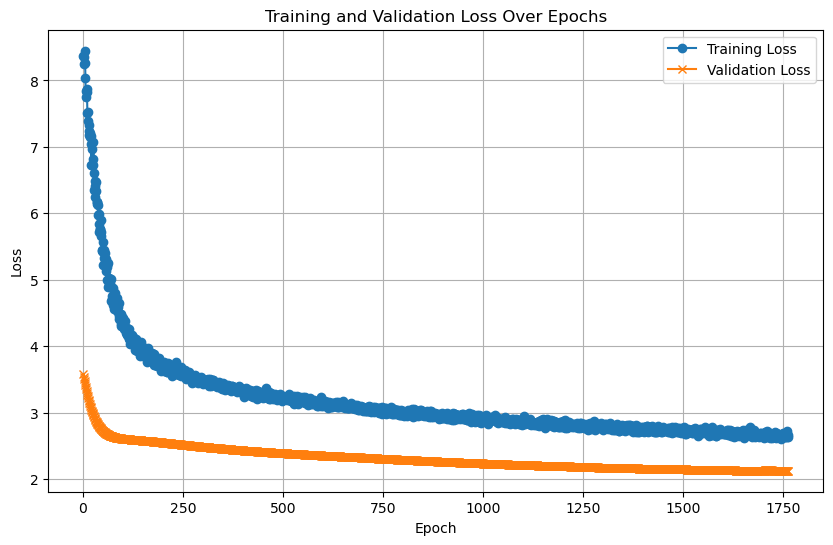

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/579], Loss: 5.8643
Test Batch [20/579], Loss: 6.3653
Test Batch [30/579], Loss: 6.0077
Test Batch [40/579], Loss: 5.8856
Test Batch [50/579], Loss: 6.0119
Test Batch [60/579], Loss: 6.1652
Test Batch [70/579], Loss: 6.0856
Test Batch [80/579], Loss: 6.0098
Test Batch [90/579], Loss: 6.7037
Test Batch [100/579], Loss: 6.3305
Test Batch [110/579], Loss: 6.5206
Test Batch [120/579], Loss: 6.6392
Test Batch [130/579], Loss: 6.3270
Test Batch [140/579], Loss: 6.6116
Test Batch [150/579], Loss: 6.5988


Test Batch [160/579], Loss: 6.3546
Test Batch [170/579], Loss: 6.1679
Test Batch [180/579], Loss: 6.9480
Test Batch [190/579], Loss: 5.9973
Test Batch [200/579], Loss: 6.1364
Test Batch [210/579], Loss: 6.1894
Test Batch [220/579], Loss: 5.8121
Test Batch [230/579], Loss: 6.0896
Test Batch [240/579], Loss: 5.6706
Test Batch [250/579], Loss: 6.2763
Test Batch [260/579], Loss: 6.2496
Test Batch [270/579], Loss: 6.6950
Test Batch [280/579], Loss: 6.9579
Test Batch [290/579], Loss: 6.0444
Test Batch [300/579], Loss: 6.0420


Test Batch [310/579], Loss: 5.3429
Test Batch [320/579], Loss: 4.9479
Test Batch [330/579], Loss: 4.7073
Test Batch [340/579], Loss: 4.9943
Test Batch [350/579], Loss: 4.7106
Test Batch [360/579], Loss: 4.3744
Test Batch [370/579], Loss: 4.9723
Test Batch [380/579], Loss: 6.9909
Test Batch [390/579], Loss: 4.8781
Test Batch [400/579], Loss: 4.4906
Test Batch [410/579], Loss: 4.5141
Test Batch [420/579], Loss: 4.8946
Test Batch [430/579], Loss: 4.5282
Test Batch [440/579], Loss: 4.6649
Test Batch [450/579], Loss: 4.4854


Test Batch [460/579], Loss: 4.4127
Test Batch [470/579], Loss: 4.3750
Test Batch [480/579], Loss: 6.9658
Test Batch [490/579], Loss: 4.3857
Test Batch [500/579], Loss: 4.4069
Test Batch [510/579], Loss: 4.3828
Test Batch [520/579], Loss: 4.6443
Test Batch [530/579], Loss: 4.1837
Test Batch [540/579], Loss: 6.5829


Test Batch [550/579], Loss: 6.6448
Test Batch [560/579], Loss: 7.2923
Test Batch [570/579], Loss: 6.5701

Test Loss: 5.8048


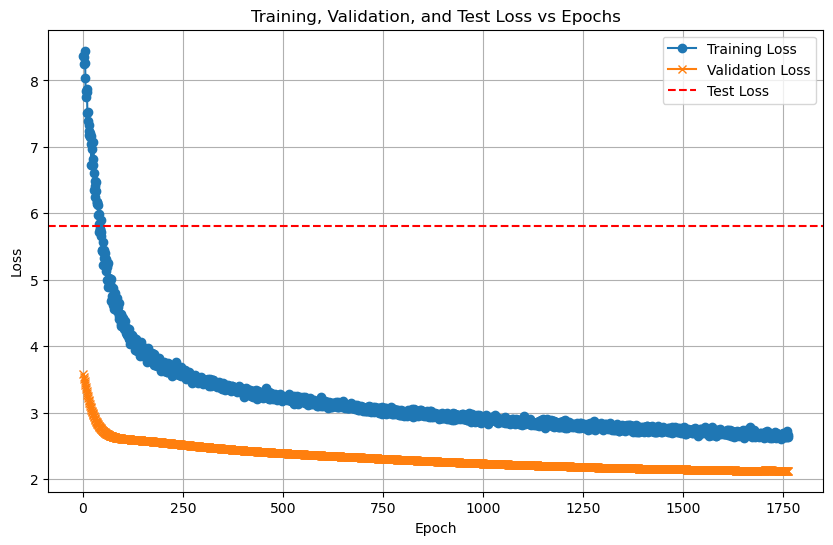

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/579 for test dataset.


  Processed batch 20/579 for test dataset.
  Processed batch 30/579 for test dataset.
  Processed batch 40/579 for test dataset.
  Processed batch 50/579 for test dataset.
  Processed batch 60/579 for test dataset.


  Processed batch 70/579 for test dataset.
  Processed batch 80/579 for test dataset.


  Processed batch 90/579 for test dataset.
  Processed batch 100/579 for test dataset.
  Processed batch 110/579 for test dataset.
  Processed batch 120/579 for test dataset.


  Processed batch 130/579 for test dataset.
  Processed batch 140/579 for test dataset.
  Processed batch 150/579 for test dataset.


  Processed batch 160/579 for test dataset.
  Processed batch 170/579 for test dataset.
  Processed batch 180/579 for test dataset.
  Processed batch 190/579 for test dataset.


  Processed batch 200/579 for test dataset.
  Processed batch 210/579 for test dataset.
  Processed batch 220/579 for test dataset.


  Processed batch 230/579 for test dataset.
  Processed batch 240/579 for test dataset.
  Processed batch 250/579 for test dataset.
  Processed batch 260/579 for test dataset.


  Processed batch 270/579 for test dataset.
  Processed batch 280/579 for test dataset.


  Processed batch 290/579 for test dataset.
  Processed batch 300/579 for test dataset.
  Processed batch 310/579 for test dataset.
  Processed batch 320/579 for test dataset.
  Processed batch 330/579 for test dataset.


  Processed batch 340/579 for test dataset.


  Processed batch 350/579 for test dataset.
  Processed batch 360/579 for test dataset.
  Processed batch 370/579 for test dataset.
  Processed batch 380/579 for test dataset.
  Processed batch 390/579 for test dataset.
  Processed batch 400/579 for test dataset.


  Processed batch 410/579 for test dataset.


  Processed batch 420/579 for test dataset.
  Processed batch 430/579 for test dataset.
  Processed batch 440/579 for test dataset.
  Processed batch 450/579 for test dataset.
  Processed batch 460/579 for test dataset.
  Processed batch 470/579 for test dataset.


  Processed batch 480/579 for test dataset.


  Processed batch 490/579 for test dataset.
  Processed batch 500/579 for test dataset.
  Processed batch 510/579 for test dataset.
  Processed batch 520/579 for test dataset.
  Processed batch 530/579 for test dataset.
  Processed batch 540/579 for test dataset.


  Processed batch 550/579 for test dataset.
  Processed batch 560/579 for test dataset.
  Processed batch 570/579 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 88.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.62      1.00      0.77         5
           2       1.00      0.40      0.57         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       1.00      0.60      0.75         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.89        45
   macro avg       0.92      0.89      0.88        45
weighted avg       0.92      0.89      0.88        45


LOG: Evaluating on the test set...
Test Accuracy: 93.04%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4829  |  Val Loss: 2.3970
Validation loss improved from inf to 2.3970.
[Epoch 2/1000] Train Loss: 2.4417  |  Val Loss: 2.3642
Validation loss improved from 2.3970 to 2.3642.
[Epoch 3/1000] Train Loss: 2.4042  |  Val Loss: 2.3325
Validation loss improved from 2.3642 to 2.3325.
[Epoch 4/1000] Train Loss: 2.3667  |  Val Loss: 2.3020
Validation loss improved from 2.3325 to 2.3020.
[Epoch 5/1000] Train Loss: 2.3307  |  Val Loss: 2.2726
Validation loss improved from 2.3020 to 2.2726.
[Epoch 6/1000] Train Loss: 2.2975  |  Val Loss: 2.2454
Validation loss improved from 2.2726 to 2.2454.
[Epoch 7/1000] Train Loss: 2.2667  |  Val Loss: 2.2197
Validation loss improved from 2.2454 to 2.2197.
[Epoch 8/1000] Train Loss: 2.2374  |  Val Loss: 2.1960
Validation loss improved from 2.2197 to 2.1960.
[Epoch 9/1000] Train Loss: 2.2096  |  Val Loss: 2.1737
Validation loss improved from 2.1960 to 2.1737.
[Epoch 10/1000] Train Loss: 2.1844  |  Val Loss: 2.1526
Validation loss impr

[Epoch 34/1000] Train Loss: 1.8083  |  Val Loss: 1.8412
Validation loss improved from 1.8512 to 1.8412.
[Epoch 35/1000] Train Loss: 1.7961  |  Val Loss: 1.8312
Validation loss improved from 1.8412 to 1.8312.
[Epoch 36/1000] Train Loss: 1.7837  |  Val Loss: 1.8213
Validation loss improved from 1.8312 to 1.8213.
[Epoch 37/1000] Train Loss: 1.7708  |  Val Loss: 1.8116
Validation loss improved from 1.8213 to 1.8116.
[Epoch 38/1000] Train Loss: 1.7586  |  Val Loss: 1.8017
Validation loss improved from 1.8116 to 1.8017.
[Epoch 39/1000] Train Loss: 1.7458  |  Val Loss: 1.7916
Validation loss improved from 1.8017 to 1.7916.
[Epoch 40/1000] Train Loss: 1.7332  |  Val Loss: 1.7813
Validation loss improved from 1.7916 to 1.7813.
[Epoch 41/1000] Train Loss: 1.7198  |  Val Loss: 1.7705
Validation loss improved from 1.7813 to 1.7705.
[Epoch 42/1000] Train Loss: 1.7071  |  Val Loss: 1.7599
Validation loss improved from 1.7705 to 1.7599.
[Epoch 43/1000] Train Loss: 1.6939  |  Val Loss: 1.7493
Validati

[Epoch 44/1000] Train Loss: 1.6807  |  Val Loss: 1.7383
Validation loss improved from 1.7493 to 1.7383.
[Epoch 45/1000] Train Loss: 1.6673  |  Val Loss: 1.7272
Validation loss improved from 1.7383 to 1.7272.
[Epoch 46/1000] Train Loss: 1.6541  |  Val Loss: 1.7158
Validation loss improved from 1.7272 to 1.7158.
[Epoch 47/1000] Train Loss: 1.6402  |  Val Loss: 1.7043
Validation loss improved from 1.7158 to 1.7043.
[Epoch 48/1000] Train Loss: 1.6271  |  Val Loss: 1.6924
Validation loss improved from 1.7043 to 1.6924.
[Epoch 49/1000] Train Loss: 1.6131  |  Val Loss: 1.6805
Validation loss improved from 1.6924 to 1.6805.
[Epoch 50/1000] Train Loss: 1.5995  |  Val Loss: 1.6683
Validation loss improved from 1.6805 to 1.6683.
[Epoch 51/1000] Train Loss: 1.5858  |  Val Loss: 1.6561
Validation loss improved from 1.6683 to 1.6561.
[Epoch 52/1000] Train Loss: 1.5717  |  Val Loss: 1.6438
Validation loss improved from 1.6561 to 1.6438.
[Epoch 53/1000] Train Loss: 1.5578  |  Val Loss: 1.6312
Validati

[Epoch 79/1000] Train Loss: 1.1546  |  Val Loss: 1.2666
Validation loss improved from 1.2807 to 1.2666.
[Epoch 80/1000] Train Loss: 1.1391  |  Val Loss: 1.2532
Validation loss improved from 1.2666 to 1.2532.
[Epoch 81/1000] Train Loss: 1.1244  |  Val Loss: 1.2401
Validation loss improved from 1.2532 to 1.2401.
[Epoch 82/1000] Train Loss: 1.1094  |  Val Loss: 1.2275
Validation loss improved from 1.2401 to 1.2275.
[Epoch 83/1000] Train Loss: 1.0950  |  Val Loss: 1.2153
Validation loss improved from 1.2275 to 1.2153.
[Epoch 84/1000] Train Loss: 1.0807  |  Val Loss: 1.2032
Validation loss improved from 1.2153 to 1.2032.
[Epoch 85/1000] Train Loss: 1.0668  |  Val Loss: 1.1914
Validation loss improved from 1.2032 to 1.1914.
[Epoch 86/1000] Train Loss: 1.0530  |  Val Loss: 1.1801
Validation loss improved from 1.1914 to 1.1801.


[Epoch 87/1000] Train Loss: 1.0397  |  Val Loss: 1.1690
Validation loss improved from 1.1801 to 1.1690.
[Epoch 88/1000] Train Loss: 1.0266  |  Val Loss: 1.1581
Validation loss improved from 1.1690 to 1.1581.
[Epoch 89/1000] Train Loss: 1.0138  |  Val Loss: 1.1477
Validation loss improved from 1.1581 to 1.1477.
[Epoch 90/1000] Train Loss: 1.0017  |  Val Loss: 1.1374
Validation loss improved from 1.1477 to 1.1374.
[Epoch 91/1000] Train Loss: 0.9893  |  Val Loss: 1.1272
Validation loss improved from 1.1374 to 1.1272.
[Epoch 92/1000] Train Loss: 0.9774  |  Val Loss: 1.1173
Validation loss improved from 1.1272 to 1.1173.
[Epoch 93/1000] Train Loss: 0.9659  |  Val Loss: 1.1075
Validation loss improved from 1.1173 to 1.1075.
[Epoch 94/1000] Train Loss: 0.9544  |  Val Loss: 1.0977
Validation loss improved from 1.1075 to 1.0977.
[Epoch 95/1000] Train Loss: 0.9432  |  Val Loss: 1.0879
Validation loss improved from 1.0977 to 1.0879.
[Epoch 96/1000] Train Loss: 0.9321  |  Val Loss: 1.0781
Validati

[Epoch 121/1000] Train Loss: 0.6965  |  Val Loss: 0.8799
Validation loss improved from 0.8869 to 0.8799.
[Epoch 122/1000] Train Loss: 0.6884  |  Val Loss: 0.8732
Validation loss improved from 0.8799 to 0.8732.
[Epoch 123/1000] Train Loss: 0.6806  |  Val Loss: 0.8665
Validation loss improved from 0.8732 to 0.8665.
[Epoch 124/1000] Train Loss: 0.6728  |  Val Loss: 0.8599
Validation loss improved from 0.8665 to 0.8599.
[Epoch 125/1000] Train Loss: 0.6649  |  Val Loss: 0.8541
Validation loss improved from 0.8599 to 0.8541.
[Epoch 126/1000] Train Loss: 0.6572  |  Val Loss: 0.8489
Validation loss improved from 0.8541 to 0.8489.


[Epoch 127/1000] Train Loss: 0.6494  |  Val Loss: 0.8441
Validation loss improved from 0.8489 to 0.8441.
[Epoch 128/1000] Train Loss: 0.6422  |  Val Loss: 0.8391
Validation loss improved from 0.8441 to 0.8391.
[Epoch 129/1000] Train Loss: 0.6343  |  Val Loss: 0.8339
Validation loss improved from 0.8391 to 0.8339.
[Epoch 130/1000] Train Loss: 0.6272  |  Val Loss: 0.8284
Validation loss improved from 0.8339 to 0.8284.
[Epoch 131/1000] Train Loss: 0.6197  |  Val Loss: 0.8231
Validation loss improved from 0.8284 to 0.8231.
[Epoch 132/1000] Train Loss: 0.6129  |  Val Loss: 0.8179
Validation loss improved from 0.8231 to 0.8179.
[Epoch 133/1000] Train Loss: 0.6057  |  Val Loss: 0.8124
Validation loss improved from 0.8179 to 0.8124.
[Epoch 134/1000] Train Loss: 0.5990  |  Val Loss: 0.8068
Validation loss improved from 0.8124 to 0.8068.
[Epoch 135/1000] Train Loss: 0.5921  |  Val Loss: 0.8016
Validation loss improved from 0.8068 to 0.8016.
[Epoch 136/1000] Train Loss: 0.5855  |  Val Loss: 0.796

[Epoch 163/1000] Train Loss: 0.4337  |  Val Loss: 0.6716
Validation loss improved from 0.6763 to 0.6716.
[Epoch 164/1000] Train Loss: 0.4289  |  Val Loss: 0.6676
Validation loss improved from 0.6716 to 0.6676.
[Epoch 165/1000] Train Loss: 0.4241  |  Val Loss: 0.6642
Validation loss improved from 0.6676 to 0.6642.
[Epoch 166/1000] Train Loss: 0.4194  |  Val Loss: 0.6608
Validation loss improved from 0.6642 to 0.6608.
[Epoch 167/1000] Train Loss: 0.4150  |  Val Loss: 0.6575
Validation loss improved from 0.6608 to 0.6575.
[Epoch 168/1000] Train Loss: 0.4102  |  Val Loss: 0.6546
Validation loss improved from 0.6575 to 0.6546.
[Epoch 169/1000] Train Loss: 0.4059  |  Val Loss: 0.6518
Validation loss improved from 0.6546 to 0.6518.
[Epoch 170/1000] Train Loss: 0.4012  |  Val Loss: 0.6484
Validation loss improved from 0.6518 to 0.6484.
[Epoch 171/1000] Train Loss: 0.3969  |  Val Loss: 0.6448
Validation loss improved from 0.6484 to 0.6448.
[Epoch 172/1000] Train Loss: 0.3922  |  Val Loss: 0.640

[Epoch 173/1000] Train Loss: 0.3879  |  Val Loss: 0.6359
Validation loss improved from 0.6406 to 0.6359.
[Epoch 174/1000] Train Loss: 0.3835  |  Val Loss: 0.6322
Validation loss improved from 0.6359 to 0.6322.
[Epoch 175/1000] Train Loss: 0.3790  |  Val Loss: 0.6285
Validation loss improved from 0.6322 to 0.6285.
[Epoch 176/1000] Train Loss: 0.3746  |  Val Loss: 0.6239
Validation loss improved from 0.6285 to 0.6239.
[Epoch 177/1000] Train Loss: 0.3705  |  Val Loss: 0.6187
Validation loss improved from 0.6239 to 0.6187.
[Epoch 178/1000] Train Loss: 0.3664  |  Val Loss: 0.6135
Validation loss improved from 0.6187 to 0.6135.
[Epoch 179/1000] Train Loss: 0.3622  |  Val Loss: 0.6091
Validation loss improved from 0.6135 to 0.6091.
[Epoch 180/1000] Train Loss: 0.3582  |  Val Loss: 0.6049
Validation loss improved from 0.6091 to 0.6049.
[Epoch 181/1000] Train Loss: 0.3543  |  Val Loss: 0.6004
Validation loss improved from 0.6049 to 0.6004.
[Epoch 182/1000] Train Loss: 0.3504  |  Val Loss: 0.596

[Epoch 207/1000] Train Loss: 0.2671  |  Val Loss: 0.5380
Validation loss improved from 0.5403 to 0.5380.
[Epoch 208/1000] Train Loss: 0.2645  |  Val Loss: 0.5356
Validation loss improved from 0.5380 to 0.5356.
[Epoch 209/1000] Train Loss: 0.2617  |  Val Loss: 0.5342
Validation loss improved from 0.5356 to 0.5342.
[Epoch 210/1000] Train Loss: 0.2591  |  Val Loss: 0.5329
Validation loss improved from 0.5342 to 0.5329.
[Epoch 211/1000] Train Loss: 0.2566  |  Val Loss: 0.5312
Validation loss improved from 0.5329 to 0.5312.
[Epoch 212/1000] Train Loss: 0.2538  |  Val Loss: 0.5285
Validation loss improved from 0.5312 to 0.5285.
[Epoch 213/1000] Train Loss: 0.2514  |  Val Loss: 0.5259
Validation loss improved from 0.5285 to 0.5259.
[Epoch 214/1000] Train Loss: 0.2489  |  Val Loss: 0.5230
Validation loss improved from 0.5259 to 0.5230.
[Epoch 215/1000] Train Loss: 0.2464  |  Val Loss: 0.5206
Validation loss improved from 0.5230 to 0.5206.
[Epoch 216/1000] Train Loss: 0.2440  |  Val Loss: 0.517

[Epoch 217/1000] Train Loss: 0.2417  |  Val Loss: 0.5143
Validation loss improved from 0.5175 to 0.5143.
[Epoch 218/1000] Train Loss: 0.2391  |  Val Loss: 0.5126
Validation loss improved from 0.5143 to 0.5126.
[Epoch 219/1000] Train Loss: 0.2368  |  Val Loss: 0.5107
Validation loss improved from 0.5126 to 0.5107.
[Epoch 220/1000] Train Loss: 0.2343  |  Val Loss: 0.5082
Validation loss improved from 0.5107 to 0.5082.
[Epoch 221/1000] Train Loss: 0.2321  |  Val Loss: 0.5064
Validation loss improved from 0.5082 to 0.5064.
[Epoch 222/1000] Train Loss: 0.2297  |  Val Loss: 0.5056
Validation loss improved from 0.5064 to 0.5056.
[Epoch 223/1000] Train Loss: 0.2274  |  Val Loss: 0.5058
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 224/1000] Train Loss: 0.2251  |  Val Loss: 0.5058
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 225/1000] Train Loss: 0.2229  |  Val Loss: 0.5059
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 226/1000] Train Loss: 0.2205  

[Epoch 250/1000] Train Loss: 0.1750  |  Val Loss: 0.4765
Validation loss improved from 0.4784 to 0.4765.
[Epoch 251/1000] Train Loss: 0.1733  |  Val Loss: 0.4745
Validation loss improved from 0.4765 to 0.4745.
[Epoch 252/1000] Train Loss: 0.1716  |  Val Loss: 0.4725
Validation loss improved from 0.4745 to 0.4725.
[Epoch 253/1000] Train Loss: 0.1699  |  Val Loss: 0.4699
Validation loss improved from 0.4725 to 0.4699.
[Epoch 254/1000] Train Loss: 0.1683  |  Val Loss: 0.4672
Validation loss improved from 0.4699 to 0.4672.
[Epoch 255/1000] Train Loss: 0.1667  |  Val Loss: 0.4649
Validation loss improved from 0.4672 to 0.4649.
[Epoch 256/1000] Train Loss: 0.1653  |  Val Loss: 0.4630
Validation loss improved from 0.4649 to 0.4630.
[Epoch 257/1000] Train Loss: 0.1635  |  Val Loss: 0.4623
Validation loss improved from 0.4630 to 0.4623.
[Epoch 258/1000] Train Loss: 0.1620  |  Val Loss: 0.4613
Validation loss improved from 0.4623 to 0.4613.
[Epoch 259/1000] Train Loss: 0.1604  |  Val Loss: 0.459

[Epoch 263/1000] Train Loss: 0.1544  |  Val Loss: 0.4601
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 264/1000] Train Loss: 0.1530  |  Val Loss: 0.4595
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 265/1000] Train Loss: 0.1516  |  Val Loss: 0.4586
Validation loss improved from 0.4590 to 0.4586.
[Epoch 266/1000] Train Loss: 0.1502  |  Val Loss: 0.4571
Validation loss improved from 0.4586 to 0.4571.
[Epoch 267/1000] Train Loss: 0.1489  |  Val Loss: 0.4555
Validation loss improved from 0.4571 to 0.4555.
[Epoch 268/1000] Train Loss: 0.1474  |  Val Loss: 0.4530
Validation loss improved from 0.4555 to 0.4530.
[Epoch 269/1000] Train Loss: 0.1462  |  Val Loss: 0.4500
Validation loss improved from 0.4530 to 0.4500.
[Epoch 270/1000] Train Loss: 0.1449  |  Val Loss: 0.4477
Validation loss improved from 0.4500 to 0.4477.
[Epoch 271/1000] Train Loss: 0.1436  |  Val Loss: 0.4453
Validation loss improved from 0.4477 to 0.4453.
[Epoch 272/1000] Train Loss: 0.1423  |  Val

[Epoch 294/1000] Train Loss: 0.1190  |  Val Loss: 0.4285
Validation loss improved from 0.4288 to 0.4285.
[Epoch 295/1000] Train Loss: 0.1181  |  Val Loss: 0.4271
Validation loss improved from 0.4285 to 0.4271.
[Epoch 296/1000] Train Loss: 0.1171  |  Val Loss: 0.4249
Validation loss improved from 0.4271 to 0.4249.
[Epoch 297/1000] Train Loss: 0.1165  |  Val Loss: 0.4237
Validation loss improved from 0.4249 to 0.4237.
[Epoch 298/1000] Train Loss: 0.1156  |  Val Loss: 0.4236
Validation loss improved from 0.4237 to 0.4236.
[Epoch 299/1000] Train Loss: 0.1146  |  Val Loss: 0.4230
Validation loss improved from 0.4236 to 0.4230.
[Epoch 300/1000] Train Loss: 0.1138  |  Val Loss: 0.4227
Validation loss improved from 0.4230 to 0.4227.
[Epoch 301/1000] Train Loss: 0.1130  |  Val Loss: 0.4224
Validation loss improved from 0.4227 to 0.4224.
[Epoch 302/1000] Train Loss: 0.1121  |  Val Loss: 0.4216
Validation loss improved from 0.4224 to 0.4216.
[Epoch 303/1000] Train Loss: 0.1115  |  Val Loss: 0.421

[Epoch 304/1000] Train Loss: 0.1106  |  Val Loss: 0.4230
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 305/1000] Train Loss: 0.1098  |  Val Loss: 0.4242
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 306/1000] Train Loss: 0.1089  |  Val Loss: 0.4250
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 307/1000] Train Loss: 0.1081  |  Val Loss: 0.4269
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 308/1000] Train Loss: 0.1073  |  Val Loss: 0.4284
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 309/1000] Train Loss: 0.1066  |  Val Loss: 0.4297
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 310/1000] Train Loss: 0.1059  |  Val Loss: 0.4305
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 311/1000] Train Loss: 0.1052  |  Val Loss: 0.4305
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 312/1000] Train Loss: 0.1044  |  Val Loss: 0.4312
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 341/1000] Train Loss: 0.0869  |  Val Loss: 0.4211
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 342/1000] Train Loss: 0.0864  |  Val Loss: 0.4224
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 343/1000] Train Loss: 0.0859  |  Val Loss: 0.4229
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 344/1000] Train Loss: 0.0855  |  Val Loss: 0.4223
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 345/1000] Train Loss: 0.0849  |  Val Loss: 0.4206
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 346/1000] Train Loss: 0.0844  |  Val Loss: 0.4192
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 347/1000] Train Loss: 0.0839  |  Val Loss: 0.4179
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 348/1000] Train Loss: 0.0834  |  Val Loss: 0.4166
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 349/1000] Train Loss: 0.0829  |  Val Loss: 0.4144
!! Validation loss did NOT improve !! Patience: 1

[Epoch 351/1000] Train Loss: 0.0825  |  Val Loss: 0.4096
Validation loss improved from 0.4114 to 0.4096.
[Epoch 352/1000] Train Loss: 0.0818  |  Val Loss: 0.4099
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 353/1000] Train Loss: 0.0813  |  Val Loss: 0.4104
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 354/1000] Train Loss: 0.0809  |  Val Loss: 0.4108
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 355/1000] Train Loss: 0.0804  |  Val Loss: 0.4110
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 356/1000] Train Loss: 0.0800  |  Val Loss: 0.4116
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 357/1000] Train Loss: 0.0795  |  Val Loss: 0.4138
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 358/1000] Train Loss: 0.0792  |  Val Loss: 0.4165
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 359/1000] Train Loss: 0.0786  |  Val Loss: 0.4180
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 384/1000] Train Loss: 0.0690  |  Val Loss: 0.4096
Validation loss improved from 0.4096 to 0.4096.
[Epoch 385/1000] Train Loss: 0.0687  |  Val Loss: 0.4104
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 386/1000] Train Loss: 0.0682  |  Val Loss: 0.4129
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 387/1000] Train Loss: 0.0677  |  Val Loss: 0.4151
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 388/1000] Train Loss: 0.0674  |  Val Loss: 0.4176
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 389/1000] Train Loss: 0.0670  |  Val Loss: 0.4200
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 390/1000] Train Loss: 0.0666  |  Val Loss: 0.4232
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 391/1000] Train Loss: 0.0668  |  Val Loss: 0.4267
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 392/1000] Train Loss: 0.0664  |  Val Loss: 0.4277
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 395/1000] Train Loss: 0.0653  |  Val Loss: 0.4236
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 396/1000] Train Loss: 0.0649  |  Val Loss: 0.4194
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 397/1000] Train Loss: 0.0649  |  Val Loss: 0.4163
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 398/1000] Train Loss: 0.0642  |  Val Loss: 0.4152
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 399/1000] Train Loss: 0.0638  |  Val Loss: 0.4132
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 400/1000] Train Loss: 0.0639  |  Val Loss: 0.4117
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 401/1000] Train Loss: 0.0633  |  Val Loss: 0.4126
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 402/1000] Train Loss: 0.0629  |  Val Loss: 0.4151
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 403/1000] Train Loss: 0.0628  |  Val Loss: 0.4188
!! Validation loss did NOT improve !! Patience:

[Epoch 426/1000] Train Loss: 0.0569  |  Val Loss: 0.4132
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 427/1000] Train Loss: 0.0565  |  Val Loss: 0.4160
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 428/1000] Train Loss: 0.0564  |  Val Loss: 0.4181
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 429/1000] Train Loss: 0.0560  |  Val Loss: 0.4186
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 430/1000] Train Loss: 0.0559  |  Val Loss: 0.4190
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 431/1000] Train Loss: 0.0559  |  Val Loss: 0.4206
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 432/1000] Train Loss: 0.0554  |  Val Loss: 0.4205
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 433/1000] Train Loss: 0.0552  |  Val Loss: 0.4213
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 434/1000] Train Loss: 0.0550  |  Val Loss: 0.4211
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 441/1000] Train Loss: 0.0537  |  Val Loss: 0.4151
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 442/1000] Train Loss: 0.0533  |  Val Loss: 0.4166
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 443/1000] Train Loss: 0.0531  |  Val Loss: 0.4197
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 444/1000] Train Loss: 0.0531  |  Val Loss: 0.4219
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 445/1000] Train Loss: 0.0526  |  Val Loss: 0.4221
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 446/1000] Train Loss: 0.0525  |  Val Loss: 0.4221
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 447/1000] Train Loss: 0.0522  |  Val Loss: 0.4214
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 448/1000] Train Loss: 0.0520  |  Val Loss: 0.4208
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 449/1000] Train Loss: 0.0519  |  Val Loss: 0.4199
!! Validation loss did NOT improve !! Patience:

[Epoch 472/1000] Train Loss: 0.0482  |  Val Loss: 0.4154
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 473/1000] Train Loss: 0.0481  |  Val Loss: 0.4179
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 474/1000] Train Loss: 0.0477  |  Val Loss: 0.4197
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 475/1000] Train Loss: 0.0474  |  Val Loss: 0.4234
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 476/1000] Train Loss: 0.0471  |  Val Loss: 0.4270
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 477/1000] Train Loss: 0.0469  |  Val Loss: 0.4319
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 478/1000] Train Loss: 0.0471  |  Val Loss: 0.4360
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 479/1000] Train Loss: 0.0469  |  Val Loss: 0.4383
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 480/1000] Train Loss: 0.0468  |  Val Loss: 0.4399
!! Validation loss did NOT improve !! Patience:

[Epoch 483/1000] Train Loss: 0.0465  |  Val Loss: 0.4420
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 484/1000] Train Loss: 0.0464  |  Val Loss: 0.4427
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 485/1000] Train Loss: 0.0463  |  Val Loss: 0.4424
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 486/1000] Train Loss: 0.0461  |  Val Loss: 0.4403
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 487/1000] Train Loss: 0.0462  |  Val Loss: 0.4378
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 488/1000] Train Loss: 0.0456  |  Val Loss: 0.4371
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 489/1000] Train Loss: 0.0454  |  Val Loss: 0.4348
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 490/1000] Train Loss: 0.0452  |  Val Loss: 0.4307
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 491/1000] Train Loss: 0.0454  |  Val Loss: 0.4279
!! Validation loss did NOT improve !! Patience:

[Epoch 513/1000] Train Loss: 0.0422  |  Val Loss: 0.4237
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 514/1000] Train Loss: 0.0422  |  Val Loss: 0.4229
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 515/1000] Train Loss: 0.0424  |  Val Loss: 0.4222
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 516/1000] Train Loss: 0.0421  |  Val Loss: 0.4240
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 517/1000] Train Loss: 0.0419  |  Val Loss: 0.4253
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 518/1000] Train Loss: 0.0418  |  Val Loss: 0.4264
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 519/1000] Train Loss: 0.0415  |  Val Loss: 0.4261
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 520/1000] Train Loss: 0.0414  |  Val Loss: 0.4260
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 521/1000] Train Loss: 0.0415  |  Val Loss: 0.4261
!! Validation loss did NOT improve !! Patience:

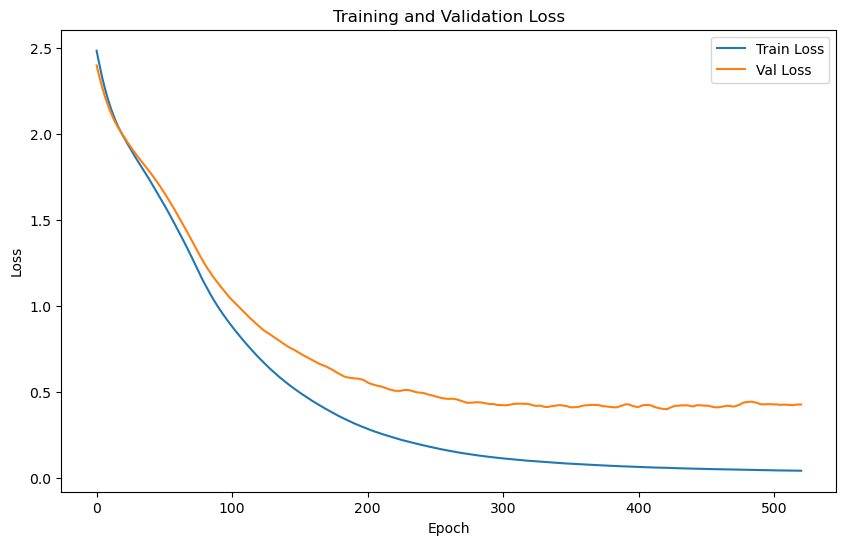

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.2139 | Test Accuracy: 93.86%


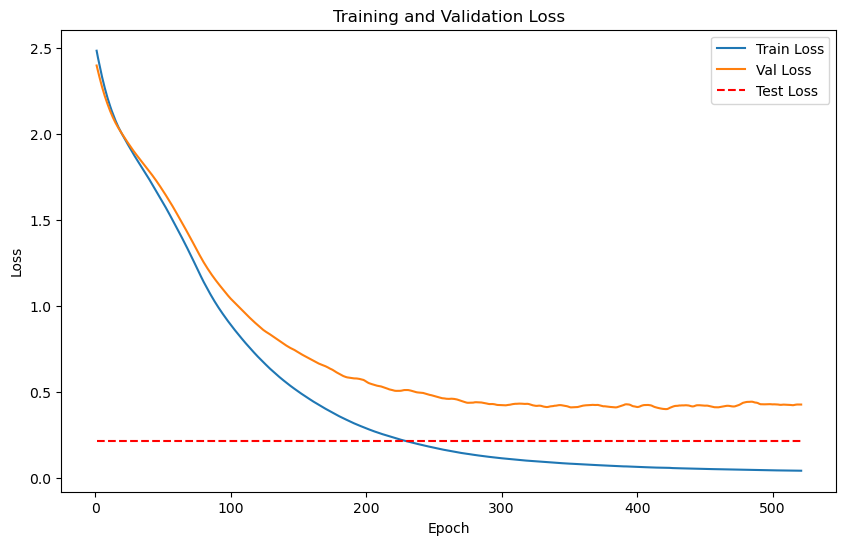

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 90 samples with 64 features each
LOG: Labels shape: (90,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 148017 samples with 64 features each
LOG: Labels shape: (148017,)


Train embeddings shape: (90, 64), 
Train labels shape: (90,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (148017, 64), 
Test labels shape: (148017,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10}
Training batch size: 90


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3994
Epoch [1/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.3994

Validation loss improved from inf to 0.3994. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3979
Epoch [2/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3979

Validation loss improved from 0.3994 to 0.3979. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.3958
Epoch [3/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.3958

Validation loss improved from 0.3979 to 0.3958. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3933
Epoch [4/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.3933

Validation loss improved from 0.3958 to 0.3933. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3907
Epoch [5/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3907

Validation loss improved from 0.3933 to 0.3907. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [6/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3883

Validation loss improved from 0.3907 to 0.3883. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.3855
Epoch [7/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3855

Validation loss improved from 0.3883 to 0.3855. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3833
Epoch [8/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.3833

Validation loss improved from 0.3855 to 0.3833. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.3812
Epoch [9/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.3812

Validation loss improved from 0.3833 to 0.3812. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3794
Epoch [10/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.3794

Validation loss improved from 0.3812 to 0.3794. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3779
Epoch [11/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3779

Validation loss improved from 0.3794 to 0.3779. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [12/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.3774

Validation loss improved from 0.3779 to 0.3774. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [13/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.3774

Validation loss improved from 0.3774 to 0.3774. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [14/2000] - Validation


    Batch [1/1], Val Loss: 0.3775
Epoch [14/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.3775

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3777
Epoch [15/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.3777

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.3779
Epoch [16/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3779

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3779
Epoch [17/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.3779

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3779
Epoch [18/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.3779

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [19/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3780

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [20/2000] - Validation


    Batch [1/1], Val Loss: 0.3780
Epoch [20/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.3780

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [21/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.3780

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [22/2000] - Validation


    Batch [1/1], Val Loss: 0.3779
Epoch [22/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.3779

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3778
Epoch [23/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.3778

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3776
Epoch [24/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.3776

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [25/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3774

Validation loss improved from 0.3774 to 0.3774. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [26/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.3771

Validation loss improved from 0.3774 to 0.3771. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.3767
Epoch [27/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3767

Validation loss improved from 0.3771 to 0.3767. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3763
Epoch [28/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3763

Validation loss improved from 0.3767 to 0.3763. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [29/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3759

Validation loss improved from 0.3763 to 0.3759. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3754
Epoch [30/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.3754

Validation loss improved from 0.3759 to 0.3754. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3750
Epoch [31/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3750

Validation loss improved from 0.3754 to 0.3750. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [32/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.3745

Validation loss improved from 0.3750 to 0.3745. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [33/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3739

Validation loss improved from 0.3745 to 0.3739. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [34/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3734

Validation loss improved from 0.3739 to 0.3734. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3728
Epoch [35/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3728

Validation loss improved from 0.3734 to 0.3728. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3723
Epoch [36/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3723

Validation loss improved from 0.3728 to 0.3723. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3717
Epoch [37/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.3717

Validation loss improved from 0.3723 to 0.3717. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3712
Epoch [38/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3712

Validation loss improved from 0.3717 to 0.3712. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [39/2000] - Validation


    Batch [1/1], Val Loss: 0.3706
Epoch [39/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3706

Validation loss improved from 0.3712 to 0.3706. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3701
Epoch [40/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3701

Validation loss improved from 0.3706 to 0.3701. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [41/2000] - Validation


    Batch [1/1], Val Loss: 0.3695
Epoch [41/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3695

Validation loss improved from 0.3701 to 0.3695. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3689
Epoch [42/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3689

Validation loss improved from 0.3695 to 0.3689. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3683
Epoch [43/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3683

Validation loss improved from 0.3689 to 0.3683. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [44/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3677

Validation loss improved from 0.3683 to 0.3677. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3671
Epoch [45/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3671

Validation loss improved from 0.3677 to 0.3671. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3665
Epoch [46/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.3665

Validation loss improved from 0.3671 to 0.3665. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3659
Epoch [47/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.3659

Validation loss improved from 0.3665 to 0.3659. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.3653
Epoch [48/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3653

Validation loss improved from 0.3659 to 0.3653. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3647
Epoch [49/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3647

Validation loss improved from 0.3653 to 0.3647. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [50/2000] - Validation


    Batch [1/1], Val Loss: 0.3640
Epoch [50/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.3640

Validation loss improved from 0.3647 to 0.3640. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3634
Epoch [51/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3634

Validation loss improved from 0.3640 to 0.3634. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3627
Epoch [52/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3627

Validation loss improved from 0.3634 to 0.3627. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3620
Epoch [53/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3620

Validation loss improved from 0.3627 to 0.3620. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3613
Epoch [54/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.3613

Validation loss improved from 0.3620 to 0.3613. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [55/2000] - Validation


    Batch [1/1], Val Loss: 0.3606
Epoch [55/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3606

Validation loss improved from 0.3613 to 0.3606. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [56/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3600

Validation loss improved from 0.3606 to 0.3600. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [57/2000] - Validation


    Batch [1/1], Val Loss: 0.3593
Epoch [57/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3593

Validation loss improved from 0.3600 to 0.3593. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3586
Epoch [58/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.3586

Validation loss improved from 0.3593 to 0.3586. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3580
Epoch [59/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.3580

Validation loss improved from 0.3586 to 0.3580. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [60/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.3573

Validation loss improved from 0.3580 to 0.3573. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3567
Epoch [61/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.3567

Validation loss improved from 0.3573 to 0.3567. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [62/2000] - Validation


    Batch [1/1], Val Loss: 0.3560
Epoch [62/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3560

Validation loss improved from 0.3567 to 0.3560. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3553
Epoch [63/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.3553

Validation loss improved from 0.3560 to 0.3553. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [64/2000] - Validation


    Batch [1/1], Val Loss: 0.3547
Epoch [64/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.3547

Validation loss improved from 0.3553 to 0.3547. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3540
Epoch [65/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.3540

Validation loss improved from 0.3547 to 0.3540. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [66/2000] - Validation


    Batch [1/1], Val Loss: 0.3534
Epoch [66/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3534

Validation loss improved from 0.3540 to 0.3534. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3527
Epoch [67/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3527

Validation loss improved from 0.3534 to 0.3527. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.3521
Epoch [68/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3521

Validation loss improved from 0.3527 to 0.3521. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3514
Epoch [69/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3514

Validation loss improved from 0.3521 to 0.3514. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.3508
Epoch [70/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.3508

Validation loss improved from 0.3514 to 0.3508. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [71/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3502

Validation loss improved from 0.3508 to 0.3502. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [72/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3496

Validation loss improved from 0.3502 to 0.3496. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3489
Epoch [73/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.3489

Validation loss improved from 0.3496 to 0.3489. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3483
Epoch [74/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.3483

Validation loss improved from 0.3489 to 0.3483. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3477
Epoch [75/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.3477

Validation loss improved from 0.3483 to 0.3477. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [76/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.3471

Validation loss improved from 0.3477 to 0.3471. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [77/2000] - Validation


    Batch [1/1], Val Loss: 0.3465
Epoch [77/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.3465

Validation loss improved from 0.3471 to 0.3465. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [78/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3459

Validation loss improved from 0.3465 to 0.3459. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3453
Epoch [79/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3453

Validation loss improved from 0.3459 to 0.3453. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [80/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.3447

Validation loss improved from 0.3453 to 0.3447. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3442
Epoch [81/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3442

Validation loss improved from 0.3447 to 0.3442. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3436
Epoch [82/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.3436

Validation loss improved from 0.3442 to 0.3436. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3430
Epoch [83/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.3430

Validation loss improved from 0.3436 to 0.3430. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3424
Epoch [84/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3424

Validation loss improved from 0.3430 to 0.3424. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3418
Epoch [85/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.3418

Validation loss improved from 0.3424 to 0.3418. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [86/2000] - Validation


    Batch [1/1], Val Loss: 0.3412
Epoch [86/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3412

Validation loss improved from 0.3418 to 0.3412. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3406
Epoch [87/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.3406

Validation loss improved from 0.3412 to 0.3406. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [88/2000] - Validation


    Batch [1/1], Val Loss: 0.3399
Epoch [88/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3399

Validation loss improved from 0.3406 to 0.3399. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3393
Epoch [89/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.3393

Validation loss improved from 0.3399 to 0.3393. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [90/2000] - Validation


    Batch [1/1], Val Loss: 0.3387
Epoch [90/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.3387

Validation loss improved from 0.3393 to 0.3387. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3381
Epoch [91/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3381

Validation loss improved from 0.3387 to 0.3381. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [92/2000] - Validation


    Batch [1/1], Val Loss: 0.3375
Epoch [92/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3375

Validation loss improved from 0.3381 to 0.3375. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3369
Epoch [93/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3369

Validation loss improved from 0.3375 to 0.3369. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [94/2000] - Validation


    Batch [1/1], Val Loss: 0.3363
Epoch [94/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3363

Validation loss improved from 0.3369 to 0.3363. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [95/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.3356

Validation loss improved from 0.3363 to 0.3356. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [96/2000] - Validation


    Batch [1/1], Val Loss: 0.3350
Epoch [96/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.3350

Validation loss improved from 0.3356 to 0.3350. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [97/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.3343

Validation loss improved from 0.3350 to 0.3343. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [98/2000] - Validation


    Batch [1/1], Val Loss: 0.3337
Epoch [98/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.3337

Validation loss improved from 0.3343 to 0.3337. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [99/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3330

Validation loss improved from 0.3337 to 0.3330. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [100/2000] - Validation


    Batch [1/1], Val Loss: 0.3323
Epoch [100/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.3323

Validation loss improved from 0.3330 to 0.3323. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [101/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.3316

Validation loss improved from 0.3323 to 0.3316. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [102/2000] - Validation


    Batch [1/1], Val Loss: 0.3310
Epoch [102/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.3310

Validation loss improved from 0.3316 to 0.3310. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3304
Epoch [103/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.3304

Validation loss improved from 0.3310 to 0.3304. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [104/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3298

Validation loss improved from 0.3304 to 0.3298. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [105/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.3292

Validation loss improved from 0.3298 to 0.3292. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3286
Epoch [106/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.3286

Validation loss improved from 0.3292 to 0.3286. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3280
Epoch [107/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3280

Validation loss improved from 0.3286 to 0.3280. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3275
Epoch [108/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.3275

Validation loss improved from 0.3280 to 0.3275. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3269
Epoch [109/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.3269

Validation loss improved from 0.3275 to 0.3269. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3264
Epoch [110/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.3264

Validation loss improved from 0.3269 to 0.3264. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3313
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [111/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.3259

Validation loss improved from 0.3264 to 0.3259. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3396
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3254
Epoch [112/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.3254

Validation loss improved from 0.3259 to 0.3254. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3381
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [113/2000], Avg Train Loss: 0.3381, Avg Val Loss: 0.3249

Validation loss improved from 0.3254 to 0.3249. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3244
Epoch [114/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.3244

Validation loss improved from 0.3249 to 0.3244. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3239
Epoch [115/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3239

Validation loss improved from 0.3244 to 0.3239. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3234
Epoch [116/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.3234

Validation loss improved from 0.3239 to 0.3234. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [117/2000] - Validation


    Batch [1/1], Val Loss: 0.3229
Epoch [117/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.3229

Validation loss improved from 0.3234 to 0.3229. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3224
Epoch [118/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.3224

Validation loss improved from 0.3229 to 0.3224. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [119/2000] - Validation


    Batch [1/1], Val Loss: 0.3219
Epoch [119/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.3219

Validation loss improved from 0.3224 to 0.3219. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3214
Epoch [120/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.3214

Validation loss improved from 0.3219 to 0.3214. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [121/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3209

Validation loss improved from 0.3214 to 0.3209. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [122/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.3203

Validation loss improved from 0.3209 to 0.3203. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3198
Epoch [123/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.3198

Validation loss improved from 0.3203 to 0.3198. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3193
Epoch [124/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3193

Validation loss improved from 0.3198 to 0.3193. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3187
Epoch [125/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.3187

Validation loss improved from 0.3193 to 0.3187. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3182
Epoch [126/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.3182

Validation loss improved from 0.3187 to 0.3182. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3311
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3177
Epoch [127/2000], Avg Train Loss: 0.3311, Avg Val Loss: 0.3177

Validation loss improved from 0.3182 to 0.3177. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3172
Epoch [128/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3172

Validation loss improved from 0.3177 to 0.3172. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3166
Epoch [129/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.3166

Validation loss improved from 0.3172 to 0.3166. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3161
Epoch [130/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.3161

Validation loss improved from 0.3166 to 0.3161. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3306
LOG: Epoch [131/2000] - Validation


    Batch [1/1], Val Loss: 0.3156
Epoch [131/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.3156

Validation loss improved from 0.3161 to 0.3156. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [132/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.3150

Validation loss improved from 0.3156 to 0.3150. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [133/2000] - Validation


    Batch [1/1], Val Loss: 0.3145
Epoch [133/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.3145

Validation loss improved from 0.3150 to 0.3145. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [134/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.3140

Validation loss improved from 0.3145 to 0.3140. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3135
Epoch [135/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.3135

Validation loss improved from 0.3140 to 0.3135. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3130
Epoch [136/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3130

Validation loss improved from 0.3135 to 0.3130. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [137/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.3125

Validation loss improved from 0.3130 to 0.3125. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3135
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3119
Epoch [138/2000], Avg Train Loss: 0.3135, Avg Val Loss: 0.3119

Validation loss improved from 0.3125 to 0.3119. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [139/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3114

Validation loss improved from 0.3119 to 0.3114. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3109
Epoch [140/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.3109

Validation loss improved from 0.3114 to 0.3109. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3252
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3103
Epoch [141/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.3103

Validation loss improved from 0.3109 to 0.3103. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3098
Epoch [142/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.3098

Validation loss improved from 0.3103 to 0.3098. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3092
Epoch [143/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.3092

Validation loss improved from 0.3098 to 0.3092. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [144/2000] - Validation


    Batch [1/1], Val Loss: 0.3087
Epoch [144/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3087

Validation loss improved from 0.3092 to 0.3087. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [145/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.3081

Validation loss improved from 0.3087 to 0.3081. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [146/2000] - Validation


    Batch [1/1], Val Loss: 0.3076
Epoch [146/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.3076

Validation loss improved from 0.3081 to 0.3076. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3147
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [147/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.3071

Validation loss improved from 0.3076 to 0.3071. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3150
LOG: Epoch [148/2000] - Validation


    Batch [1/1], Val Loss: 0.3066
Epoch [148/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.3066

Validation loss improved from 0.3071 to 0.3066. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3061
Epoch [149/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.3061

Validation loss improved from 0.3066 to 0.3061. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.3056
Epoch [150/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.3056

Validation loss improved from 0.3061 to 0.3056. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3092
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [151/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.3051

Validation loss improved from 0.3056 to 0.3051. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [152/2000] - Validation


    Batch [1/1], Val Loss: 0.3046
Epoch [152/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.3046

Validation loss improved from 0.3051 to 0.3046. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3042
Epoch [153/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.3042

Validation loss improved from 0.3046 to 0.3042. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3018
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [154/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.3037

Validation loss improved from 0.3042 to 0.3037. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3033
Epoch [155/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.3033

Validation loss improved from 0.3037 to 0.3033. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3029
Epoch [156/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.3029

Validation loss improved from 0.3033 to 0.3029. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3147
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3025
Epoch [157/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.3025

Validation loss improved from 0.3029 to 0.3025. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3020
Epoch [158/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.3020

Validation loss improved from 0.3025 to 0.3020. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [159/2000] - Validation


    Batch [1/1], Val Loss: 0.3016
Epoch [159/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.3016

Validation loss improved from 0.3020 to 0.3016. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [160/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.3012

Validation loss improved from 0.3016 to 0.3012. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [161/2000] - Validation


    Batch [1/1], Val Loss: 0.3008
Epoch [161/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.3008

Validation loss improved from 0.3012 to 0.3008. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [162/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.3003

Validation loss improved from 0.3008 to 0.3003. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2999
Epoch [163/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.2999

Validation loss improved from 0.3003 to 0.2999. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3098
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2995
Epoch [164/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.2995

Validation loss improved from 0.2999 to 0.2995. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.2992
Epoch [165/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.2992

Validation loss improved from 0.2995 to 0.2992. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [166/2000] - Validation


    Batch [1/1], Val Loss: 0.2988
Epoch [166/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.2988

Validation loss improved from 0.2992 to 0.2988. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2984
Epoch [167/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.2984

Validation loss improved from 0.2988 to 0.2984. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.2980
Epoch [168/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2980

Validation loss improved from 0.2984 to 0.2980. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [169/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2976

Validation loss improved from 0.2980 to 0.2976. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3098
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.2972
Epoch [170/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.2972

Validation loss improved from 0.2976 to 0.2972. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.2967
Epoch [171/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.2967

Validation loss improved from 0.2972 to 0.2967. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3089
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.2963
Epoch [172/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.2963

Validation loss improved from 0.2967 to 0.2963. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2958
Epoch [173/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.2958

Validation loss improved from 0.2963 to 0.2958. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [174/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.2953

Validation loss improved from 0.2958 to 0.2953. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.2949
Epoch [175/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.2949

Validation loss improved from 0.2953 to 0.2949. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.2944
Epoch [176/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2944

Validation loss improved from 0.2949 to 0.2944. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.2968
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2940
Epoch [177/2000], Avg Train Loss: 0.2968, Avg Val Loss: 0.2940

Validation loss improved from 0.2944 to 0.2940. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.2935
Epoch [178/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.2935

Validation loss improved from 0.2940 to 0.2935. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [179/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.2931

Validation loss improved from 0.2935 to 0.2931. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.2926
Epoch [180/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.2926

Validation loss improved from 0.2931 to 0.2926. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.2922
Epoch [181/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.2922

Validation loss improved from 0.2926 to 0.2922. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [182/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.2918

Validation loss improved from 0.2922 to 0.2918. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.2913
Epoch [183/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.2913

Validation loss improved from 0.2918 to 0.2913. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.2995
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [184/2000], Avg Train Loss: 0.2995, Avg Val Loss: 0.2909

Validation loss improved from 0.2913 to 0.2909. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.2950
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [185/2000], Avg Train Loss: 0.2950, Avg Val Loss: 0.2905

Validation loss improved from 0.2909 to 0.2905. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.2895
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2901
Epoch [186/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2901

Validation loss improved from 0.2905 to 0.2901. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2897
Epoch [187/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2897

Validation loss improved from 0.2901 to 0.2897. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [188/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.2893

Validation loss improved from 0.2897 to 0.2893. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [189/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.2889

Validation loss improved from 0.2893 to 0.2889. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [190/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2886

Validation loss improved from 0.2889 to 0.2886. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [191/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.2882

Validation loss improved from 0.2886 to 0.2882. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.2875
LOG: Epoch [192/2000] - Validation


    Batch [1/1], Val Loss: 0.2879
Epoch [192/2000], Avg Train Loss: 0.2875, Avg Val Loss: 0.2879

Validation loss improved from 0.2882 to 0.2879. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2875
Epoch [193/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.2875

Validation loss improved from 0.2879 to 0.2875. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [194/2000] - Validation


    Batch [1/1], Val Loss: 0.2872
Epoch [194/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.2872

Validation loss improved from 0.2875 to 0.2872. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2903
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2868
Epoch [195/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.2868

Validation loss improved from 0.2872 to 0.2868. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [196/2000] - Validation


    Batch [1/1], Val Loss: 0.2865
Epoch [196/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2865

Validation loss improved from 0.2868 to 0.2865. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2862
Epoch [197/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.2862

Validation loss improved from 0.2865 to 0.2862. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [198/2000] - Validation


    Batch [1/1], Val Loss: 0.2859
Epoch [198/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.2859

Validation loss improved from 0.2862 to 0.2859. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.2856
Epoch [199/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.2856

Validation loss improved from 0.2859 to 0.2856. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.2885
LOG: Epoch [200/2000] - Validation


    Batch [1/1], Val Loss: 0.2853
Epoch [200/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.2853

Validation loss improved from 0.2856 to 0.2853. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.2850
Epoch [201/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2850

Validation loss improved from 0.2853 to 0.2850. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [202/2000] - Validation


    Batch [1/1], Val Loss: 0.2847
Epoch [202/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.2847

Validation loss improved from 0.2850 to 0.2847. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2844
Epoch [203/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.2844

Validation loss improved from 0.2847 to 0.2844. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2842
Epoch [204/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2842

Validation loss improved from 0.2844 to 0.2842. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.2785
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2839
Epoch [205/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2839

Validation loss improved from 0.2842 to 0.2839. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.2836
Epoch [206/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2836

Validation loss improved from 0.2839 to 0.2836. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [207/2000] - Validation


    Batch [1/1], Val Loss: 0.2834
Epoch [207/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.2834

Validation loss improved from 0.2836 to 0.2834. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.2878
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.2832
Epoch [208/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.2832

Validation loss improved from 0.2834 to 0.2832. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [209/2000] - Validation


    Batch [1/1], Val Loss: 0.2829
Epoch [209/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2829

Validation loss improved from 0.2832 to 0.2829. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.2826
Epoch [210/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2826

Validation loss improved from 0.2829 to 0.2826. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2802
LOG: Epoch [211/2000] - Validation


    Batch [1/1], Val Loss: 0.2823
Epoch [211/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2823

Validation loss improved from 0.2826 to 0.2823. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.2821
Epoch [212/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2821

Validation loss improved from 0.2823 to 0.2821. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [213/2000] - Validation


    Batch [1/1], Val Loss: 0.2818
Epoch [213/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2818

Validation loss improved from 0.2821 to 0.2818. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.2816
Epoch [214/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.2816

Validation loss improved from 0.2818 to 0.2816. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [215/2000] - Validation


    Batch [1/1], Val Loss: 0.2813
Epoch [215/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2813

Validation loss improved from 0.2816 to 0.2813. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.2810
Epoch [216/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2810

Validation loss improved from 0.2813 to 0.2810. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.2718
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2807
Epoch [217/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2807

Validation loss improved from 0.2810 to 0.2807. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.2804
Epoch [218/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2804

Validation loss improved from 0.2807 to 0.2804. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.2801
Epoch [219/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2801

Validation loss improved from 0.2804 to 0.2801. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.2797
Epoch [220/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2797

Validation loss improved from 0.2801 to 0.2797. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.2794
Epoch [221/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2794

Validation loss improved from 0.2797 to 0.2794. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2792
Epoch [222/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2792

Validation loss improved from 0.2794 to 0.2792. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.2789
Epoch [223/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2789

Validation loss improved from 0.2792 to 0.2789. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2786
Epoch [224/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2786

Validation loss improved from 0.2789 to 0.2786. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [225/2000] - Validation


    Batch [1/1], Val Loss: 0.2783
Epoch [225/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2783

Validation loss improved from 0.2786 to 0.2783. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.2781
Epoch [226/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2781

Validation loss improved from 0.2783 to 0.2781. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [227/2000] - Validation


    Batch [1/1], Val Loss: 0.2778
Epoch [227/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2778

Validation loss improved from 0.2781 to 0.2778. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2686
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.2776
Epoch [228/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2776

Validation loss improved from 0.2778 to 0.2776. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2774
Epoch [229/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2774

Validation loss improved from 0.2776 to 0.2774. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.2772
Epoch [230/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.2772

Validation loss improved from 0.2774 to 0.2772. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.2770
Epoch [231/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2770

Validation loss improved from 0.2772 to 0.2770. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.2768
Epoch [232/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2768

Validation loss improved from 0.2770 to 0.2768. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.2648
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.2765
Epoch [233/2000], Avg Train Loss: 0.2648, Avg Val Loss: 0.2765

Validation loss improved from 0.2768 to 0.2765. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2763
Epoch [234/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2763

Validation loss improved from 0.2765 to 0.2763. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2761
Epoch [235/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2761

Validation loss improved from 0.2763 to 0.2761. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.2759
Epoch [236/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.2759

Validation loss improved from 0.2761 to 0.2759. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [237/2000] - Validation


    Batch [1/1], Val Loss: 0.2756
Epoch [237/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2756

Validation loss improved from 0.2759 to 0.2756. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2754
Epoch [238/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2754

Validation loss improved from 0.2756 to 0.2754. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2752
Epoch [239/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2752

Validation loss improved from 0.2754 to 0.2752. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2749
Epoch [240/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.2749

Validation loss improved from 0.2752 to 0.2749. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.2747
Epoch [241/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2747

Validation loss improved from 0.2749 to 0.2747. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2744
Epoch [242/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2744

Validation loss improved from 0.2747 to 0.2744. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.2742
Epoch [243/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2742

Validation loss improved from 0.2744 to 0.2742. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2740
Epoch [244/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.2740

Validation loss improved from 0.2742 to 0.2740. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.2738
Epoch [245/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2738

Validation loss improved from 0.2740 to 0.2738. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2476
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2736
Epoch [246/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.2736

Validation loss improved from 0.2738 to 0.2736. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.2734
Epoch [247/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2734

Validation loss improved from 0.2736 to 0.2734. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [248/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2732

Validation loss improved from 0.2734 to 0.2732. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [249/2000] - Validation


    Batch [1/1], Val Loss: 0.2730
Epoch [249/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2730

Validation loss improved from 0.2732 to 0.2730. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [250/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2728

Validation loss improved from 0.2730 to 0.2728. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [251/2000] - Validation


    Batch [1/1], Val Loss: 0.2726
Epoch [251/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.2726

Validation loss improved from 0.2728 to 0.2726. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.2724
Epoch [252/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2724

Validation loss improved from 0.2726 to 0.2724. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [253/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.2722

Validation loss improved from 0.2724 to 0.2722. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2519
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.2721
Epoch [254/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.2721

Validation loss improved from 0.2722 to 0.2721. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [255/2000] - Validation


    Batch [1/1], Val Loss: 0.2719
Epoch [255/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2719

Validation loss improved from 0.2721 to 0.2719. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2565
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.2717
Epoch [256/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.2717

Validation loss improved from 0.2719 to 0.2717. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.2523
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2714
Epoch [257/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.2714

Validation loss improved from 0.2717 to 0.2714. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.2493
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.2712
Epoch [258/2000], Avg Train Loss: 0.2493, Avg Val Loss: 0.2712

Validation loss improved from 0.2714 to 0.2712. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2519
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2709
Epoch [259/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.2709

Validation loss improved from 0.2712 to 0.2709. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [260/2000] - Validation


    Batch [1/1], Val Loss: 0.2707
Epoch [260/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.2707

Validation loss improved from 0.2709 to 0.2707. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2705
Epoch [261/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.2705

Validation loss improved from 0.2707 to 0.2705. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2509
LOG: Epoch [262/2000] - Validation


    Batch [1/1], Val Loss: 0.2702
Epoch [262/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.2702

Validation loss improved from 0.2705 to 0.2702. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2548
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2700
Epoch [263/2000], Avg Train Loss: 0.2548, Avg Val Loss: 0.2700

Validation loss improved from 0.2702 to 0.2700. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [264/2000] - Validation


    Batch [1/1], Val Loss: 0.2698
Epoch [264/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2698

Validation loss improved from 0.2700 to 0.2698. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2518
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.2696
Epoch [265/2000], Avg Train Loss: 0.2518, Avg Val Loss: 0.2696

Validation loss improved from 0.2698 to 0.2696. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [266/2000] - Validation


    Batch [1/1], Val Loss: 0.2695
Epoch [266/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2695

Validation loss improved from 0.2696 to 0.2695. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.2693
Epoch [267/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.2693

Validation loss improved from 0.2695 to 0.2693. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2691
Epoch [268/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2691

Validation loss improved from 0.2693 to 0.2691. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.2689
Epoch [269/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.2689

Validation loss improved from 0.2691 to 0.2689. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2687
Epoch [270/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.2687

Validation loss improved from 0.2689 to 0.2687. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.2561
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.2685
Epoch [271/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.2685

Validation loss improved from 0.2687 to 0.2685. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.2684
Epoch [272/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.2684

Validation loss improved from 0.2685 to 0.2684. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2534
LOG: Epoch [273/2000] - Validation


    Batch [1/1], Val Loss: 0.2682
Epoch [273/2000], Avg Train Loss: 0.2534, Avg Val Loss: 0.2682

Validation loss improved from 0.2684 to 0.2682. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2681
Epoch [274/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.2681

Validation loss improved from 0.2682 to 0.2681. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.2540
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2680
Epoch [275/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.2680

Validation loss improved from 0.2681 to 0.2680. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2399
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.2679
Epoch [276/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.2679

Validation loss improved from 0.2680 to 0.2679. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2677
Epoch [277/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.2677

Validation loss improved from 0.2679 to 0.2677. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2676
Epoch [278/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.2676

Validation loss improved from 0.2677 to 0.2676. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [279/2000] - Validation


    Batch [1/1], Val Loss: 0.2674
Epoch [279/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2458
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.2673
Epoch [280/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.2673

Validation loss improved from 0.2674 to 0.2673. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2671
Epoch [281/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.2671

Validation loss improved from 0.2673 to 0.2671. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2399
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.2669
Epoch [282/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.2669

Validation loss improved from 0.2671 to 0.2669. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.2370
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.2667
Epoch [283/2000], Avg Train Loss: 0.2370, Avg Val Loss: 0.2667

Validation loss improved from 0.2669 to 0.2667. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.2382
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [284/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.2665

Validation loss improved from 0.2667 to 0.2665. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.2663
Epoch [285/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.2663

Validation loss improved from 0.2665 to 0.2663. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2661
Epoch [286/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2661

Validation loss improved from 0.2663 to 0.2661. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.2659
Epoch [287/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2659

Validation loss improved from 0.2661 to 0.2659. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.2657
Epoch [288/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.2657

Validation loss improved from 0.2659 to 0.2657. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2655
Epoch [289/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.2655

Validation loss improved from 0.2657 to 0.2655. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2392
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.2653
Epoch [290/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.2653

Validation loss improved from 0.2655 to 0.2653. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2336
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.2652
Epoch [291/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.2652

Validation loss improved from 0.2653 to 0.2652. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.2650
Epoch [292/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.2650

Validation loss improved from 0.2652 to 0.2650. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.2425
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2648
Epoch [293/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.2648

Validation loss improved from 0.2650 to 0.2648. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2647
Epoch [294/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.2647

Validation loss improved from 0.2648 to 0.2647. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.2441
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.2645
Epoch [295/2000], Avg Train Loss: 0.2441, Avg Val Loss: 0.2645

Validation loss improved from 0.2647 to 0.2645. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.2644
Epoch [296/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.2644

Validation loss improved from 0.2645 to 0.2644. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.2643
Epoch [297/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2643

Validation loss improved from 0.2644 to 0.2643. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.2642
Epoch [298/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2642

Validation loss improved from 0.2643 to 0.2642. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2411
LOG: Epoch [299/2000] - Validation


    Batch [1/1], Val Loss: 0.2641
Epoch [299/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.2641

Validation loss improved from 0.2642 to 0.2641. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2640
Epoch [300/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.2640

Validation loss improved from 0.2641 to 0.2640. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.2388
LOG: Epoch [301/2000] - Validation


    Batch [1/1], Val Loss: 0.2639
Epoch [301/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.2639

Validation loss improved from 0.2640 to 0.2639. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.2638
Epoch [302/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.2638

Validation loss improved from 0.2639 to 0.2638. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [303/2000] - Validation


    Batch [1/1], Val Loss: 0.2636
Epoch [303/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.2636

Validation loss improved from 0.2638 to 0.2636. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2635
Epoch [304/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.2635

Validation loss improved from 0.2636 to 0.2635. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.2634
Epoch [305/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2632
Epoch [306/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2632

Validation loss improved from 0.2634 to 0.2632. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2313
LOG: Epoch [307/2000] - Validation


    Batch [1/1], Val Loss: 0.2630
Epoch [307/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.2630

Validation loss improved from 0.2632 to 0.2630. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2629
Epoch [308/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.2629

Validation loss improved from 0.2630 to 0.2629. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.2627
Epoch [309/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.2627

Validation loss improved from 0.2629 to 0.2627. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2389
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.2626
Epoch [310/2000], Avg Train Loss: 0.2389, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2332
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2625
Epoch [311/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.2625

Validation loss improved from 0.2626 to 0.2625. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.2624
Epoch [312/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.2622
Epoch [313/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.2622

Validation loss improved from 0.2624 to 0.2622. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.2621
Epoch [314/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.2621

Validation loss improved from 0.2622 to 0.2621. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2620
Epoch [315/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.2620

Validation loss improved from 0.2621 to 0.2620. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.2618
Epoch [316/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.2618

Validation loss improved from 0.2620 to 0.2618. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.2617
Epoch [317/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.2617

Validation loss improved from 0.2618 to 0.2617. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2370
LOG: Epoch [318/2000] - Validation


    Batch [1/1], Val Loss: 0.2616
Epoch [318/2000], Avg Train Loss: 0.2370, Avg Val Loss: 0.2616

Validation loss improved from 0.2617 to 0.2616. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.2614
Epoch [319/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.2614

Validation loss improved from 0.2616 to 0.2614. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [320/2000] - Validation


    Batch [1/1], Val Loss: 0.2613
Epoch [320/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.2613

Validation loss improved from 0.2614 to 0.2613. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.2611
Epoch [321/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.2611

Validation loss improved from 0.2613 to 0.2611. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.2610
Epoch [322/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2610

Validation loss improved from 0.2611 to 0.2610. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.2608
Epoch [323/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.2608

Validation loss improved from 0.2610 to 0.2608. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.2607
Epoch [324/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.2606
Epoch [325/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.2606

Validation loss improved from 0.2607 to 0.2606. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.2604
Epoch [326/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2604

Validation loss improved from 0.2606 to 0.2604. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [327/2000] - Validation


    Batch [1/1], Val Loss: 0.2603
Epoch [327/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.2603

Validation loss improved from 0.2604 to 0.2603. Saving model...
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2189
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.2602
Epoch [328/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.2602

Validation loss improved from 0.2603 to 0.2602. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [329/2000] - Validation


    Batch [1/1], Val Loss: 0.2601
Epoch [329/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2601

Validation loss improved from 0.2602 to 0.2601. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2600
Epoch [330/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.2600

Validation loss improved from 0.2601 to 0.2600. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [331/2000] - Validation


    Batch [1/1], Val Loss: 0.2599
Epoch [331/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.2599

Validation loss improved from 0.2600 to 0.2599. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2598
Epoch [332/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.2598

Validation loss improved from 0.2599 to 0.2598. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [333/2000] - Validation


    Batch [1/1], Val Loss: 0.2597
Epoch [333/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2189
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2595
Epoch [334/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.2595

Validation loss improved from 0.2597 to 0.2595. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.2594
Epoch [335/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.2594

Validation loss improved from 0.2595 to 0.2594. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2185
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.2592
Epoch [336/2000], Avg Train Loss: 0.2185, Avg Val Loss: 0.2592

Validation loss improved from 0.2594 to 0.2592. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2136
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.2591
Epoch [337/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.2591

Validation loss improved from 0.2592 to 0.2591. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.2590
Epoch [338/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2589
Epoch [339/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.2589

Validation loss improved from 0.2590 to 0.2589. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2130
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.2589
Epoch [340/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.2589

Validation loss improved from 0.2589 to 0.2589. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [341/2000] - Validation


    Batch [1/1], Val Loss: 0.2588
Epoch [341/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.2587
Epoch [342/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [343/2000] - Validation


    Batch [1/1], Val Loss: 0.2586
Epoch [343/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.2584
Epoch [344/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.2584

Validation loss improved from 0.2586 to 0.2584. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.2583
Epoch [345/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.2583

Validation loss improved from 0.2584 to 0.2583. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2582
Epoch [346/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2145
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2581
Epoch [347/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.2580
Epoch [348/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [349/2000] - Validation


    Batch [1/1], Val Loss: 0.2579
Epoch [349/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2225
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.2579
Epoch [350/2000], Avg Train Loss: 0.2225, Avg Val Loss: 0.2579

Validation loss improved from 0.2579 to 0.2579. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.2578
Epoch [351/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.2577
Epoch [352/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.2576
Epoch [353/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [354/2000] - Validation


    Batch [1/1], Val Loss: 0.2576
Epoch [354/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2576

Validation loss improved from 0.2576 to 0.2576. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.2575
Epoch [355/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [356/2000] - Validation


    Batch [1/1], Val Loss: 0.2575
Epoch [356/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.2575
Epoch [357/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.2575

Validation loss improved from 0.2575 to 0.2575. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2182
LOG: Epoch [358/2000] - Validation


    Batch [1/1], Val Loss: 0.2575
Epoch [358/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.2575

Validation loss improved from 0.2575 to 0.2575. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2575
Epoch [359/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2575

Validation loss improved from 0.2575 to 0.2575. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [360/2000] - Validation


    Batch [1/1], Val Loss: 0.2574
Epoch [360/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2136
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2574
Epoch [361/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.2574

Validation loss improved from 0.2574 to 0.2574. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.1961
LOG: Epoch [362/2000] - Validation


    Batch [1/1], Val Loss: 0.2573
Epoch [362/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2572
Epoch [363/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.2571
Epoch [364/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2570
Epoch [365/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.2570
Epoch [366/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2570
Epoch [367/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2071
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [368/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [369/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.2569

Validation loss improved from 0.2569 to 0.2569. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.2568
Epoch [370/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [371/2000] - Validation


    Batch [1/1], Val Loss: 0.2568
Epoch [371/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.2568

Validation loss improved from 0.2568 to 0.2568. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [372/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.2567

Validation loss improved from 0.2568 to 0.2567. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [373/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2101
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [374/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.2566

Validation loss improved from 0.2566 to 0.2566. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [375/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [376/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [377/2000] - Validation


    Batch [1/1], Val Loss: 0.2565
Epoch [377/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [378/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [379/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [380/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [381/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [382/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [383/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [384/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [385/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [386/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.2567
Epoch [387/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.2567

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [388/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [389/2000] - Validation


    Batch [1/1], Val Loss: 0.2566
Epoch [389/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.2566
Epoch [390/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.2566

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [391/2000] - Validation


    Batch [1/1], Val Loss: 0.2565
Epoch [391/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.2565
Epoch [392/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.2565

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [393/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [394/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2033
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2564
Epoch [395/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [396/2000] - Validation


    Batch [1/1], Val Loss: 0.2564
Epoch [396/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.2563
Epoch [397/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.2562
Epoch [398/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.2562

Validation loss improved from 0.2563 to 0.2562. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.2561
Epoch [399/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.2561

Validation loss improved from 0.2562 to 0.2561. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.2560
Epoch [400/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.2560
Epoch [401/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [402/2000] - Validation


    Batch [1/1], Val Loss: 0.2559
Epoch [402/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2559

Validation loss improved from 0.2560 to 0.2559. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.1982
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.2559
Epoch [403/2000], Avg Train Loss: 0.1982, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [404/2000] - Validation


    Batch [1/1], Val Loss: 0.2559
Epoch [404/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2559
Epoch [405/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.2559
Epoch [406/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.2559
Epoch [407/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.2558
Epoch [408/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.2558

Validation loss improved from 0.2559 to 0.2558. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.2558
Epoch [409/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.2558

Validation loss improved from 0.2558 to 0.2558. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.2557
Epoch [410/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.2556
Epoch [411/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.2556

Validation loss improved from 0.2557 to 0.2556. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.2555
Epoch [412/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [413/2000] - Validation


    Batch [1/1], Val Loss: 0.2554
Epoch [413/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.2554

Validation loss improved from 0.2555 to 0.2554. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.1955
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [414/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.2553

Validation loss improved from 0.2554 to 0.2553. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [415/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.2552
Epoch [416/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.2552

Validation loss improved from 0.2553 to 0.2552. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.2551
Epoch [417/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2551

Validation loss improved from 0.2552 to 0.2551. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2550
Epoch [418/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.1860
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [419/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2549
Epoch [420/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.1945
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.2548
Epoch [421/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2547
Epoch [422/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [423/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.1931
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [424/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [425/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [426/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [427/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2545

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.1820
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [428/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.2545

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.1840
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2545
Epoch [429/2000], Avg Train Loss: 0.1840, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [430/2000] - Validation


    Batch [1/1], Val Loss: 0.2544
Epoch [430/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.2544

Validation loss improved from 0.2545 to 0.2544. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.2544
Epoch [431/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.1814
LOG: Epoch [432/2000] - Validation


    Batch [1/1], Val Loss: 0.2544
Epoch [432/2000], Avg Train Loss: 0.1814, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.1740
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [433/2000], Avg Train Loss: 0.1740, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [434/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [435/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.1875
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [436/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.2543

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [437/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.2543

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.1826
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [438/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.2543

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.1848
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [439/2000], Avg Train Loss: 0.1848, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.1813
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.2542
Epoch [440/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.1825
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [441/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2541
Epoch [442/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2540
Epoch [443/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [444/2000] - Validation


    Batch [1/1], Val Loss: 0.2539
Epoch [444/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2539

Validation loss improved from 0.2540 to 0.2539. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [445/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.1793
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [446/2000], Avg Train Loss: 0.1793, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [447/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.1789
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [448/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.1752
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2539
Epoch [449/2000], Avg Train Loss: 0.1752, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.1818
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2538
Epoch [450/2000], Avg Train Loss: 0.1818, Avg Val Loss: 0.2538

Validation loss improved from 0.2539 to 0.2538. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.1847
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2538
Epoch [451/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.2538

Validation loss improved from 0.2538 to 0.2538. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.1776
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.2537
Epoch [452/2000], Avg Train Loss: 0.1776, Avg Val Loss: 0.2537

Validation loss improved from 0.2538 to 0.2537. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [453/2000] - Validation


    Batch [1/1], Val Loss: 0.2536
Epoch [453/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.2536

Validation loss improved from 0.2537 to 0.2536. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.1851
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2535
Epoch [454/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.1815
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2534
Epoch [455/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2534

Validation loss improved from 0.2535 to 0.2534. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2533
Epoch [456/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2533

Validation loss improved from 0.2534 to 0.2533. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.1779
LOG: Epoch [457/2000] - Validation


    Batch [1/1], Val Loss: 0.2532
Epoch [457/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.1838
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2531
Epoch [458/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.2531

Validation loss improved from 0.2532 to 0.2531. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.1819
LOG: Epoch [459/2000] - Validation


    Batch [1/1], Val Loss: 0.2530
Epoch [459/2000], Avg Train Loss: 0.1819, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2528
Epoch [460/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.2528

Validation loss improved from 0.2530 to 0.2528. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [461/2000] - Validation


    Batch [1/1], Val Loss: 0.2528
Epoch [461/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2528

Validation loss improved from 0.2528 to 0.2528. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.1742
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2527
Epoch [462/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.2526
Epoch [463/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2526

Validation loss improved from 0.2527 to 0.2526. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.1839
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [464/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.2525

Validation loss improved from 0.2526 to 0.2525. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.1823
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [465/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2524

Validation loss improved from 0.2525 to 0.2524. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.1795
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [466/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.2524

Validation loss improved from 0.2524 to 0.2524. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [467/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.2524

Validation loss improved from 0.2524 to 0.2524. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.1710
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [468/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.1690
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [469/2000], Avg Train Loss: 0.1690, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1811
LOG: Epoch [470/2000] - Validation


    Batch [1/1], Val Loss: 0.2524
Epoch [470/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.1704
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [471/2000], Avg Train Loss: 0.1704, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.1828
LOG: Epoch [472/2000] - Validation


    Batch [1/1], Val Loss: 0.2524
Epoch [472/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [473/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1764
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [474/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.1748
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [475/2000], Avg Train Loss: 0.1748, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1817
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [476/2000], Avg Train Loss: 0.1817, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [477/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [478/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.1726
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [479/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1711
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [480/2000], Avg Train Loss: 0.1711, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.1718
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [481/2000], Avg Train Loss: 0.1718, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.1732
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [482/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1707
LOG: Epoch [483/2000] - Validation


    Batch [1/1], Val Loss: 0.2525
Epoch [483/2000], Avg Train Loss: 0.1707, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [484/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1799
LOG: Epoch [485/2000] - Validation


    Batch [1/1], Val Loss: 0.2525
Epoch [485/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [486/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.1709
LOG: Epoch [487/2000] - Validation


    Batch [1/1], Val Loss: 0.2525
Epoch [487/2000], Avg Train Loss: 0.1709, Avg Val Loss: 0.2525

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.1745
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2524
Epoch [488/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.1789
LOG: Epoch [489/2000] - Validation


    Batch [1/1], Val Loss: 0.2524
Epoch [489/2000], Avg Train Loss: 0.1789, Avg Val Loss: 0.2524

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.1713
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [490/2000], Avg Train Loss: 0.1713, Avg Val Loss: 0.2523

Validation loss improved from 0.2524 to 0.2523. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.1775
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.2522
Epoch [491/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.2522

Validation loss improved from 0.2523 to 0.2522. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.1734
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2522
Epoch [492/2000], Avg Train Loss: 0.1734, Avg Val Loss: 0.2522

Validation loss improved from 0.2522 to 0.2522. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1770
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [493/2000], Avg Train Loss: 0.1770, Avg Val Loss: 0.2521

Validation loss improved from 0.2522 to 0.2521. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.1680
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [494/2000], Avg Train Loss: 0.1680, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.1716
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [495/2000], Avg Train Loss: 0.1716, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.1739
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [496/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.1725
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [497/2000], Avg Train Loss: 0.1725, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.1778
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.2521
Epoch [498/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.1762
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.2520
Epoch [499/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.2520

Validation loss improved from 0.2521 to 0.2520. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.1653
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [500/2000], Avg Train Loss: 0.1653, Avg Val Loss: 0.2519

Validation loss improved from 0.2520 to 0.2519. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.1641
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2519
Epoch [501/2000], Avg Train Loss: 0.1641, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.1612
LOG: Epoch [502/2000] - Validation


    Batch [1/1], Val Loss: 0.2517
Epoch [502/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.2517

Validation loss improved from 0.2519 to 0.2517. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1687
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.2516
Epoch [503/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.2516

Validation loss improved from 0.2517 to 0.2516. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.1761
LOG: Epoch [504/2000] - Validation


    Batch [1/1], Val Loss: 0.2515
Epoch [504/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.2515

Validation loss improved from 0.2516 to 0.2515. Saving model...
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.1766
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2514
Epoch [505/2000], Avg Train Loss: 0.1766, Avg Val Loss: 0.2514

Validation loss improved from 0.2515 to 0.2514. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.1726
LOG: Epoch [506/2000] - Validation


    Batch [1/1], Val Loss: 0.2514
Epoch [506/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.2514

Validation loss improved from 0.2514 to 0.2514. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.2513
Epoch [507/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.1718
LOG: Epoch [508/2000] - Validation


    Batch [1/1], Val Loss: 0.2513
Epoch [508/2000], Avg Train Loss: 0.1718, Avg Val Loss: 0.2513

Validation loss improved from 0.2513 to 0.2513. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1620
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2513
Epoch [509/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.2513

Validation loss improved from 0.2513 to 0.2513. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.1763
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.2513
Epoch [510/2000], Avg Train Loss: 0.1763, Avg Val Loss: 0.2513

Validation loss improved from 0.2513 to 0.2513. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.1669
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.2512
Epoch [511/2000], Avg Train Loss: 0.1669, Avg Val Loss: 0.2512

Validation loss improved from 0.2513 to 0.2512. Saving model...
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.1637
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2512
Epoch [512/2000], Avg Train Loss: 0.1637, Avg Val Loss: 0.2512

Validation loss improved from 0.2512 to 0.2512. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2512
Epoch [513/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.2512

Validation loss improved from 0.2512 to 0.2512. Saving model...
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.1695
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2511
Epoch [514/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.2511

Validation loss improved from 0.2512 to 0.2511. Saving model...
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.1670
LOG: Epoch [515/2000] - Validation


    Batch [1/1], Val Loss: 0.2511
Epoch [515/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.2511

Validation loss improved from 0.2511 to 0.2511. Saving model...
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1710
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.2511
Epoch [516/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.2511

Validation loss improved from 0.2511 to 0.2511. Saving model...
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.1678
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2510
Epoch [517/2000], Avg Train Loss: 0.1678, Avg Val Loss: 0.2510

Validation loss improved from 0.2511 to 0.2510. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2509
Epoch [518/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.2509

Validation loss improved from 0.2510 to 0.2509. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.1689
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [519/2000], Avg Train Loss: 0.1689, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.1613
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.2508
Epoch [520/2000], Avg Train Loss: 0.1613, Avg Val Loss: 0.2508

Validation loss improved from 0.2508 to 0.2508. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1715
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.2507
Epoch [521/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.2507

Validation loss improved from 0.2508 to 0.2507. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.1624
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2506
Epoch [522/2000], Avg Train Loss: 0.1624, Avg Val Loss: 0.2506

Validation loss improved from 0.2507 to 0.2506. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [523/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2504

Validation loss improved from 0.2506 to 0.2504. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [524/2000] - Validation


    Batch [1/1], Val Loss: 0.2504
Epoch [524/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.2504

Validation loss improved from 0.2504 to 0.2504. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.1638
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [525/2000], Avg Train Loss: 0.1638, Avg Val Loss: 0.2503

Validation loss improved from 0.2504 to 0.2503. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1685
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [526/2000], Avg Train Loss: 0.1685, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [527/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.1683
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [528/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.1616
LOG: Epoch [529/2000] - Validation


    Batch [1/1], Val Loss: 0.2504
Epoch [529/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.1609
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [530/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1607
LOG: Epoch [531/2000] - Validation


    Batch [1/1], Val Loss: 0.2504
Epoch [531/2000], Avg Train Loss: 0.1607, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.1705
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [532/2000], Avg Train Loss: 0.1705, Avg Val Loss: 0.2503

Validation loss improved from 0.2503 to 0.2503. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [533/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.2503

Validation loss improved from 0.2503 to 0.2503. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.1621
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [534/2000], Avg Train Loss: 0.1621, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.1654
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [535/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.2503

Validation loss improved from 0.2503 to 0.2503. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [536/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.2502

Validation loss improved from 0.2503 to 0.2502. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [537/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.1577
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [538/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [539/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.1684
LOG: Epoch [540/2000] - Validation


    Batch [1/1], Val Loss: 0.2503
Epoch [540/2000], Avg Train Loss: 0.1684, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.1639
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [541/2000], Avg Train Loss: 0.1639, Avg Val Loss: 0.2502

Validation loss improved from 0.2502 to 0.2502. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.1670
LOG: Epoch [542/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [542/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.2501

Validation loss improved from 0.2502 to 0.2501. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1661
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [543/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.2501

Validation loss improved from 0.2501 to 0.2501. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [544/2000] - Validation


    Batch [1/1], Val Loss: 0.2500
Epoch [544/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.2500

Validation loss improved from 0.2501 to 0.2500. Saving model...
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1629
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [545/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.1580
LOG: Epoch [546/2000] - Validation


    Batch [1/1], Val Loss: 0.2499
Epoch [546/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.2499

Validation loss improved from 0.2500 to 0.2499. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.1643
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [547/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.2499

Validation loss improved from 0.2499 to 0.2499. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.1633
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [548/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.2499

Validation loss improved from 0.2499 to 0.2499. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.1652
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [549/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.2498

Validation loss improved from 0.2499 to 0.2498. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.1618
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [550/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.2498

Validation loss improved from 0.2498 to 0.2498. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.1519
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [551/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.2498

Validation loss improved from 0.2498 to 0.2498. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [552/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.1628
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [553/2000], Avg Train Loss: 0.1628, Avg Val Loss: 0.2498

Validation loss improved from 0.2498 to 0.2498. Saving model...
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.1588
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [554/2000], Avg Train Loss: 0.1588, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.1647
LOG: Epoch [555/2000] - Validation


    Batch [1/1], Val Loss: 0.2498
Epoch [555/2000], Avg Train Loss: 0.1647, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.1570
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [556/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.1610
LOG: Epoch [557/2000] - Validation


    Batch [1/1], Val Loss: 0.2498
Epoch [557/2000], Avg Train Loss: 0.1610, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.1668
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [558/2000], Avg Train Loss: 0.1668, Avg Val Loss: 0.2499

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 0.1547
LOG: Epoch [559/2000] - Validation


    Batch [1/1], Val Loss: 0.2499
Epoch [559/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.2499

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.1632
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [560/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.2499

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.1630
LOG: Epoch [561/2000] - Validation


    Batch [1/1], Val Loss: 0.2499
Epoch [561/2000], Avg Train Loss: 0.1630, Avg Val Loss: 0.2499

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.1657
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [562/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [563/2000] - Validation


    Batch [1/1], Val Loss: 0.2498
Epoch [563/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.1661
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [564/2000], Avg Train Loss: 0.1661, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.1515
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [565/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2498
Epoch [566/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [567/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.2499

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.1555
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [568/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.2499

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.1480
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2500
Epoch [569/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.1640
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [570/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.1636
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [571/2000], Avg Train Loss: 0.1636, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.1517
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [572/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [573/2000] - Validation


    Batch [1/1], Val Loss: 0.2503
Epoch [573/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.1616
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [574/2000], Avg Train Loss: 0.1616, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.1693
LOG: Epoch [575/2000] - Validation


    Batch [1/1], Val Loss: 0.2504
Epoch [575/2000], Avg Train Loss: 0.1693, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.1494
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.2505
Epoch [576/2000], Avg Train Loss: 0.1494, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [577/2000] - Validation


    Batch [1/1], Val Loss: 0.2505
Epoch [577/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.1596
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.2505
Epoch [578/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.1523
LOG: Epoch [579/2000] - Validation


    Batch [1/1], Val Loss: 0.2505
Epoch [579/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.1496
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.2505
Epoch [580/2000], Avg Train Loss: 0.1496, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.1559
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.2505
Epoch [581/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.1563
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2505
Epoch [582/2000], Avg Train Loss: 0.1563, Avg Val Loss: 0.2505

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.1484
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [583/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.1508
LOG: Epoch [584/2000] - Validation


    Batch [1/1], Val Loss: 0.2504
Epoch [584/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [585/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.1504
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [586/2000], Avg Train Loss: 0.1504, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.1599
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [587/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.2504

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.1558
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [588/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.1546
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [589/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [590/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.1599
LOG: Epoch [591/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [591/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.1599
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [592/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.2503

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.1522
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [593/2000], Avg Train Loss: 0.1522, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.1493
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [594/2000], Avg Train Loss: 0.1493, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [595/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [596/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.1609
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [597/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.1566
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [598/2000], Avg Train Loss: 0.1566, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [599/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [600/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.1671
LOG: Epoch [601/2000] - Validation


    Batch [1/1], Val Loss: 0.2502
Epoch [601/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.1524
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.2502
Epoch [602/2000], Avg Train Loss: 0.1524, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [603/2000] - Validation


    Batch [1/1], Val Loss: 0.2502
Epoch [603/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2502

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.1581
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [604/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.1537
LOG: Epoch [605/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [605/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.1541
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [606/2000], Avg Train Loss: 0.1541, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.1590
LOG: Epoch [607/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [607/2000], Avg Train Loss: 0.1590, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.1495
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [608/2000], Avg Train Loss: 0.1495, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.1609
LOG: Epoch [609/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [609/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.1610
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [610/2000], Avg Train Loss: 0.1610, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.1555
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [611/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.1580
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [612/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.1509
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [613/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.1584
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [614/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.1626
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [615/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.1548
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [616/2000], Avg Train Loss: 0.1548, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.1462
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [617/2000], Avg Train Loss: 0.1462, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.1569
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [618/2000], Avg Train Loss: 0.1569, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.1540
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [619/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.1600
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [620/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.1558
LOG: Epoch [621/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [621/2000], Avg Train Loss: 0.1558, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.1562
LOG: Epoch [622/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [622/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.1472
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [623/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.1608
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [624/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.1527
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [625/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.1544
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [626/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.1602
LOG: Epoch [627/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [627/2000], Avg Train Loss: 0.1602, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.1623
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [628/2000], Avg Train Loss: 0.1623, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.1596
LOG: Epoch [629/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [629/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.1552
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [630/2000], Avg Train Loss: 0.1552, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.1519
LOG: Epoch [631/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [631/2000], Avg Train Loss: 0.1519, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.1576
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [632/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 0.1480
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [633/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.1556
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [634/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.1497
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [635/2000], Avg Train Loss: 0.1497, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.1579
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [636/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.1473
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [637/2000], Avg Train Loss: 0.1473, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.1565
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [638/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.1502
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [639/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.1507
LOG: Epoch [640/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [640/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.1559
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [641/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.1622
LOG: Epoch [642/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [642/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.1560
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [643/2000], Avg Train Loss: 0.1560, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.1576
LOG: Epoch [644/2000] - Validation


    Batch [1/1], Val Loss: 0.2501
Epoch [644/2000], Avg Train Loss: 0.1576, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.1549
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [645/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.1631
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [646/2000], Avg Train Loss: 0.1631, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.1598
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [647/2000], Avg Train Loss: 0.1598, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.1599
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [648/2000], Avg Train Loss: 0.1599, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.1594
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [649/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.1567
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [650/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.1516
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [651/2000], Avg Train Loss: 0.1516, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.1540
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [652/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.1506
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.2501
Epoch [653/2000], Avg Train Loss: 0.1506, Avg Val Loss: 0.2501

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 653!!
No improvement for 100 epochs


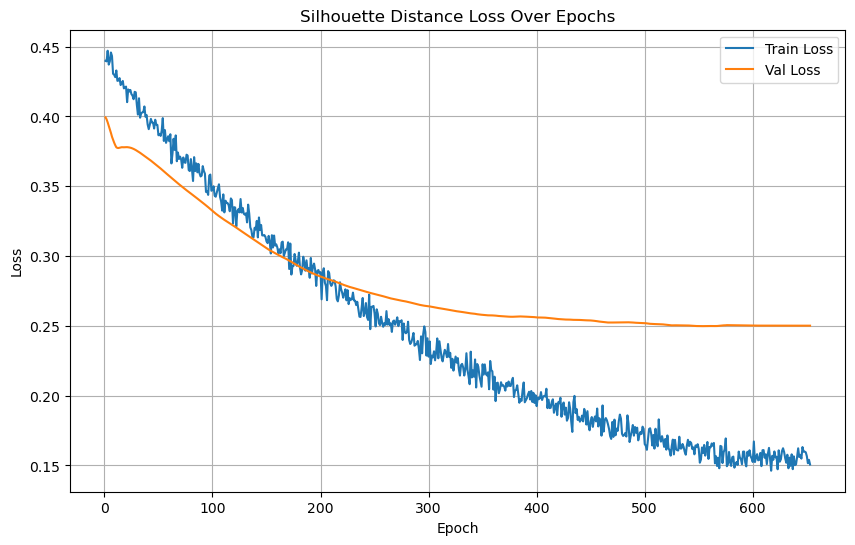

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2313], Loss: 0.0953


Test Batch [20/2313], Loss: 0.1767
Test Batch [30/2313], Loss: 0.5000
Test Batch [40/2313], Loss: 0.1141
Test Batch [50/2313], Loss: 0.5000
Test Batch [60/2313], Loss: 0.5000


Test Batch [70/2313], Loss: 0.5000
Test Batch [80/2313], Loss: 0.1637


Test Batch [90/2313], Loss: 0.5000
Test Batch [100/2313], Loss: 0.0748
Test Batch [110/2313], Loss: 0.5000
Test Batch [120/2313], Loss: 0.1471


Test Batch [130/2313], Loss: 0.5000
Test Batch [140/2313], Loss: 0.5000


Test Batch [150/2313], Loss: 0.5000
Test Batch [160/2313], Loss: 0.1144
Test Batch [170/2313], Loss: 0.5000
Test Batch [180/2313], Loss: 0.5000


Test Batch [190/2313], Loss: 0.5000
Test Batch [200/2313], Loss: 0.1134
Test Batch [210/2313], Loss: 0.5000


Test Batch [220/2313], Loss: 0.5000
Test Batch [230/2313], Loss: 0.0887
Test Batch [240/2313], Loss: 0.0328
Test Batch [250/2313], Loss: 0.1445


Test Batch [260/2313], Loss: 0.5000
Test Batch [270/2313], Loss: 0.5000
Test Batch [280/2313], Loss: 0.5000


Test Batch [290/2313], Loss: 0.1206
Test Batch [300/2313], Loss: 0.1413
Test Batch [310/2313], Loss: 0.5000


Test Batch [320/2313], Loss: 0.0823
Test Batch [330/2313], Loss: 0.5000
Test Batch [340/2313], Loss: 0.5000


Test Batch [350/2313], Loss: 0.1416
Test Batch [360/2313], Loss: 0.1211
Test Batch [370/2313], Loss: 0.1426
Test Batch [380/2313], Loss: 0.0839


Test Batch [390/2313], Loss: 0.5000
Test Batch [400/2313], Loss: 0.5000
Test Batch [410/2313], Loss: 0.0607


Test Batch [420/2313], Loss: 0.0799
Test Batch [430/2313], Loss: 0.1391
Test Batch [440/2313], Loss: 0.5000
Test Batch [450/2313], Loss: 0.0773


Test Batch [460/2313], Loss: 0.5000
Test Batch [470/2313], Loss: 0.1637


Test Batch [480/2313], Loss: 0.5000
Test Batch [490/2313], Loss: 0.0899
Test Batch [500/2313], Loss: 0.0879
Test Batch [510/2313], Loss: 0.0897


Test Batch [520/2313], Loss: 0.0871
Test Batch [530/2313], Loss: 0.5000


Test Batch [540/2313], Loss: 0.0425
Test Batch [550/2313], Loss: 0.0829
Test Batch [560/2313], Loss: 0.5000
Test Batch [570/2313], Loss: 0.5000


Test Batch [580/2313], Loss: 0.0756


Test Batch [590/2313], Loss: 0.0728
Test Batch [600/2313], Loss: 0.5000
Test Batch [610/2313], Loss: 0.5000
Test Batch [620/2313], Loss: 0.1013
Test Batch [630/2313], Loss: 0.0211


Test Batch [640/2313], Loss: 0.1087
Test Batch [650/2313], Loss: 0.5000
Test Batch [660/2313], Loss: 0.0606
Test Batch [670/2313], Loss: 0.1218
Test Batch [680/2313], Loss: 0.5000


Test Batch [690/2313], Loss: 0.0732
Test Batch [700/2313], Loss: 0.1817
Test Batch [710/2313], Loss: 0.5000
Test Batch [720/2313], Loss: 0.5000
Test Batch [730/2313], Loss: 0.5000
Test Batch [740/2313], Loss: 0.5000
Test Batch [750/2313], Loss: 0.1333


Test Batch [760/2313], Loss: 0.0598
Test Batch [770/2313], Loss: 0.5000
Test Batch [780/2313], Loss: 0.0161
Test Batch [790/2313], Loss: 0.1280
Test Batch [800/2313], Loss: 0.1037


Test Batch [810/2313], Loss: 0.5000
Test Batch [820/2313], Loss: 0.0976
Test Batch [830/2313], Loss: 0.0418
Test Batch [840/2313], Loss: 0.0186
Test Batch [850/2313], Loss: 0.2548


Test Batch [860/2313], Loss: 0.5000
Test Batch [870/2313], Loss: 0.1369
Test Batch [880/2313], Loss: 0.0341
Test Batch [890/2313], Loss: 0.5000
Test Batch [900/2313], Loss: 0.5000
Test Batch [910/2313], Loss: 0.0223
Test Batch [920/2313], Loss: 0.5000
Test Batch [930/2313], Loss: 0.1102


Test Batch [940/2313], Loss: 0.1227
Test Batch [950/2313], Loss: 0.0253
Test Batch [960/2313], Loss: 0.5000
Test Batch [970/2313], Loss: 0.5000
Test Batch [980/2313], Loss: 0.0219
Test Batch [990/2313], Loss: 0.1329
Test Batch [1000/2313], Loss: 0.5000


Test Batch [1010/2313], Loss: 0.0568
Test Batch [1020/2313], Loss: 0.0843
Test Batch [1030/2313], Loss: 0.5000
Test Batch [1040/2313], Loss: 0.0993
Test Batch [1050/2313], Loss: 0.0715
Test Batch [1060/2313], Loss: 0.5000


Test Batch [1070/2313], Loss: 0.0283
Test Batch [1080/2313], Loss: 0.5000
Test Batch [1090/2313], Loss: 0.0490
Test Batch [1100/2313], Loss: 0.1175
Test Batch [1110/2313], Loss: 0.1859


Test Batch [1120/2313], Loss: 0.0390
Test Batch [1130/2313], Loss: 0.1466
Test Batch [1140/2313], Loss: 0.1021
Test Batch [1150/2313], Loss: 0.5000
Test Batch [1160/2313], Loss: 0.0595


Test Batch [1170/2313], Loss: 0.0417
Test Batch [1180/2313], Loss: 0.1857
Test Batch [1190/2313], Loss: 0.1710
Test Batch [1200/2313], Loss: 0.0701
Test Batch [1210/2313], Loss: 0.0853


Test Batch [1220/2313], Loss: 0.1177
Test Batch [1230/2313], Loss: 0.1010
Test Batch [1240/2313], Loss: 0.1181
Test Batch [1250/2313], Loss: 0.0169
Test Batch [1260/2313], Loss: 0.0865


Test Batch [1270/2313], Loss: 0.0916
Test Batch [1280/2313], Loss: 0.0839
Test Batch [1290/2313], Loss: 0.0786
Test Batch [1300/2313], Loss: 0.1403


Test Batch [1310/2313], Loss: 0.1639
Test Batch [1320/2313], Loss: 0.2022
Test Batch [1330/2313], Loss: 0.1503
Test Batch [1340/2313], Loss: 0.0399


Test Batch [1350/2313], Loss: 0.2298
Test Batch [1360/2313], Loss: 0.2249
Test Batch [1370/2313], Loss: 0.5000


Test Batch [1380/2313], Loss: 0.1545
Test Batch [1390/2313], Loss: 0.1176
Test Batch [1400/2313], Loss: 0.1489


Test Batch [1410/2313], Loss: 0.1764
Test Batch [1420/2313], Loss: 0.2196
Test Batch [1430/2313], Loss: 0.0175
Test Batch [1440/2313], Loss: 0.1072


Test Batch [1450/2313], Loss: 0.1341
Test Batch [1460/2313], Loss: 0.0905
Test Batch [1470/2313], Loss: 0.0820
Test Batch [1480/2313], Loss: 0.1097


Test Batch [1490/2313], Loss: 0.1979
Test Batch [1500/2313], Loss: 0.1193
Test Batch [1510/2313], Loss: 0.1055
Test Batch [1520/2313], Loss: 0.5000


Test Batch [1530/2313], Loss: 0.1149
Test Batch [1540/2313], Loss: 0.1550
Test Batch [1550/2313], Loss: 0.1559
Test Batch [1560/2313], Loss: 0.1057


Test Batch [1570/2313], Loss: 0.0987
Test Batch [1580/2313], Loss: 0.0924
Test Batch [1590/2313], Loss: 0.1087


Test Batch [1600/2313], Loss: 0.1577
Test Batch [1610/2313], Loss: 0.1341
Test Batch [1620/2313], Loss: 0.1313
Test Batch [1630/2313], Loss: 0.1486


Test Batch [1640/2313], Loss: 0.1609
Test Batch [1650/2313], Loss: 0.0548
Test Batch [1660/2313], Loss: 0.1990
Test Batch [1670/2313], Loss: 0.1720


Test Batch [1680/2313], Loss: 0.2151
Test Batch [1690/2313], Loss: 0.2426
Test Batch [1700/2313], Loss: 0.1202
Test Batch [1710/2313], Loss: 0.1133


Test Batch [1720/2313], Loss: 0.0857
Test Batch [1730/2313], Loss: 0.0524
Test Batch [1740/2313], Loss: 0.5000
Test Batch [1750/2313], Loss: 0.0869
Test Batch [1760/2313], Loss: 0.0867
Test Batch [1770/2313], Loss: 0.0985
Test Batch [1780/2313], Loss: 0.0962


Test Batch [1790/2313], Loss: 0.0983
Test Batch [1800/2313], Loss: 0.0976
Test Batch [1810/2313], Loss: 0.1175
Test Batch [1820/2313], Loss: 0.1760
Test Batch [1830/2313], Loss: 0.0309
Test Batch [1840/2313], Loss: 0.2108


Test Batch [1850/2313], Loss: 0.1079
Test Batch [1860/2313], Loss: 0.1105
Test Batch [1870/2313], Loss: 0.1173
Test Batch [1880/2313], Loss: 0.1319
Test Batch [1890/2313], Loss: 0.1376
Test Batch [1900/2313], Loss: 0.1211


Test Batch [1910/2313], Loss: 0.1693
Test Batch [1920/2313], Loss: 0.2228
Test Batch [1930/2313], Loss: 0.1416
Test Batch [1940/2313], Loss: 0.1413
Test Batch [1950/2313], Loss: 0.1422


Test Batch [1960/2313], Loss: 0.1440
Test Batch [1970/2313], Loss: 0.1073
Test Batch [1980/2313], Loss: 0.1173
Test Batch [1990/2313], Loss: 0.0830
Test Batch [2000/2313], Loss: 0.1789
Test Batch [2010/2313], Loss: 0.0889


Test Batch [2020/2313], Loss: 0.1158
Test Batch [2030/2313], Loss: 0.1061
Test Batch [2040/2313], Loss: 0.1392
Test Batch [2050/2313], Loss: 0.1943
Test Batch [2060/2313], Loss: 0.1385


Test Batch [2070/2313], Loss: 0.0861
Test Batch [2080/2313], Loss: 0.5000
Test Batch [2090/2313], Loss: 0.5000
Test Batch [2100/2313], Loss: 0.5000
Test Batch [2110/2313], Loss: 0.1592
Test Batch [2120/2313], Loss: 0.2095
Test Batch [2130/2313], Loss: 0.5000


Test Batch [2140/2313], Loss: 0.0791
Test Batch [2150/2313], Loss: 0.5000
Test Batch [2160/2313], Loss: 0.5000
Test Batch [2170/2313], Loss: 0.5000
Test Batch [2180/2313], Loss: 0.5000
Test Batch [2190/2313], Loss: 0.5000


Test Batch [2200/2313], Loss: 0.0657
Test Batch [2210/2313], Loss: 0.2863
Test Batch [2220/2313], Loss: 0.5000
Test Batch [2230/2313], Loss: 0.0487
Test Batch [2240/2313], Loss: 0.5000
Test Batch [2250/2313], Loss: 0.5000


Test Batch [2260/2313], Loss: 0.5000
Test Batch [2270/2313], Loss: 0.1347
Test Batch [2280/2313], Loss: 0.0245
Test Batch [2290/2313], Loss: 0.0926
Test Batch [2300/2313], Loss: 0.5000
Test Batch [2310/2313], Loss: 0.5000

Test Loss: 0.2271


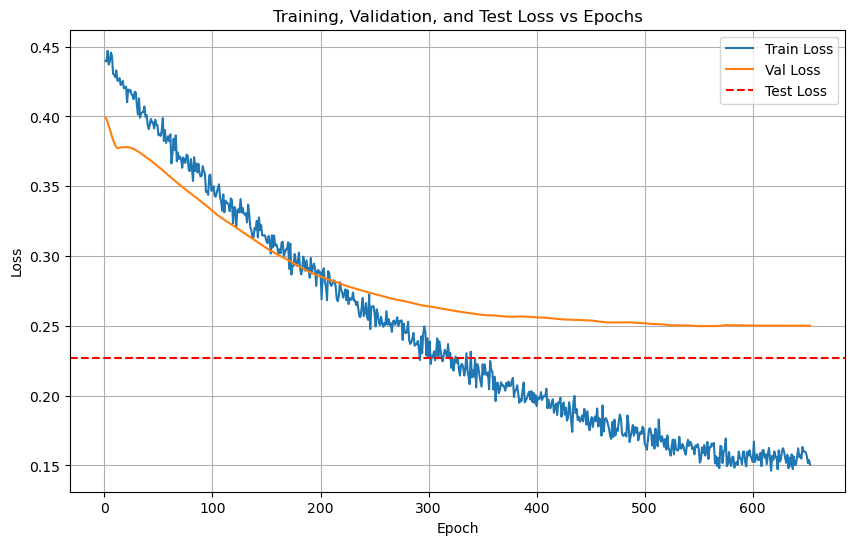

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2313 for test dataset.
  Processed batch 20/2313 for test dataset.
  Processed batch 30/2313 for test dataset.


  Processed batch 40/2313 for test dataset.
  Processed batch 50/2313 for test dataset.
  Processed batch 60/2313 for test dataset.
  Processed batch 70/2313 for test dataset.


  Processed batch 80/2313 for test dataset.
  Processed batch 90/2313 for test dataset.
  Processed batch 100/2313 for test dataset.
  Processed batch 110/2313 for test dataset.


  Processed batch 120/2313 for test dataset.
  Processed batch 130/2313 for test dataset.
  Processed batch 140/2313 for test dataset.


  Processed batch 150/2313 for test dataset.
  Processed batch 160/2313 for test dataset.
  Processed batch 170/2313 for test dataset.
  Processed batch 180/2313 for test dataset.


  Processed batch 190/2313 for test dataset.
  Processed batch 200/2313 for test dataset.
  Processed batch 210/2313 for test dataset.
  Processed batch 220/2313 for test dataset.


  Processed batch 230/2313 for test dataset.
  Processed batch 240/2313 for test dataset.
  Processed batch 250/2313 for test dataset.
  Processed batch 260/2313 for test dataset.


  Processed batch 270/2313 for test dataset.
  Processed batch 280/2313 for test dataset.
  Processed batch 290/2313 for test dataset.
  Processed batch 300/2313 for test dataset.


  Processed batch 310/2313 for test dataset.
  Processed batch 320/2313 for test dataset.
  Processed batch 330/2313 for test dataset.
  Processed batch 340/2313 for test dataset.


  Processed batch 350/2313 for test dataset.
  Processed batch 360/2313 for test dataset.
  Processed batch 370/2313 for test dataset.


  Processed batch 380/2313 for test dataset.
  Processed batch 390/2313 for test dataset.
  Processed batch 400/2313 for test dataset.
  Processed batch 410/2313 for test dataset.


  Processed batch 420/2313 for test dataset.
  Processed batch 430/2313 for test dataset.
  Processed batch 440/2313 for test dataset.
  Processed batch 450/2313 for test dataset.


  Processed batch 460/2313 for test dataset.
  Processed batch 470/2313 for test dataset.
  Processed batch 480/2313 for test dataset.
  Processed batch 490/2313 for test dataset.


  Processed batch 500/2313 for test dataset.
  Processed batch 510/2313 for test dataset.
  Processed batch 520/2313 for test dataset.
  Processed batch 530/2313 for test dataset.


  Processed batch 540/2313 for test dataset.
  Processed batch 550/2313 for test dataset.
  Processed batch 560/2313 for test dataset.
  Processed batch 570/2313 for test dataset.


  Processed batch 580/2313 for test dataset.
  Processed batch 590/2313 for test dataset.
  Processed batch 600/2313 for test dataset.
  Processed batch 610/2313 for test dataset.


  Processed batch 620/2313 for test dataset.
  Processed batch 630/2313 for test dataset.
  Processed batch 640/2313 for test dataset.
  Processed batch 650/2313 for test dataset.


  Processed batch 660/2313 for test dataset.
  Processed batch 670/2313 for test dataset.
  Processed batch 680/2313 for test dataset.
  Processed batch 690/2313 for test dataset.


  Processed batch 700/2313 for test dataset.
  Processed batch 710/2313 for test dataset.
  Processed batch 720/2313 for test dataset.
  Processed batch 730/2313 for test dataset.


  Processed batch 740/2313 for test dataset.
  Processed batch 750/2313 for test dataset.
  Processed batch 760/2313 for test dataset.
  Processed batch 770/2313 for test dataset.


  Processed batch 780/2313 for test dataset.
  Processed batch 790/2313 for test dataset.
  Processed batch 800/2313 for test dataset.
  Processed batch 810/2313 for test dataset.


  Processed batch 820/2313 for test dataset.
  Processed batch 830/2313 for test dataset.
  Processed batch 840/2313 for test dataset.
  Processed batch 850/2313 for test dataset.


  Processed batch 860/2313 for test dataset.
  Processed batch 870/2313 for test dataset.
  Processed batch 880/2313 for test dataset.


  Processed batch 890/2313 for test dataset.
  Processed batch 900/2313 for test dataset.
  Processed batch 910/2313 for test dataset.
  Processed batch 920/2313 for test dataset.


  Processed batch 930/2313 for test dataset.
  Processed batch 940/2313 for test dataset.
  Processed batch 950/2313 for test dataset.
  Processed batch 960/2313 for test dataset.


  Processed batch 970/2313 for test dataset.
  Processed batch 980/2313 for test dataset.
  Processed batch 990/2313 for test dataset.
  Processed batch 1000/2313 for test dataset.


  Processed batch 1010/2313 for test dataset.
  Processed batch 1020/2313 for test dataset.
  Processed batch 1030/2313 for test dataset.
  Processed batch 1040/2313 for test dataset.


  Processed batch 1050/2313 for test dataset.
  Processed batch 1060/2313 for test dataset.
  Processed batch 1070/2313 for test dataset.
  Processed batch 1080/2313 for test dataset.


  Processed batch 1090/2313 for test dataset.
  Processed batch 1100/2313 for test dataset.
  Processed batch 1110/2313 for test dataset.
  Processed batch 1120/2313 for test dataset.


  Processed batch 1130/2313 for test dataset.
  Processed batch 1140/2313 for test dataset.
  Processed batch 1150/2313 for test dataset.


  Processed batch 1160/2313 for test dataset.
  Processed batch 1170/2313 for test dataset.
  Processed batch 1180/2313 for test dataset.


  Processed batch 1190/2313 for test dataset.
  Processed batch 1200/2313 for test dataset.
  Processed batch 1210/2313 for test dataset.
  Processed batch 1220/2313 for test dataset.


  Processed batch 1230/2313 for test dataset.
  Processed batch 1240/2313 for test dataset.
  Processed batch 1250/2313 for test dataset.
  Processed batch 1260/2313 for test dataset.


  Processed batch 1270/2313 for test dataset.
  Processed batch 1280/2313 for test dataset.
  Processed batch 1290/2313 for test dataset.
  Processed batch 1300/2313 for test dataset.


  Processed batch 1310/2313 for test dataset.
  Processed batch 1320/2313 for test dataset.
  Processed batch 1330/2313 for test dataset.
  Processed batch 1340/2313 for test dataset.


  Processed batch 1350/2313 for test dataset.
  Processed batch 1360/2313 for test dataset.
  Processed batch 1370/2313 for test dataset.
  Processed batch 1380/2313 for test dataset.


  Processed batch 1390/2313 for test dataset.
  Processed batch 1400/2313 for test dataset.
  Processed batch 1410/2313 for test dataset.
  Processed batch 1420/2313 for test dataset.


  Processed batch 1430/2313 for test dataset.
  Processed batch 1440/2313 for test dataset.
  Processed batch 1450/2313 for test dataset.


  Processed batch 1460/2313 for test dataset.
  Processed batch 1470/2313 for test dataset.
  Processed batch 1480/2313 for test dataset.
  Processed batch 1490/2313 for test dataset.


  Processed batch 1500/2313 for test dataset.
  Processed batch 1510/2313 for test dataset.
  Processed batch 1520/2313 for test dataset.


  Processed batch 1530/2313 for test dataset.
  Processed batch 1540/2313 for test dataset.
  Processed batch 1550/2313 for test dataset.
  Processed batch 1560/2313 for test dataset.


  Processed batch 1570/2313 for test dataset.
  Processed batch 1580/2313 for test dataset.
  Processed batch 1590/2313 for test dataset.
  Processed batch 1600/2313 for test dataset.


  Processed batch 1610/2313 for test dataset.
  Processed batch 1620/2313 for test dataset.
  Processed batch 1630/2313 for test dataset.
  Processed batch 1640/2313 for test dataset.


  Processed batch 1650/2313 for test dataset.
  Processed batch 1660/2313 for test dataset.
  Processed batch 1670/2313 for test dataset.
  Processed batch 1680/2313 for test dataset.


  Processed batch 1690/2313 for test dataset.
  Processed batch 1700/2313 for test dataset.
  Processed batch 1710/2313 for test dataset.
  Processed batch 1720/2313 for test dataset.


  Processed batch 1730/2313 for test dataset.
  Processed batch 1740/2313 for test dataset.
  Processed batch 1750/2313 for test dataset.
  Processed batch 1760/2313 for test dataset.


  Processed batch 1770/2313 for test dataset.
  Processed batch 1780/2313 for test dataset.
  Processed batch 1790/2313 for test dataset.
  Processed batch 1800/2313 for test dataset.


  Processed batch 1810/2313 for test dataset.
  Processed batch 1820/2313 for test dataset.
  Processed batch 1830/2313 for test dataset.
  Processed batch 1840/2313 for test dataset.


  Processed batch 1850/2313 for test dataset.
  Processed batch 1860/2313 for test dataset.
  Processed batch 1870/2313 for test dataset.
  Processed batch 1880/2313 for test dataset.


  Processed batch 1890/2313 for test dataset.
  Processed batch 1900/2313 for test dataset.
  Processed batch 1910/2313 for test dataset.
  Processed batch 1920/2313 for test dataset.


  Processed batch 1930/2313 for test dataset.
  Processed batch 1940/2313 for test dataset.
  Processed batch 1950/2313 for test dataset.
  Processed batch 1960/2313 for test dataset.


  Processed batch 1970/2313 for test dataset.
  Processed batch 1980/2313 for test dataset.
  Processed batch 1990/2313 for test dataset.


  Processed batch 2000/2313 for test dataset.
  Processed batch 2010/2313 for test dataset.
  Processed batch 2020/2313 for test dataset.
  Processed batch 2030/2313 for test dataset.


  Processed batch 2040/2313 for test dataset.
  Processed batch 2050/2313 for test dataset.
  Processed batch 2060/2313 for test dataset.


  Processed batch 2070/2313 for test dataset.
  Processed batch 2080/2313 for test dataset.
  Processed batch 2090/2313 for test dataset.
  Processed batch 2100/2313 for test dataset.


  Processed batch 2110/2313 for test dataset.
  Processed batch 2120/2313 for test dataset.
  Processed batch 2130/2313 for test dataset.
  Processed batch 2140/2313 for test dataset.


  Processed batch 2150/2313 for test dataset.
  Processed batch 2160/2313 for test dataset.
  Processed batch 2170/2313 for test dataset.
  Processed batch 2180/2313 for test dataset.


  Processed batch 2190/2313 for test dataset.
  Processed batch 2200/2313 for test dataset.
  Processed batch 2210/2313 for test dataset.
  Processed batch 2220/2313 for test dataset.


  Processed batch 2230/2313 for test dataset.
  Processed batch 2240/2313 for test dataset.
  Processed batch 2250/2313 for test dataset.
  Processed batch 2260/2313 for test dataset.


  Processed batch 2270/2313 for test dataset.
  Processed batch 2280/2313 for test dataset.
  Processed batch 2290/2313 for test dataset.
  Processed batch 2300/2313 for test dataset.


  Processed batch 2310/2313 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       1.00      0.40      0.57         5
           3       0.83      1.00      0.91         5
           4       0.83      1.00      0.91         5
           5       0.71      1.00      0.83         5
           6       1.00      0.60      0.75         5
           7       1.00      1.00      1.00         5
           8       1.00      0.80      0.89         5

    accuracy                           0.87        45
   macro avg       0.90      0.87      0.86        45
weighted avg       0.90      0.87      0.86        45


LOG: Evaluating on the test set...
Test Accuracy: 95.36%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65956
           1       0.84      0.89      0.86      7583
           2       0.60      0.46      0.52      3075
           3       0.63      0.92      0.75      2670
           4       0.90      0.90      0.90      6569
           5       0.83      0.94      0.88      9233
           6       0.93      0.84      0.88      7272
           7       0.99      0.97      0.98     42811
           8       0.99      0.96      0.97      2848

    accuracy                           0.95    148017
   macro avg       0.86      0.87      0.86    148017
weighted avg       0.96      0.95      0.95    148017

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (90, 128)
Train labels shape: (90,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (148017, 128)
Test labels shape: (148017,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5120  |  Val Loss: 2.3148
Validation loss improved from inf to 2.3148.
[Epoch 2/1000] Train Loss: 2.4742  |  Val Loss: 2.2864
Validation loss improved from 2.3148 to 2.2864.
[Epoch 3/1000] Train Loss: 2.4364  |  Val Loss: 2.2586
Validation loss improved from 2.2864 to 2.2586.
[Epoch 4/1000] Train Loss: 2.4007  |  Val Loss: 2.2322
Validation loss improved from 2.2586 to 2.2322.
[Epoch 5/1000] Train Loss: 2.3647  |  Val Loss: 2.2067
Validation loss improved from 2.2322 to 2.2067.
[Epoch 6/1000] Train Loss: 2.3305  |  Val Loss: 2.1816
Validation loss improved from 2.2067 to 2.1816.
[Epoch 7/1000] Train Loss: 2.2980  |  Val Loss: 2.1568
Validation loss improved from 2.1816 to 2.1568.
[Epoch 8/1000] Train Loss: 2.2643  |  Val Loss: 2.1323
Validation loss improved from 2.1568 to 2.1323.
[Epoch 9/1000] Train Loss: 2.2319  |  Val Loss: 2.1085
Validation loss improved from 2.1323 to 2.1085.
[Epoch 10/1000] Train Loss: 2.1995  |  Val Loss: 2.0850
Validation loss impr

[Epoch 38/1000] Train Loss: 1.5491  |  Val Loss: 1.6237
Validation loss improved from 1.6355 to 1.6237.
[Epoch 39/1000] Train Loss: 1.5330  |  Val Loss: 1.6122
Validation loss improved from 1.6237 to 1.6122.
[Epoch 40/1000] Train Loss: 1.5171  |  Val Loss: 1.6010
Validation loss improved from 1.6122 to 1.6010.
[Epoch 41/1000] Train Loss: 1.5011  |  Val Loss: 1.5901
Validation loss improved from 1.6010 to 1.5901.
[Epoch 42/1000] Train Loss: 1.4858  |  Val Loss: 1.5793
Validation loss improved from 1.5901 to 1.5793.
[Epoch 43/1000] Train Loss: 1.4712  |  Val Loss: 1.5686
Validation loss improved from 1.5793 to 1.5686.
[Epoch 44/1000] Train Loss: 1.4562  |  Val Loss: 1.5581
Validation loss improved from 1.5686 to 1.5581.
[Epoch 45/1000] Train Loss: 1.4414  |  Val Loss: 1.5477
Validation loss improved from 1.5581 to 1.5477.
[Epoch 46/1000] Train Loss: 1.4273  |  Val Loss: 1.5374
Validation loss improved from 1.5477 to 1.5374.
[Epoch 47/1000] Train Loss: 1.4133  |  Val Loss: 1.5274
Validati

[Epoch 85/1000] Train Loss: 0.9512  |  Val Loss: 1.2342
Validation loss improved from 1.2403 to 1.2342.
[Epoch 86/1000] Train Loss: 0.9406  |  Val Loss: 1.2279
Validation loss improved from 1.2342 to 1.2279.
[Epoch 87/1000] Train Loss: 0.9301  |  Val Loss: 1.2215
Validation loss improved from 1.2279 to 1.2215.
[Epoch 88/1000] Train Loss: 0.9198  |  Val Loss: 1.2151
Validation loss improved from 1.2215 to 1.2151.
[Epoch 89/1000] Train Loss: 0.9095  |  Val Loss: 1.2089
Validation loss improved from 1.2151 to 1.2089.
[Epoch 90/1000] Train Loss: 0.8992  |  Val Loss: 1.2029
Validation loss improved from 1.2089 to 1.2029.
[Epoch 91/1000] Train Loss: 0.8890  |  Val Loss: 1.1969
Validation loss improved from 1.2029 to 1.1969.
[Epoch 92/1000] Train Loss: 0.8787  |  Val Loss: 1.1907
Validation loss improved from 1.1969 to 1.1907.
[Epoch 93/1000] Train Loss: 0.8690  |  Val Loss: 1.1846
Validation loss improved from 1.1907 to 1.1846.
[Epoch 94/1000] Train Loss: 0.8590  |  Val Loss: 1.1785
Validati

[Epoch 126/1000] Train Loss: 0.5644  |  Val Loss: 0.9820
Validation loss improved from 0.9879 to 0.9820.
[Epoch 127/1000] Train Loss: 0.5559  |  Val Loss: 0.9762
Validation loss improved from 0.9820 to 0.9762.
[Epoch 128/1000] Train Loss: 0.5478  |  Val Loss: 0.9708
Validation loss improved from 0.9762 to 0.9708.
[Epoch 129/1000] Train Loss: 0.5396  |  Val Loss: 0.9656
Validation loss improved from 0.9708 to 0.9656.
[Epoch 130/1000] Train Loss: 0.5315  |  Val Loss: 0.9603
Validation loss improved from 0.9656 to 0.9603.
[Epoch 131/1000] Train Loss: 0.5234  |  Val Loss: 0.9548
Validation loss improved from 0.9603 to 0.9548.
[Epoch 132/1000] Train Loss: 0.5155  |  Val Loss: 0.9494
Validation loss improved from 0.9548 to 0.9494.
[Epoch 133/1000] Train Loss: 0.5076  |  Val Loss: 0.9439
Validation loss improved from 0.9494 to 0.9439.
[Epoch 134/1000] Train Loss: 0.5000  |  Val Loss: 0.9385
Validation loss improved from 0.9439 to 0.9385.
[Epoch 135/1000] Train Loss: 0.4919  |  Val Loss: 0.933

[Epoch 168/1000] Train Loss: 0.2805  |  Val Loss: 0.7879
Validation loss improved from 0.7919 to 0.7879.
[Epoch 169/1000] Train Loss: 0.2755  |  Val Loss: 0.7842
Validation loss improved from 0.7879 to 0.7842.
[Epoch 170/1000] Train Loss: 0.2706  |  Val Loss: 0.7805
Validation loss improved from 0.7842 to 0.7805.
[Epoch 171/1000] Train Loss: 0.2658  |  Val Loss: 0.7767
Validation loss improved from 0.7805 to 0.7767.
[Epoch 172/1000] Train Loss: 0.2613  |  Val Loss: 0.7728
Validation loss improved from 0.7767 to 0.7728.
[Epoch 173/1000] Train Loss: 0.2565  |  Val Loss: 0.7691
Validation loss improved from 0.7728 to 0.7691.
[Epoch 174/1000] Train Loss: 0.2520  |  Val Loss: 0.7655
Validation loss improved from 0.7691 to 0.7655.
[Epoch 175/1000] Train Loss: 0.2477  |  Val Loss: 0.7621
Validation loss improved from 0.7655 to 0.7621.
[Epoch 176/1000] Train Loss: 0.2432  |  Val Loss: 0.7591
Validation loss improved from 0.7621 to 0.7591.
[Epoch 177/1000] Train Loss: 0.2389  |  Val Loss: 0.756

[Epoch 210/1000] Train Loss: 0.1368  |  Val Loss: 0.6845
Validation loss improved from 0.6856 to 0.6845.
[Epoch 211/1000] Train Loss: 0.1347  |  Val Loss: 0.6829
Validation loss improved from 0.6845 to 0.6829.
[Epoch 212/1000] Train Loss: 0.1326  |  Val Loss: 0.6813
Validation loss improved from 0.6829 to 0.6813.
[Epoch 213/1000] Train Loss: 0.1306  |  Val Loss: 0.6797
Validation loss improved from 0.6813 to 0.6797.
[Epoch 214/1000] Train Loss: 0.1286  |  Val Loss: 0.6782
Validation loss improved from 0.6797 to 0.6782.
[Epoch 215/1000] Train Loss: 0.1267  |  Val Loss: 0.6771
Validation loss improved from 0.6782 to 0.6771.
[Epoch 216/1000] Train Loss: 0.1247  |  Val Loss: 0.6757
Validation loss improved from 0.6771 to 0.6757.
[Epoch 217/1000] Train Loss: 0.1229  |  Val Loss: 0.6741
Validation loss improved from 0.6757 to 0.6741.
[Epoch 218/1000] Train Loss: 0.1211  |  Val Loss: 0.6724
Validation loss improved from 0.6741 to 0.6724.
[Epoch 219/1000] Train Loss: 0.1193  |  Val Loss: 0.670

[Epoch 256/1000] Train Loss: 0.0730  |  Val Loss: 0.6484
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 257/1000] Train Loss: 0.0722  |  Val Loss: 0.6482
Validation loss improved from 0.6484 to 0.6482.
[Epoch 258/1000] Train Loss: 0.0713  |  Val Loss: 0.6481
Validation loss improved from 0.6482 to 0.6481.
[Epoch 259/1000] Train Loss: 0.0705  |  Val Loss: 0.6479
Validation loss improved from 0.6481 to 0.6479.
[Epoch 260/1000] Train Loss: 0.0697  |  Val Loss: 0.6476
Validation loss improved from 0.6479 to 0.6476.
[Epoch 261/1000] Train Loss: 0.0689  |  Val Loss: 0.6473
Validation loss improved from 0.6476 to 0.6473.
[Epoch 262/1000] Train Loss: 0.0682  |  Val Loss: 0.6470
Validation loss improved from 0.6473 to 0.6470.
[Epoch 263/1000] Train Loss: 0.0674  |  Val Loss: 0.6467
Validation loss improved from 0.6470 to 0.6467.
[Epoch 264/1000] Train Loss: 0.0667  |  Val Loss: 0.6465
Validation loss improved from 0.6467 to 0.6465.
[Epoch 265/1000] Train Loss: 0.0659  |  Val Loss:

[Epoch 300/1000] Train Loss: 0.0465  |  Val Loss: 0.6466
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 301/1000] Train Loss: 0.0461  |  Val Loss: 0.6471
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 302/1000] Train Loss: 0.0456  |  Val Loss: 0.6473
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 303/1000] Train Loss: 0.0452  |  Val Loss: 0.6477
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 304/1000] Train Loss: 0.0449  |  Val Loss: 0.6480
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 305/1000] Train Loss: 0.0444  |  Val Loss: 0.6483
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 306/1000] Train Loss: 0.0441  |  Val Loss: 0.6484
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 307/1000] Train Loss: 0.0437  |  Val Loss: 0.6485
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 308/1000] Train Loss: 0.0433  |  Val Loss: 0.6490
!! Validation loss did NOT improve !! Patience:

[Epoch 344/1000] Train Loss: 0.0323  |  Val Loss: 0.6553
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 345/1000] Train Loss: 0.0321  |  Val Loss: 0.6547
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 346/1000] Train Loss: 0.0318  |  Val Loss: 0.6542
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 347/1000] Train Loss: 0.0316  |  Val Loss: 0.6534
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 348/1000] Train Loss: 0.0314  |  Val Loss: 0.6525
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 349/1000] Train Loss: 0.0312  |  Val Loss: 0.6519
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 350/1000] Train Loss: 0.0309  |  Val Loss: 0.6515
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 351/1000] Train Loss: 0.0307  |  Val Loss: 0.6511
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 352/1000] Train Loss: 0.0305  |  Val Loss: 0.6509
!! Validation loss did NOT improve !! Patience:

[Epoch 387/1000] Train Loss: 0.0238  |  Val Loss: 0.6693
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 388/1000] Train Loss: 0.0236  |  Val Loss: 0.6692
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 388 !!
No improvement for 100 epochs.


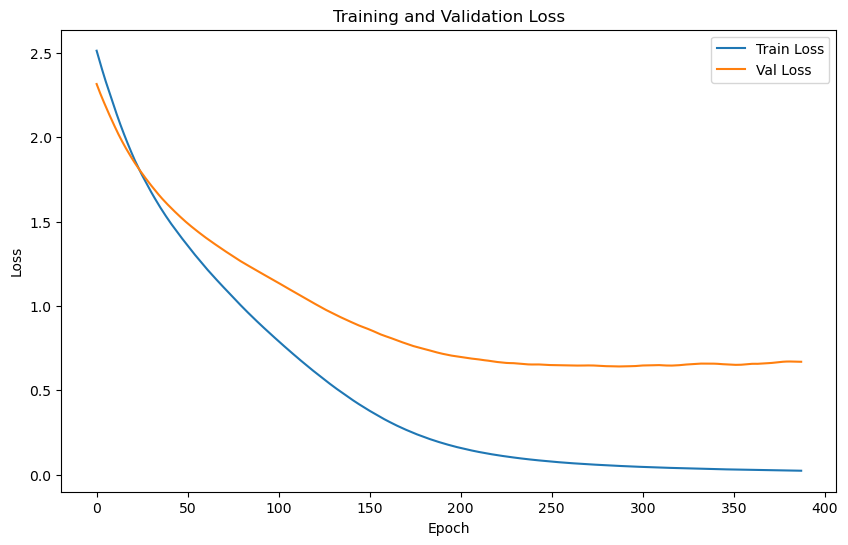

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.2200 | Test Accuracy: 95.26%


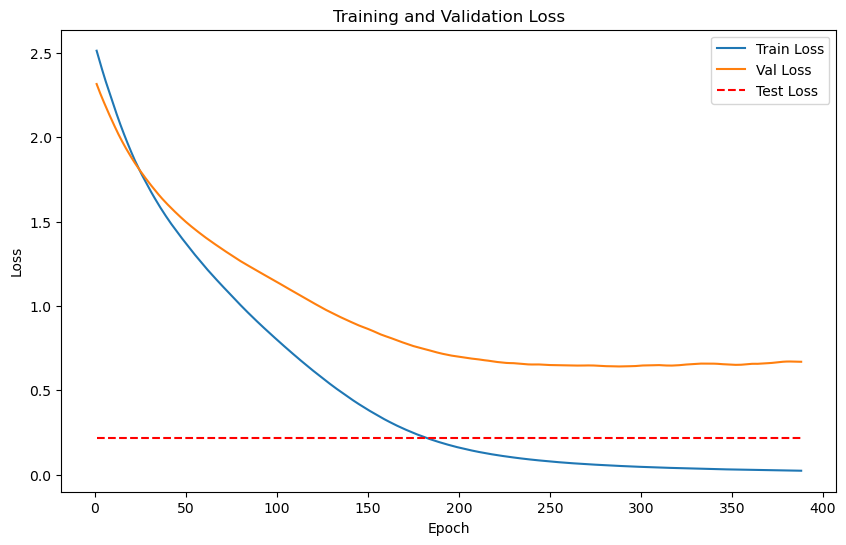

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


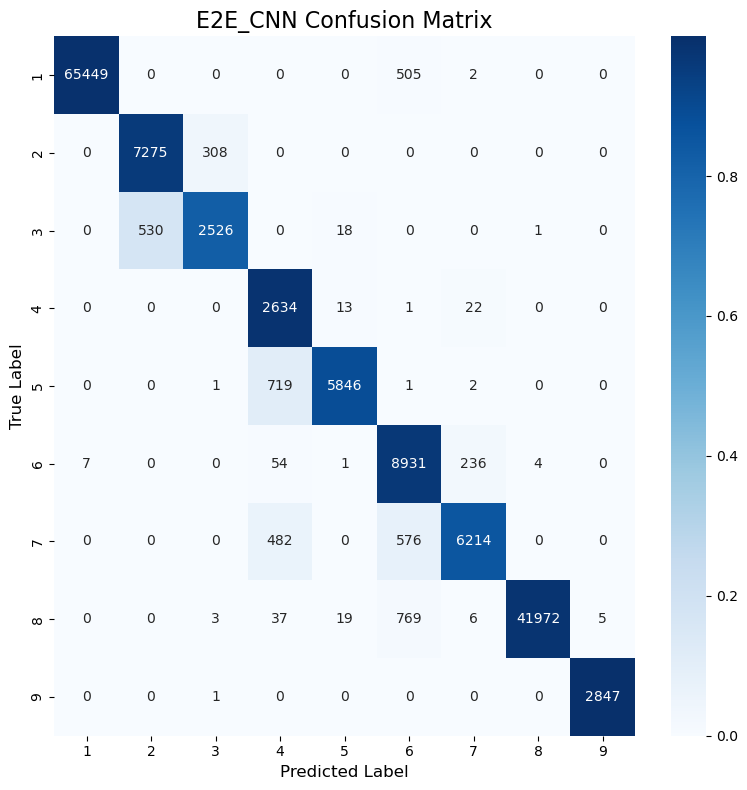

Classification Accuracy: 97.08%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


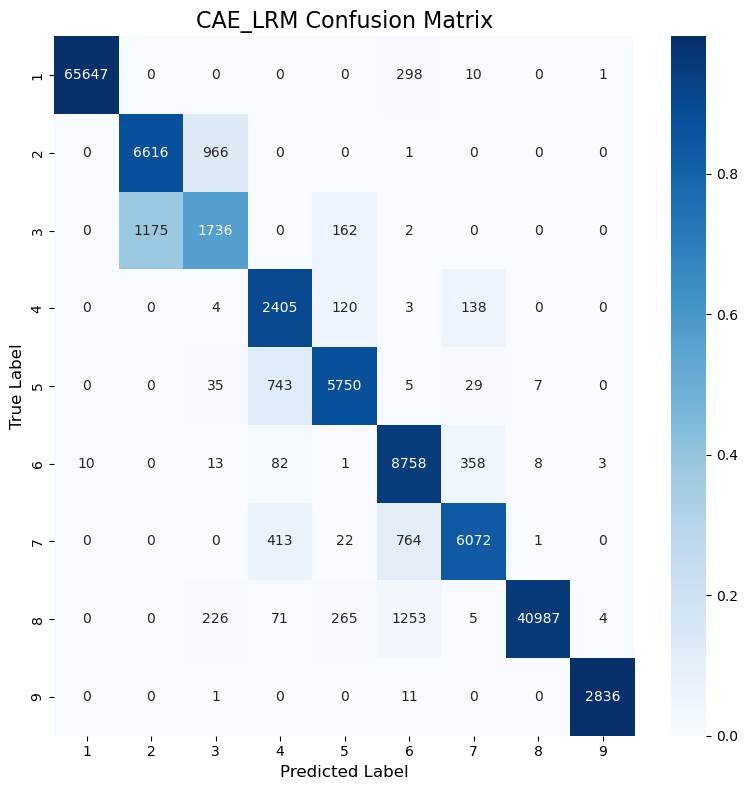

Classification Accuracy: 95.13%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


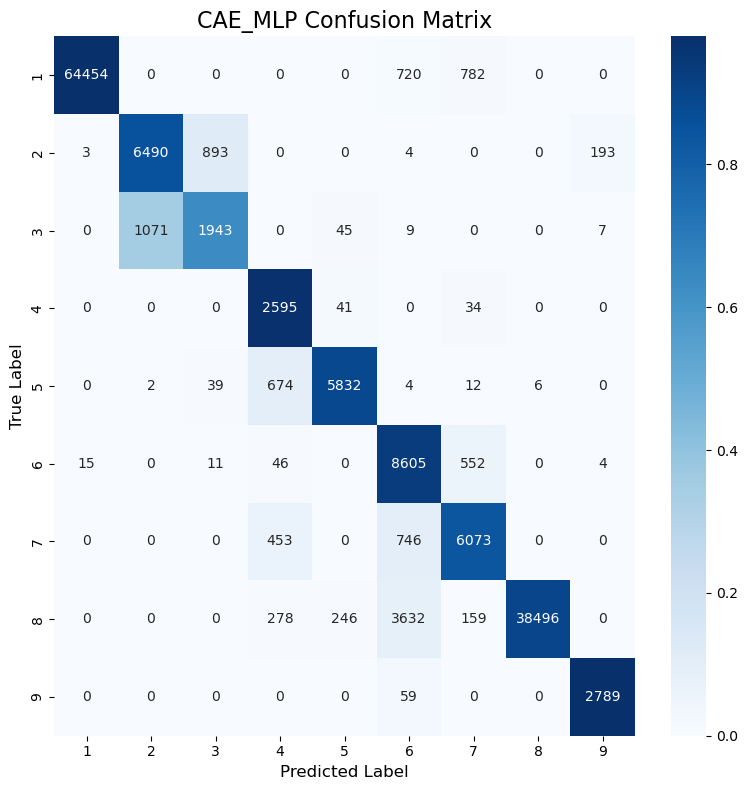

Classification Accuracy: 92.74%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


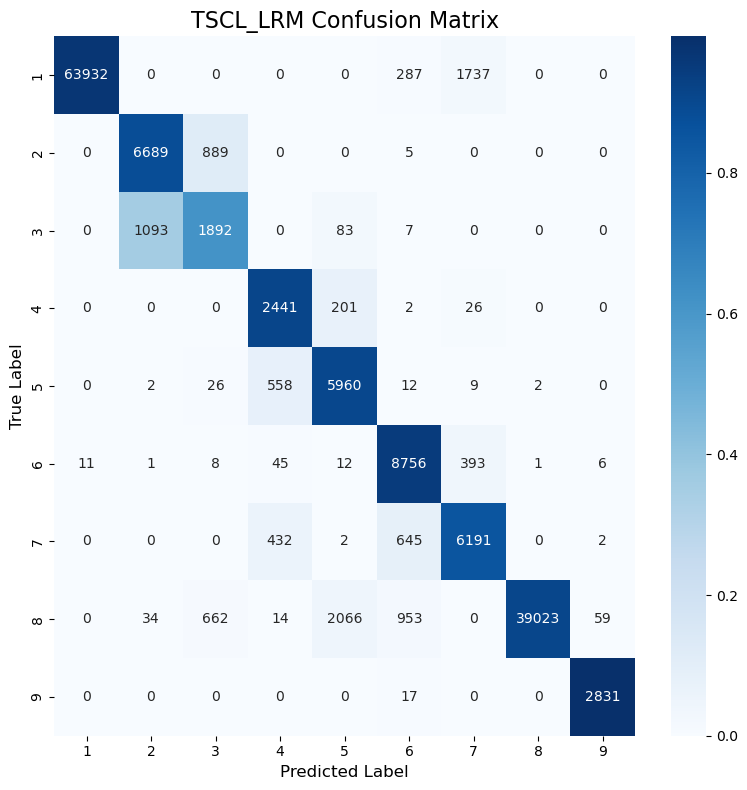

Classification Accuracy: 93.04%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


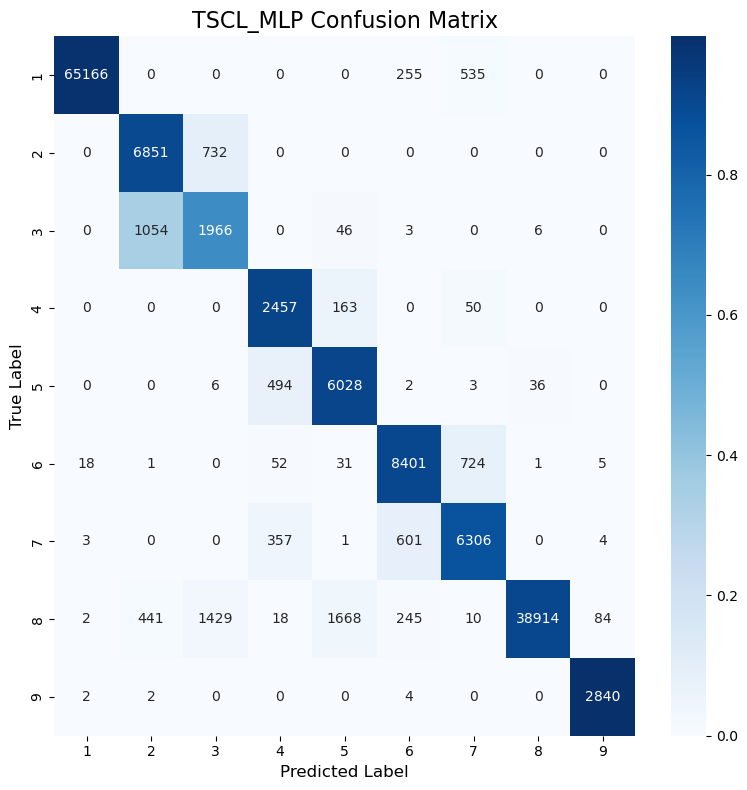

Classification Accuracy: 93.86%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


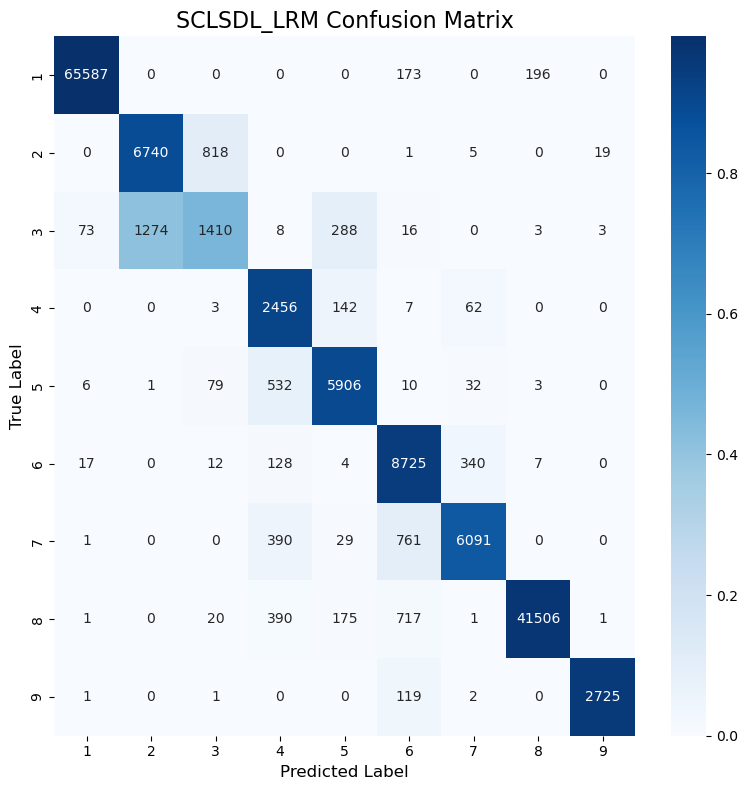

Classification Accuracy: 95.36%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


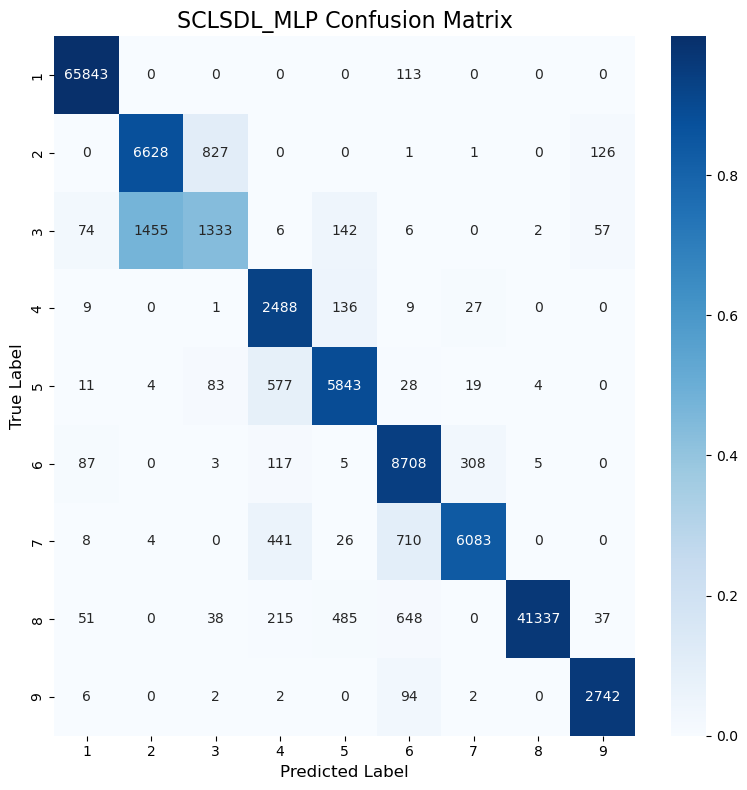

Classification Accuracy: 95.26%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.08
1    LRM (CAE)          95.13
2    MLP (CAE)          92.74
3     TSCL LRM          93.04
4     TSCL MLP          93.86
5  SCL_SDL LRM          95.36
6  SCL_SDL MLP          95.26

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.08
5  SCL_SDL LRM          95.36
6  SCL_SDL MLP          95.26
1    LRM (CAE)          95.13
4     TSCL MLP          93.86
3     TSCL LRM          93.04
2    MLP (CAE)          92.74
